# Autoencoding Prufer ==> Parent sequences

In [1]:
import numpy as np
import scipy

# sklearn
from sklearn.preprocessing import OneHotEncoder

# Keras
from keras.models import Sequential
from keras.layers.core import Dense, Reshape, Dropout, Activation, RepeatVector, Flatten, Permute
from keras.layers import Input, merge, Lambda
from keras.layers.convolutional import Convolution1D
from keras.models import Model
from keras import objectives
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.recurrent import LSTM, GRU
from keras.optimizers import Adagrad, Adam
import keras.backend as K

# Other
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import pickle
import pprint
from __future__ import print_function

%matplotlib inline

# Local
import McNeuron
import models_cmc as models
import train_one_by_one as train
import batch_utils
import data_transforms

Using Theano backend.


## Models

### Encoder

In [38]:
def encoder(prufer_input, hidden_dim, encoding_dim):
    h = Convolution1D(hidden_dim, 5, activation='relu', name='conv1')(prufer_input)
    #h = Convolution1D(hidden_dim, 5, activation='relu', name='conv2')(h)
    #h = Convolution1D(hidden_dim, 5, activation='relu', name='conv3')(h)
    h = Flatten(name='flatten')(h)
    return Dense(encoding_dim, activation = 'relu', name='dense1')(h)

### Sampler

In [39]:
def sampler(encoding_dim):
    batch_size = K.shape(encoded_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, encoding_dim), mean=0., std=0.01)
    return encoded_mean + K.exp(encoded_log_var / 2) * epsilon

### Variational Encoder

In [61]:
def variational_encoder(prufer_input, hidden_dim, encoding_dim):
    
    def sampler(args):
        z_mean, z_log_var = args
        batch_size = K.shape(z_mean)[0]
        epsilon = K.random_normal(shape=(batch_size, encoding_dim), mean=0., std=0.01)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    h = Convolution1D(hidden_dim, 5, activation='relu', name='conv1')(prufer_input)
    #h = Convolution1D(hidden_dim, 5, activation='relu', name='conv2')(h)
    #h = Convolution1D(hidden_dim, 5, activation='relu', name='conv3')(h)
    h = Flatten(name='flatten')(h)
    encoded_mean = Dense(encoding_dim, activation = 'linear', name='encoded_mean')(h)
    encoded_log_var = Dense(encoding_dim, activation = 'linear', name='encoded_log_var')(h)
    encoder_output = Lambda(sampler,
                            output_shape=(encoding_dim,),
                            name='encoder_output')([encoded_mean, encoded_log_var])
    
    def vae_loss(y, y_pred):
        y = K.flatten(y)
        y_pred = K.flatten(y_pred)
        xent_loss = max_length * objectives.binary_crossentropy(y, y_pred)
        kl_loss = - 0.5 * K.mean(1 + encoded_log_var - K.square(encoded_mean) - K.exp(encoded_log_var), axis=-1)
        return xent_loss + kl_loss

    return encoded_output, vae_loss

### Decoder

In [62]:
def decoder(decoder_input, n_nodes, hidden_dim, latent_dim):
    h = Dense(latent_dim, name='latent_input', activation = 'relu')(decoder_input)
    h = RepeatVector(n_nodes-1, name='repeat_vector')(h)
    #h = Bidirectional(LSTM(hidden_dim, return_sequences = True, name='lstm1'), merge_mode='sum')(h)
    #h = Bidirectional(LSTM(hidden_dim, return_sequences = True, name='lstm2'), merge_mode='sum')(h)
    #h = Bidirectional(LSTM(hidden_dim, return_sequences = True, name='lstm3'), merge_mode='sum')(h)
    h = GRU(hidden_dim, return_sequences = True, name='lstm1')(h)
    #h = GRU(hidden_dim, return_sequences = True, name='lstm2')(h)
    #h = GRU(hidden_dim, return_sequences = True, name='lstm3')(h)
    return TimeDistributed(Dense(n_nodes, activation='softmax'), name='decoded_softmax')(h)

### Autoencoder

In [73]:
def autoencoder(prufer_input, n_nodes, hidden_dim, encoding_dim, latent_dim):
    enc = encoder(prufer_input, hidden_dim, encoding_dim)
    dec = decoder(enc, n_nodes, hidden_dim, latent_dim)
    return dec

### Variational autoencoder

In [74]:
def variational_autoencoder(prufer_input, n_nodes, hidden_dim, encoding_dim, latent_dim):
    enc, vae_loss = variational_encoder(prufer_input, hidden_dim, encoding_dim)
    dec = decoder(enc, n_nodes, hidden_dim, latent_dim)
    return dec

### Test API

In [64]:
hidden_dim = 50
encoding_dim = 200
latent_dim = 100
n_nodes = 20

In [67]:
prufer_input = Input(shape=(n_nodes - 2, n_nodes))
#encoded_output = encoder(prufer_input, hidden_dim, encoding_dim)
encoded_output, vae_loss = variational_encoder(prufer_input, hidden_dim, encoding_dim)

decoder_input = Input(shape=(encoding_dim,))
parent_output = decoder(decoder_input, n_nodes, hidden_dim, latent_dim)

#encoding_model = Model(input=prufer_input, output=encoded_output)
#decoding_model = Model(input=decoder_input, output=parent_output)


In [75]:
prufer_input = Input(shape=(n_nodes - 2, n_nodes))
parent_output = autoencoder(prufer_input, n_nodes, hidden_dim, encoding_dim, latent_dim)
autoencoder_model = Model(input=prufer_input, output=parent_output)
autoencoder_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_28 (InputLayer)            (None, 18, 20)        0                                            
____________________________________________________________________________________________________
conv1 (Convolution1D)            (None, 14, 50)        5050        input_28[0][0]                   
____________________________________________________________________________________________________
flatten (Flatten)                (None, 700)           0           conv1[0][0]                      
____________________________________________________________________________________________________
dense1 (Dense)                   (None, 200)           140200      flatten[0][0]                    
___________________________________________________________________________________________

In [77]:
prufer_input = Input(shape=(n_nodes - 2, n_nodes))
parent_output = variational_autoencoder(prufer_input, n_nodes, hidden_dim, encoding_dim, latent_dim)
variational_autoencoder_model = Model(input=prufer_input, output=parent_output)
variational_autoencoder_model.summary()

RuntimeError: Graph disconnected: cannot obtain value for tensor input_7 at layer "input_7". The following previous layers were accessed without issue: []

## Data

In [30]:
def reorder(parents):
    length = len(parents)

    # Construct the adjacency matrix
    adjacency = np.zeros([length, length])
    adjacency[parents[1:], range(1, length)] = 1

    # Discover the permutation with Schur decomposition
    full_adjacency = np.linalg.inv(np.eye(length) - adjacency)
    full_adjacency_permuted, permutation_matrix = \
        scipy.linalg.schur(full_adjacency)

    # Reorder the parents
    parents_reordered = \
        np.argmax(np.eye(length) - np.linalg.inv(full_adjacency_permuted),
                  axis=0)
    parents_reordered[0] = -1

    return list(parents_reordered)

In [31]:
def generate_training_batch(batch_size, n_nodes):
    """
    Generate training examples.
    
    Parameters
    ----------
    batch_size: int
        number of examples to generate
    n_nodes: int
        number of nodes in the tree
        
    Returns
    -------
    X: 3d array (samples, n_nodes - 2, n_nodes)
        softmax representation of prufer sequence
    y: 3d array (samples, n_nodes - 1, n_nodes)
        softmax representation of parent sequence
    """
    X = np.zeros((batch_size, n_nodes - 2, n_nodes))
    y = np.zeros((batch_size, n_nodes - 1, n_nodes))
    
    # One-hot encoder
    prufer_example = np.random.randint(0, n_nodes-1, (n_nodes-2, 1))
    one_hot = OneHotEncoder(n_values=n_nodes)
    one_hot = one_hot.fit(prufer_example)
    
    for example in range(batch_size):
        # Input: prufer sequence softmax
        prufer_array = np.random.randint(0, n_nodes-1, (n_nodes-2, 1))
        X[example, :, :] = one_hot.transform(prufer_array).todense()
        
        # Output: parent sequence softmax
        parents_ = data_transforms.decode_prufer(list(np.squeeze(prufer_array)))
        parents_ = reorder(parents_)[1:]
        parents_softmax = one_hot.transform(np.expand_dims(np.array(parents_), axis=1)).todense()
        y[example, :, :] = parents_softmax
        
    return X, y
    

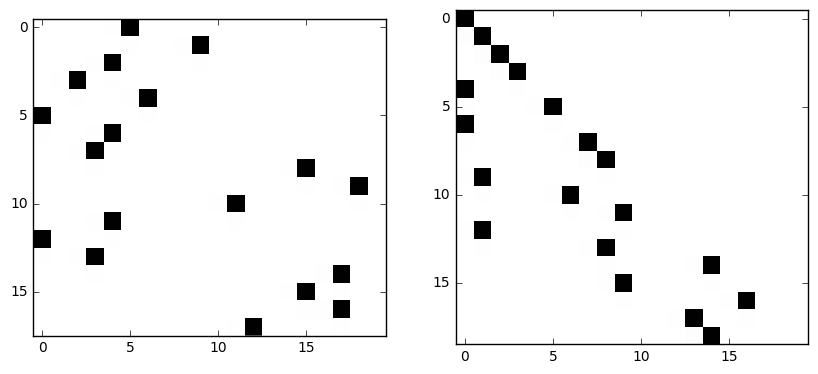

In [32]:
X, y = generate_training_batch(64, n_nodes)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(X[6, :, :], cmap='Greys', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(y[6, :, :], cmap='Greys', interpolation='none')
plt.show()

## Training

### Parameters

In [4]:
# Model parameters
n_nodes = 20
hidden_dim = 50
encoding_dim = 100
latent_dim = 25

# Training parameters
n_epochs = 20
batch_size = 1
n_batch_per_epoch = 1000# np.floor(training_data['morphology']['n20'].shape[0]/batch_size).astype(int)


### Compile

In [34]:
prufer_input = Input(shape=(n_nodes - 2, n_nodes))
parent_output = autoencoder(prufer_input, n_nodes, hidden_dim, encoding_dim, latent_dim)
autoencoder_model = Model(input=prufer_input, output=parent_output)
autoencoder_model.compile(loss='cosine_proximity', optimizer=Adam())

Epoch #0
    Loss: -0.0111576588824


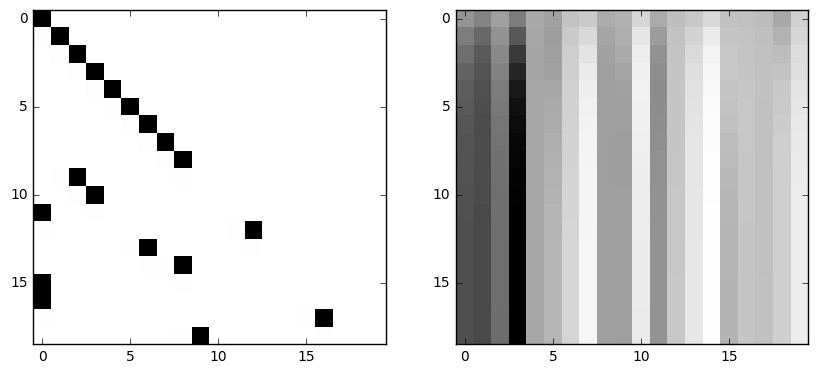

Epoch #100
    Loss: -0.0174003988504


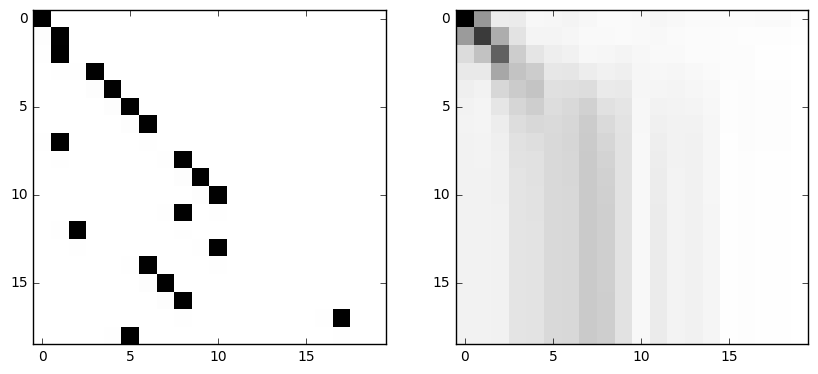

Epoch #200
    Loss: -0.0219563096762


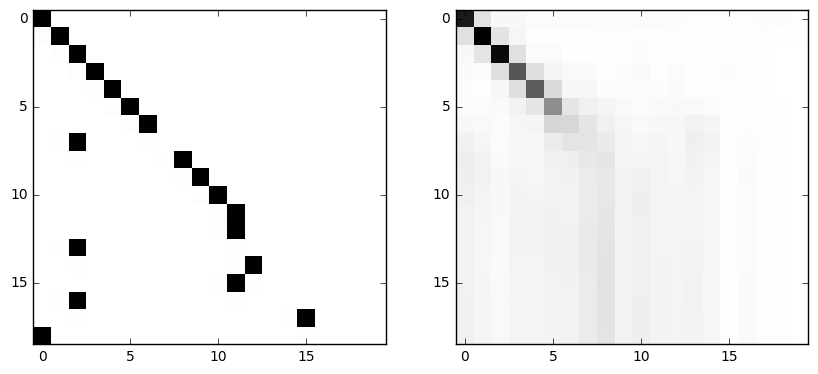

Epoch #300
    Loss: -0.0278030689806


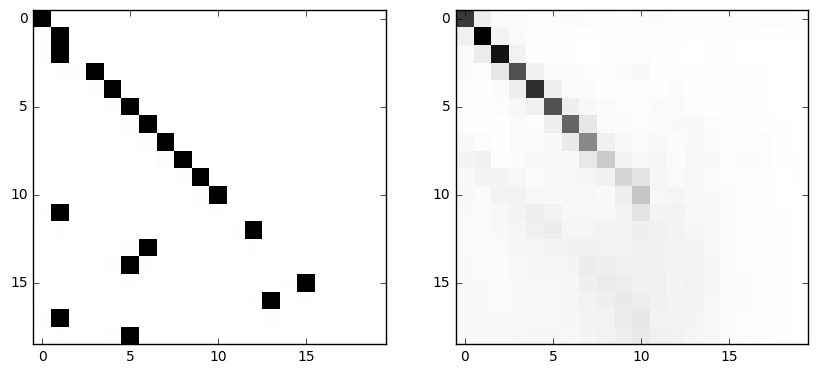

Epoch #400
    Loss: -0.0261379890144


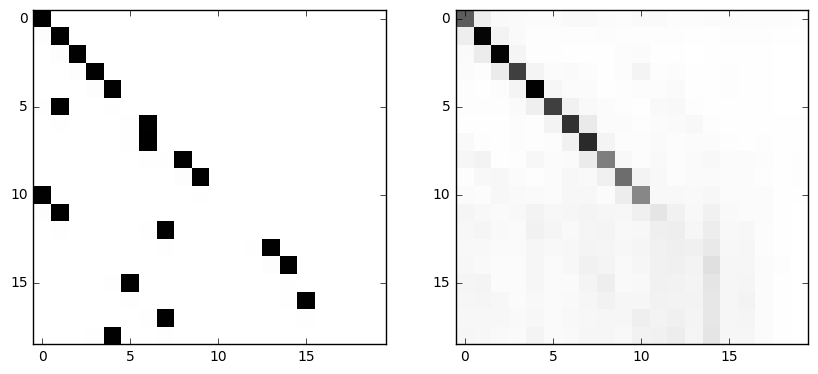

Epoch #500
    Loss: -0.0243284944445


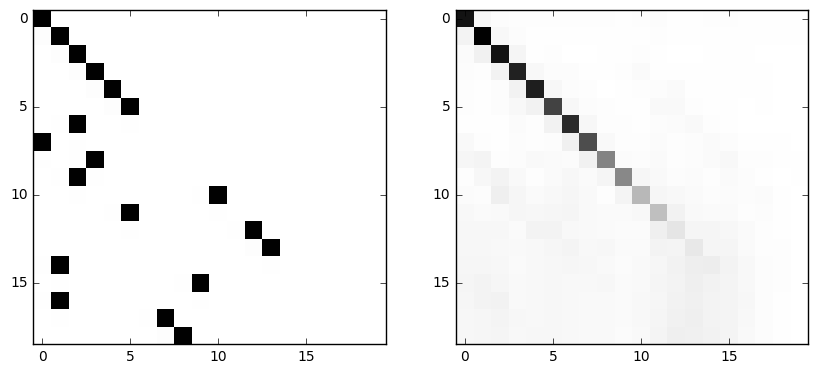

Epoch #600
    Loss: -0.0286942664534


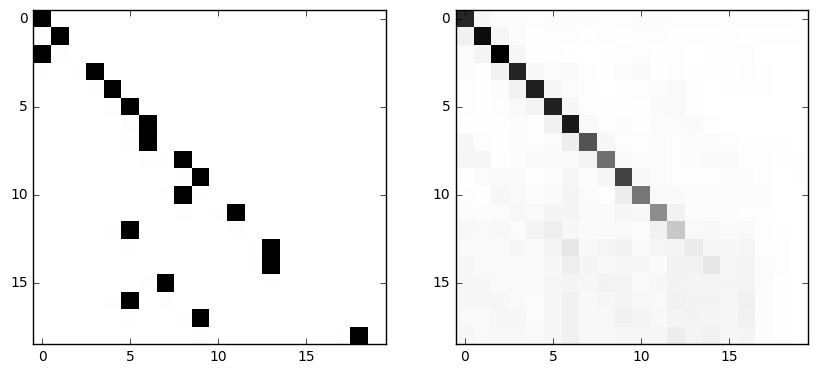

Epoch #700
    Loss: -0.0331403762102


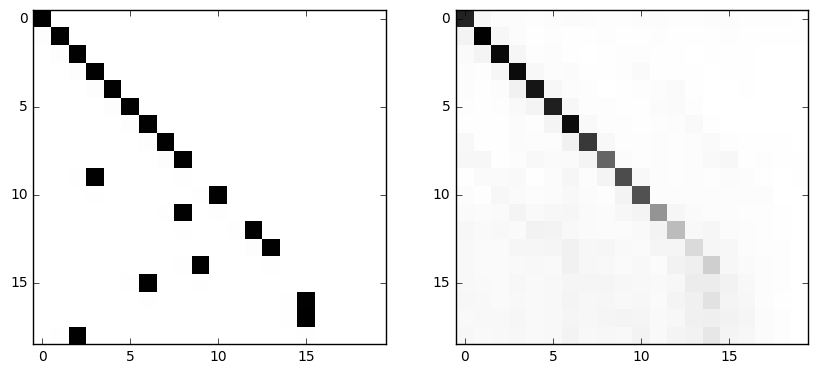

Epoch #800
    Loss: -0.028619909659


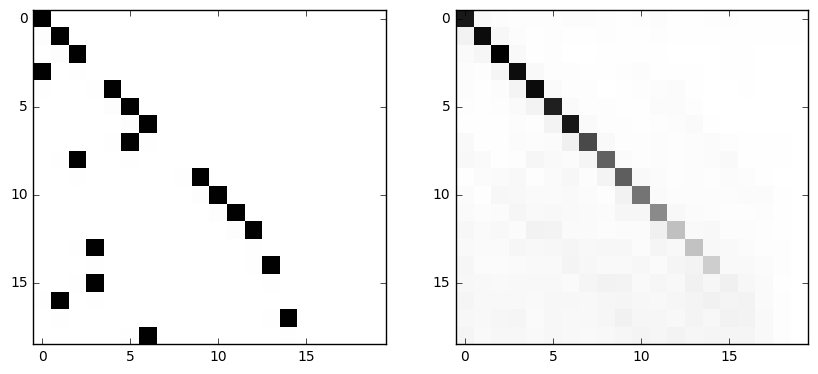

Epoch #900
    Loss: -0.0283173192292


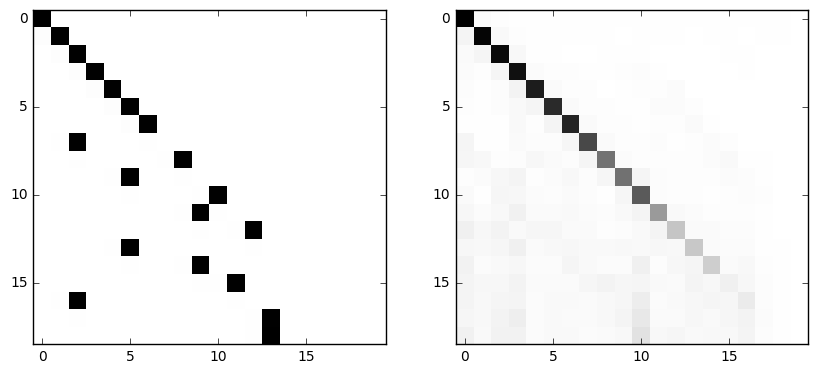

Epoch #1000
    Loss: -0.0269559379667


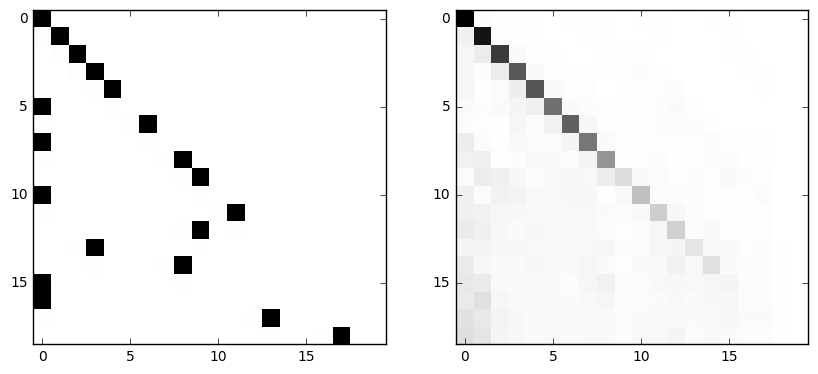

Epoch #1100
    Loss: -0.0256410688162


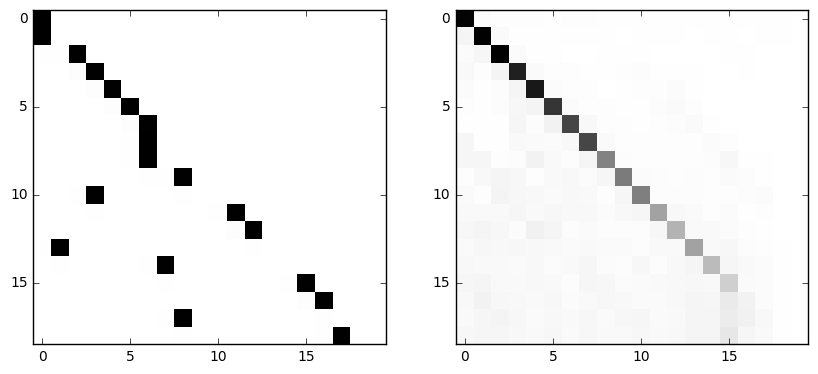

Epoch #1200
    Loss: -0.0375743620098


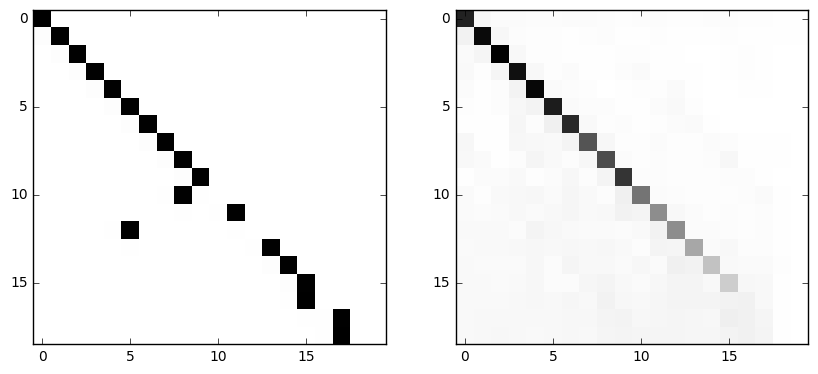

Epoch #1300
    Loss: -0.0265736673027


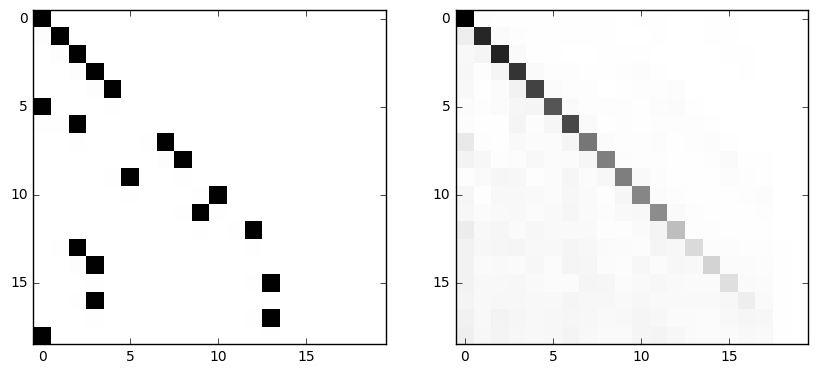

Epoch #1400
    Loss: -0.034393619746


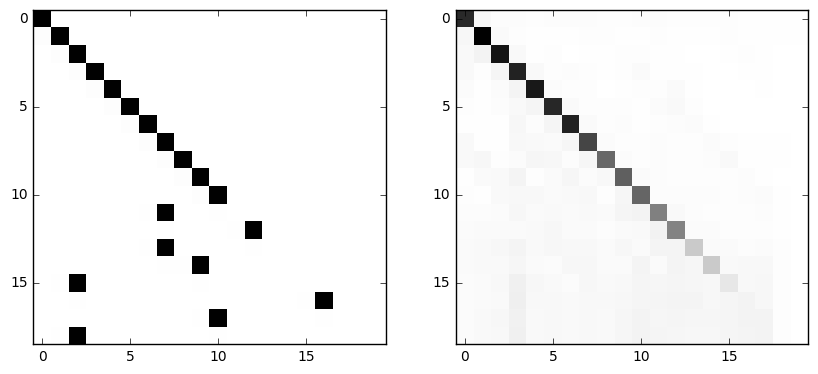

Epoch #1500
    Loss: -0.0270425453782


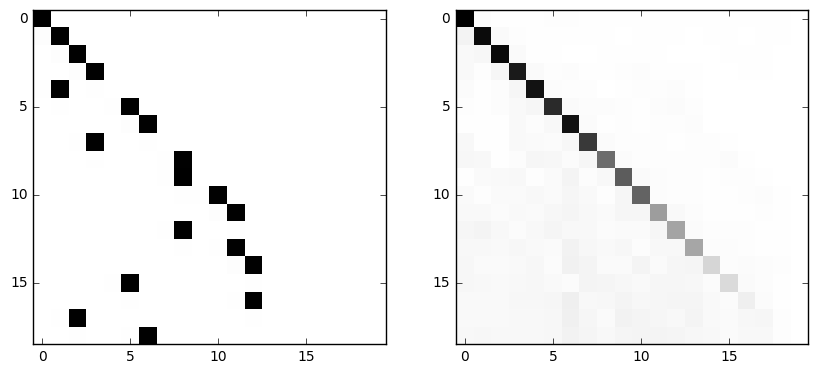

Epoch #1600
    Loss: -0.0221952255815


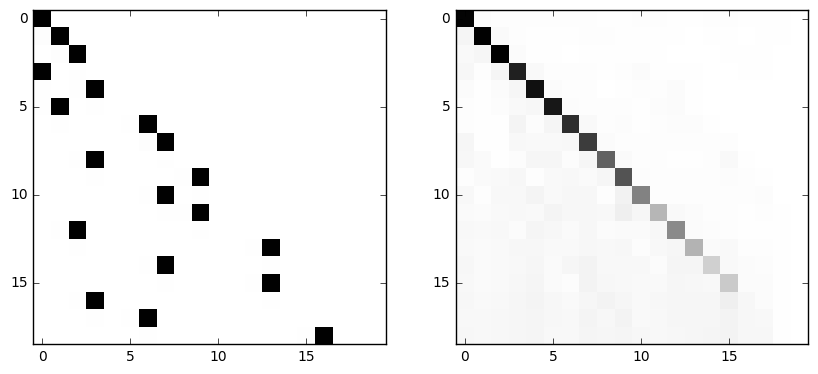

Epoch #1700
    Loss: -0.0246835593134


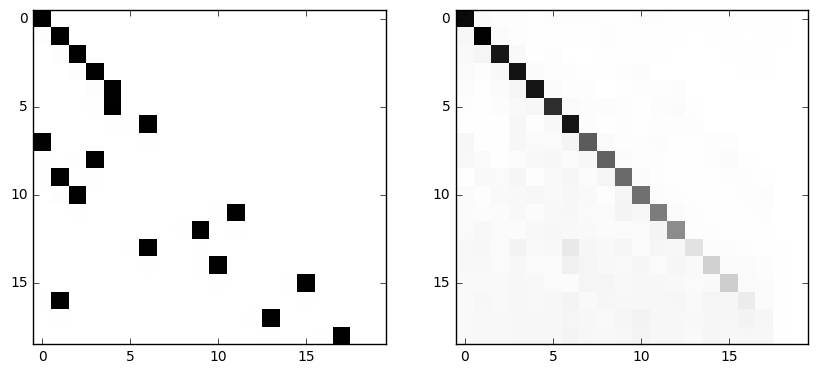

Epoch #1800
    Loss: -0.0246314760298


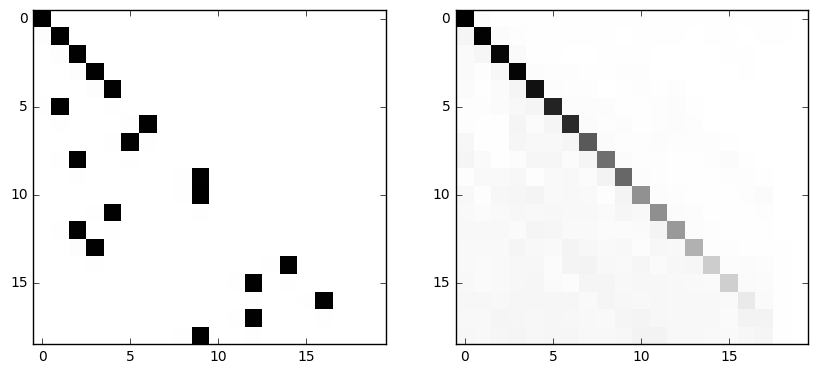

Epoch #1900
    Loss: -0.0271123275161


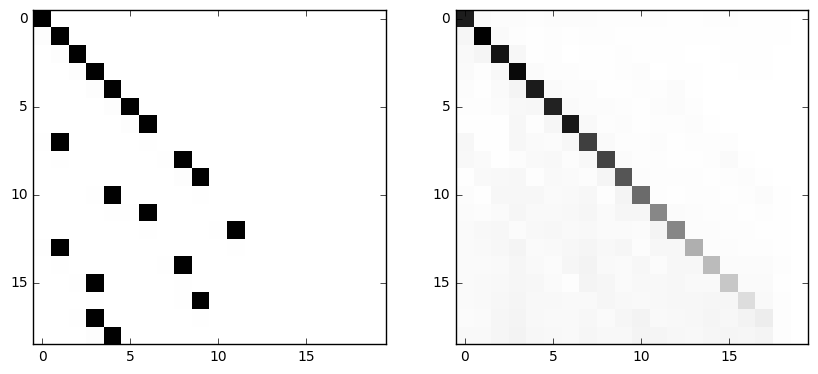

Epoch #2000
    Loss: -0.0367195084691


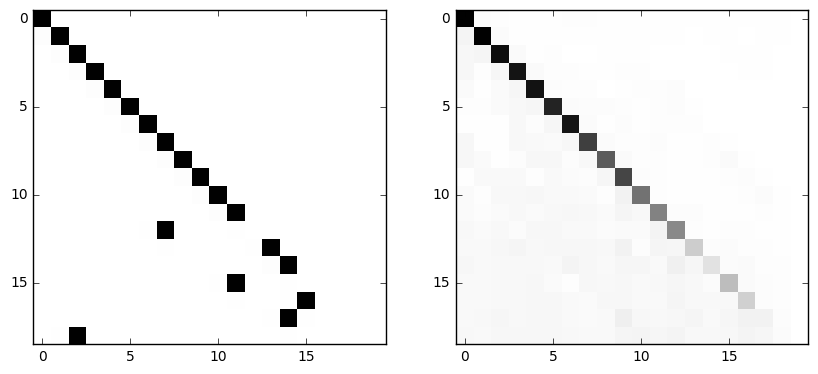

Epoch #2100
    Loss: -0.0331771671772


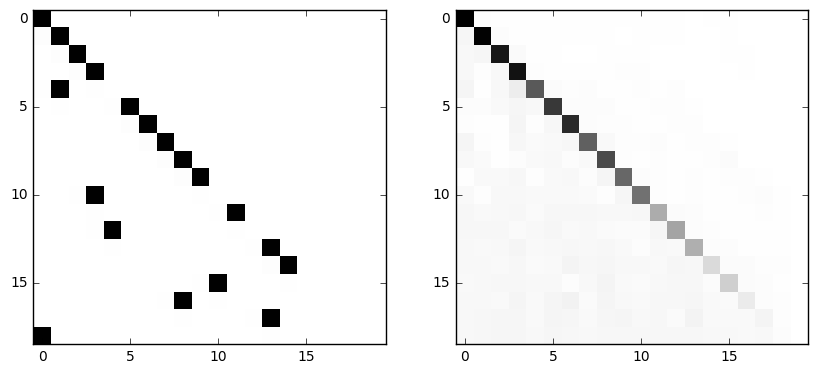

Epoch #2200
    Loss: -0.0211504586041


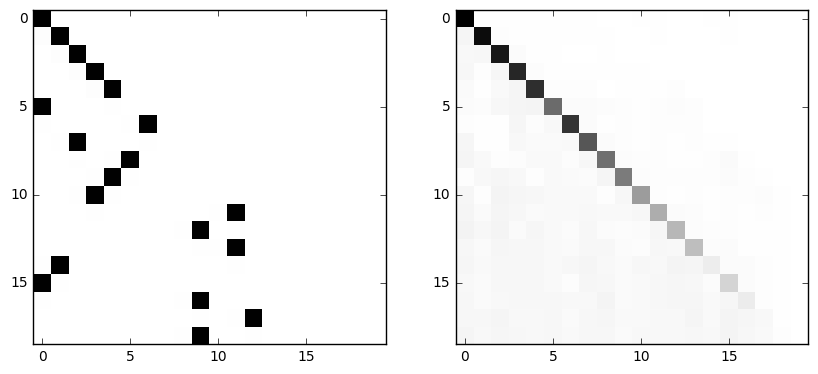

Epoch #2300
    Loss: -0.0328056514263


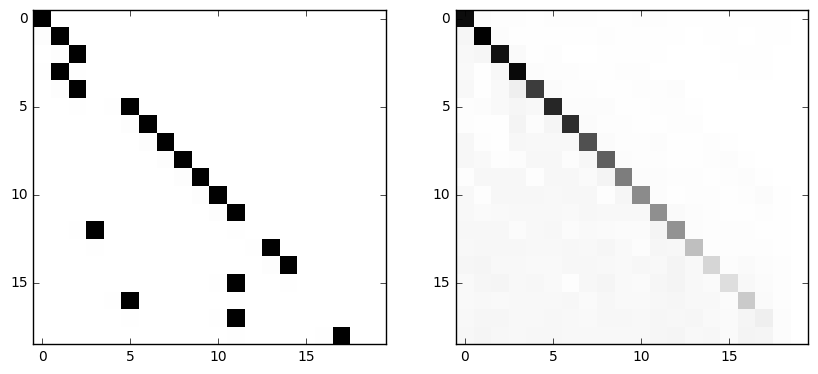

Epoch #2400
    Loss: -0.0263980720192


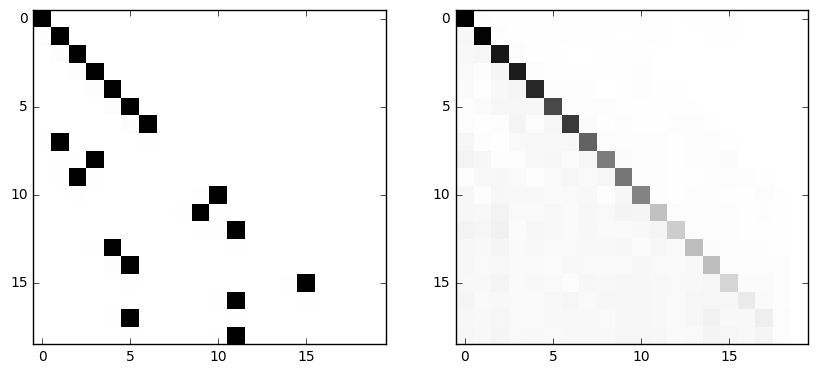

Epoch #2500
    Loss: -0.0280192438513


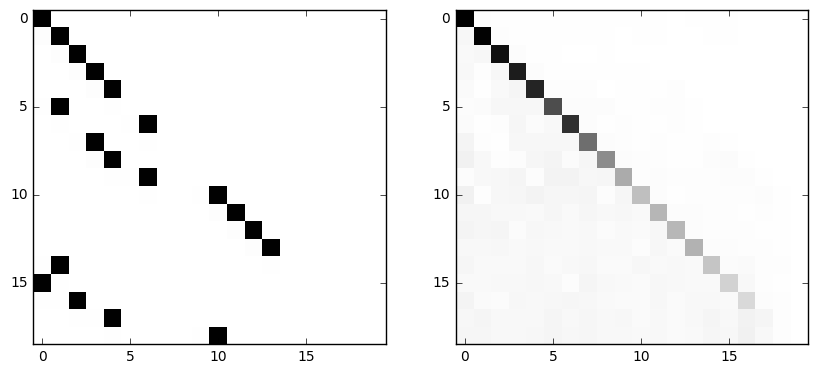

Epoch #2600
    Loss: -0.0258223842829


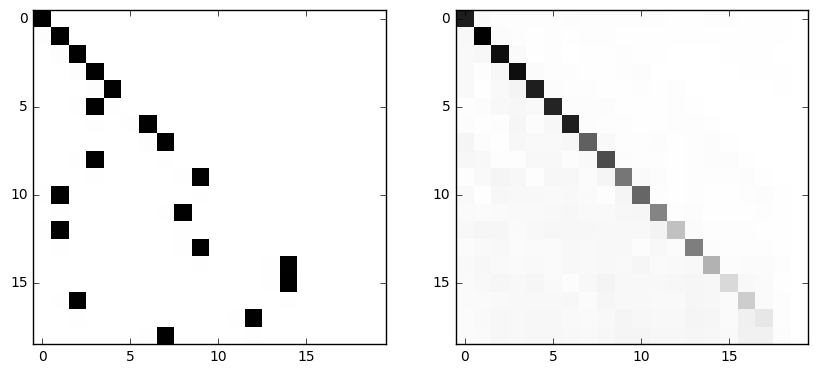

Epoch #2700
    Loss: -0.0380601771176


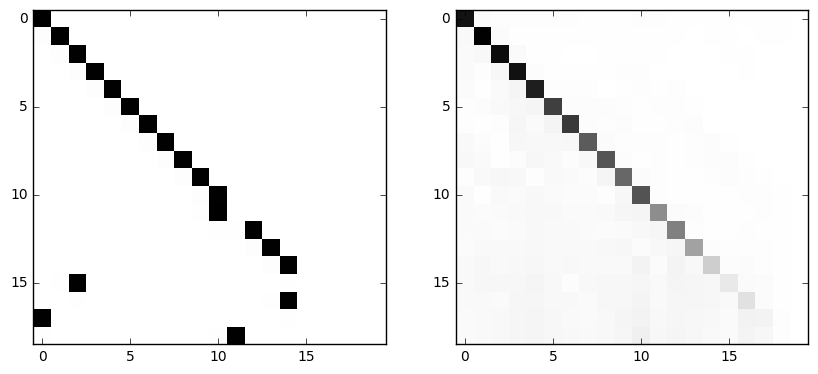

Epoch #2800
    Loss: -0.028580904007


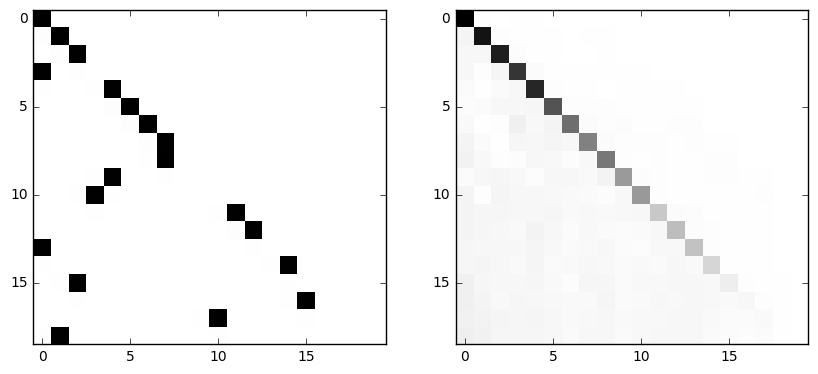

Epoch #2900
    Loss: -0.0286215860397


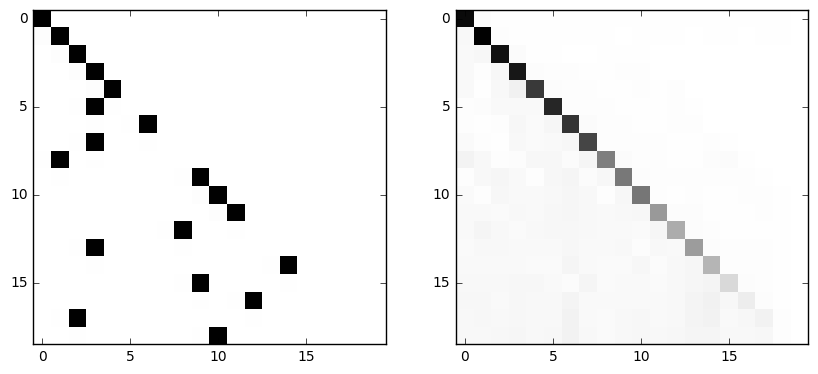

Epoch #3000
    Loss: -0.0282904040068


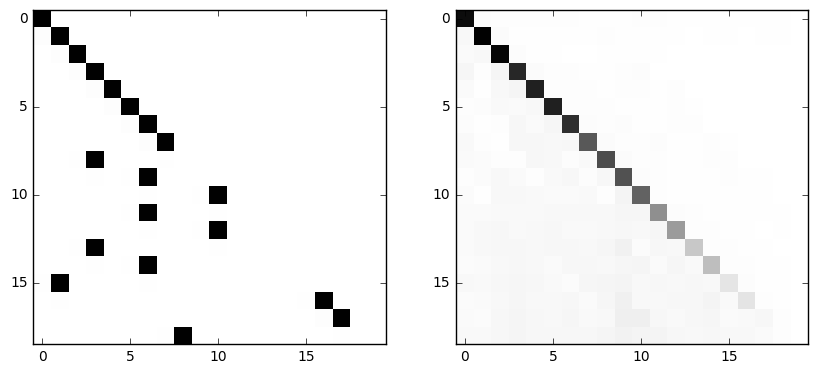

Epoch #3100
    Loss: -0.0318909883499


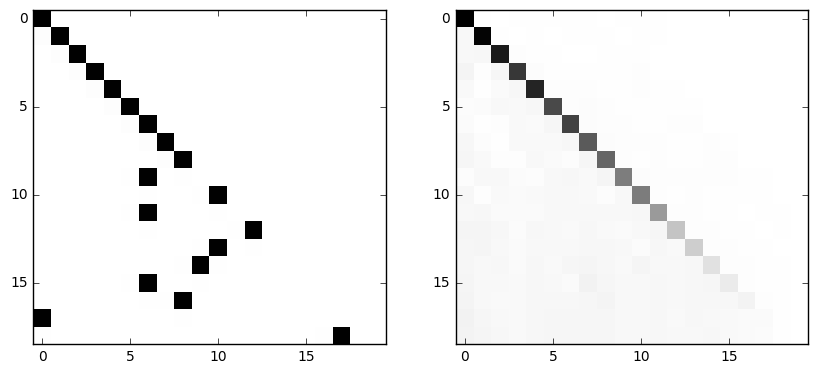

Epoch #3200
    Loss: -0.0283696465194


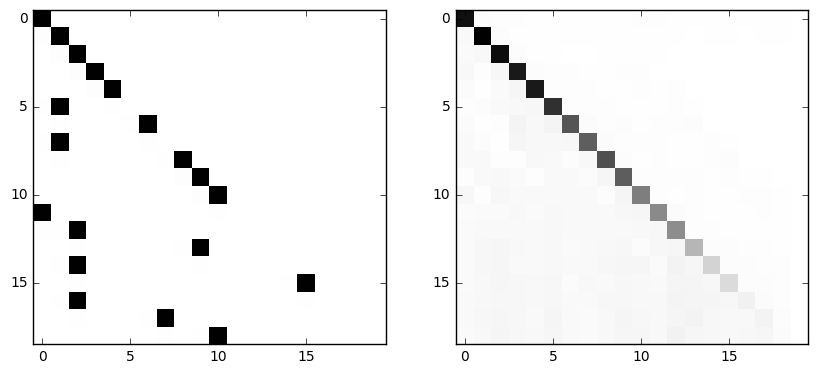

Epoch #3300
    Loss: -0.0285881385207


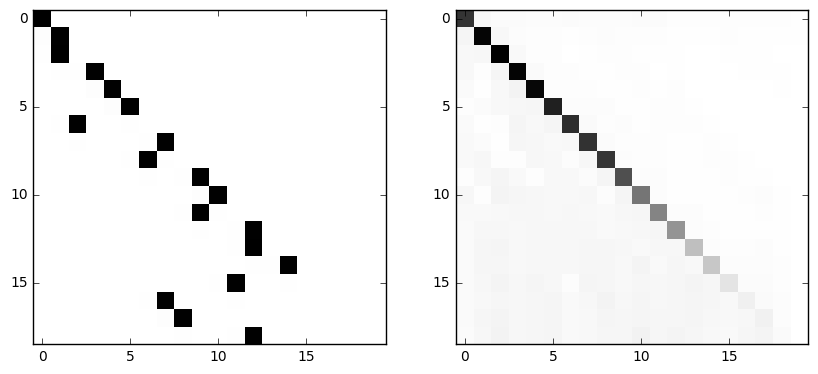

Epoch #3400
    Loss: -0.0294495820999


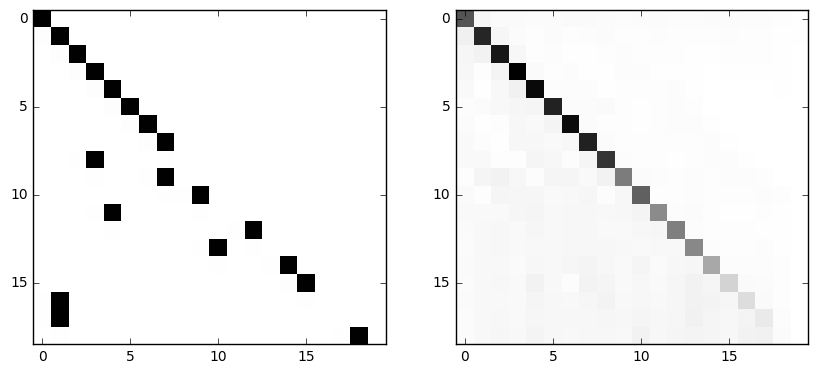

Epoch #3500
    Loss: -0.0322829186916


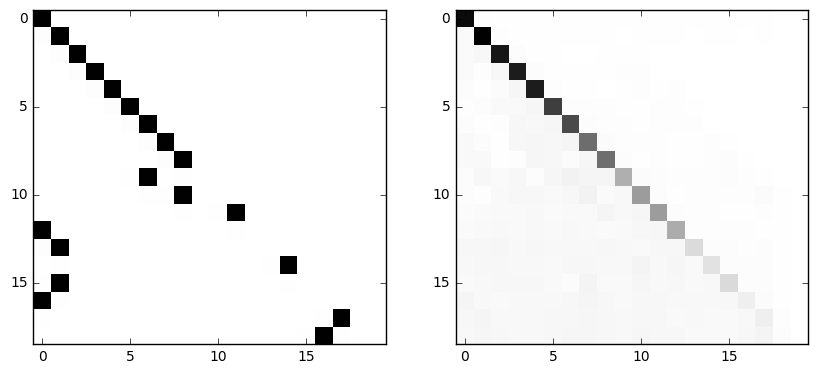

Epoch #3600
    Loss: -0.0260184537619


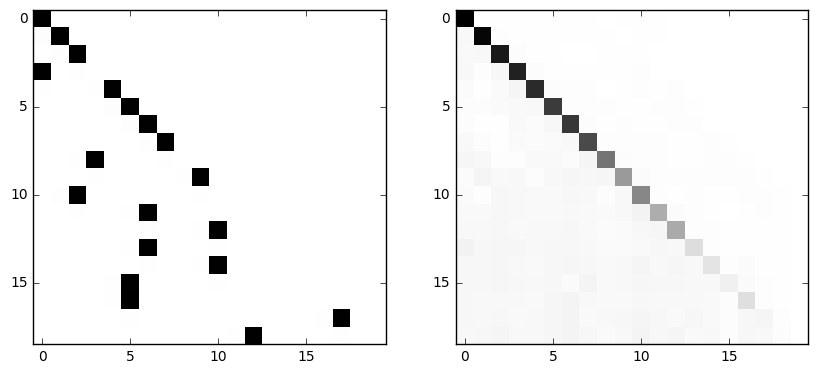

Epoch #3700
    Loss: -0.0288985092193


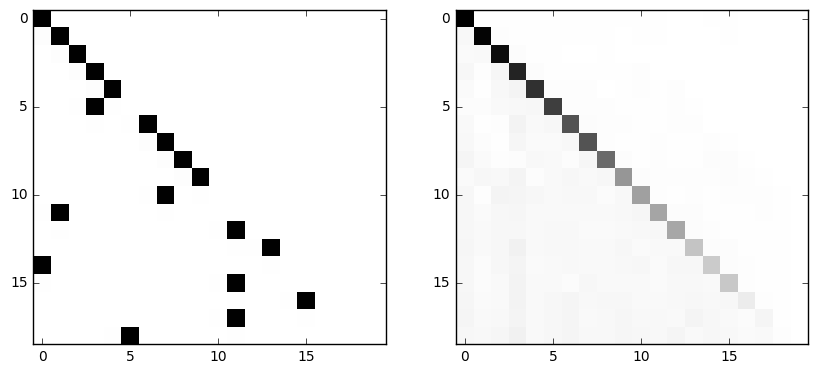

Epoch #3800
    Loss: -0.0261806342751


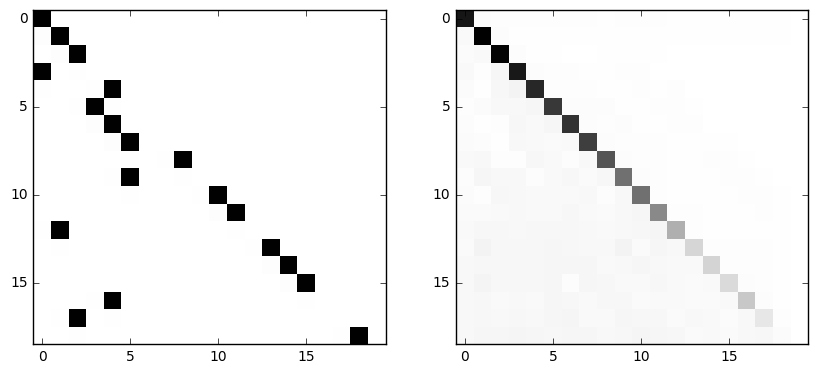

Epoch #3900
    Loss: -0.0288942586631


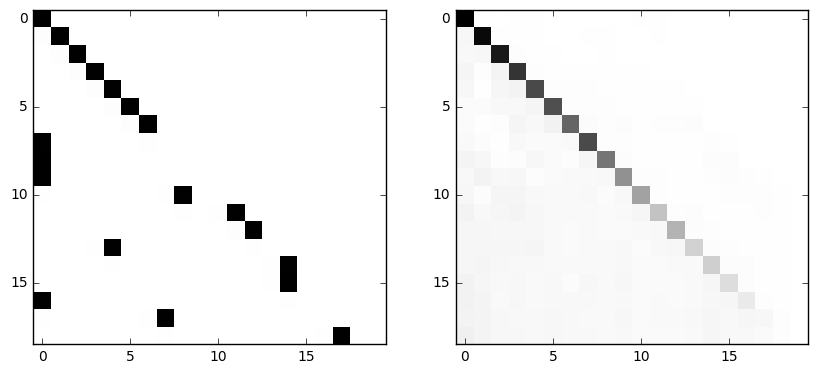

Epoch #4000
    Loss: -0.022623186931


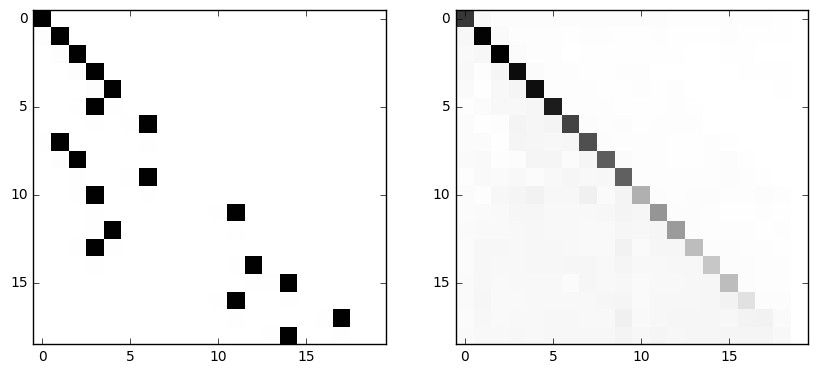

Epoch #4100
    Loss: -0.0289185959846


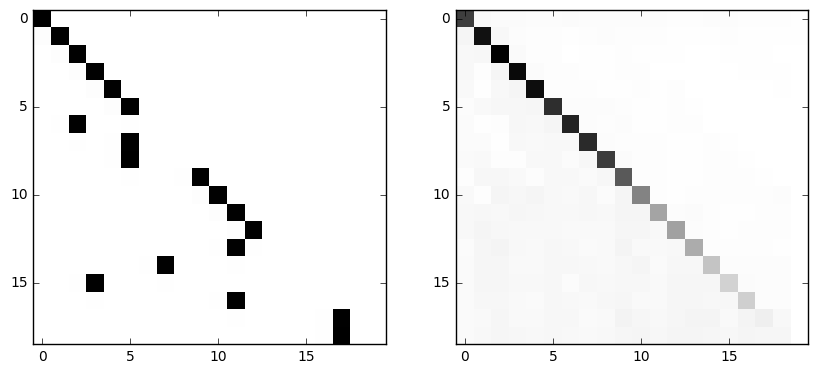

Epoch #4200
    Loss: -0.0289940331131


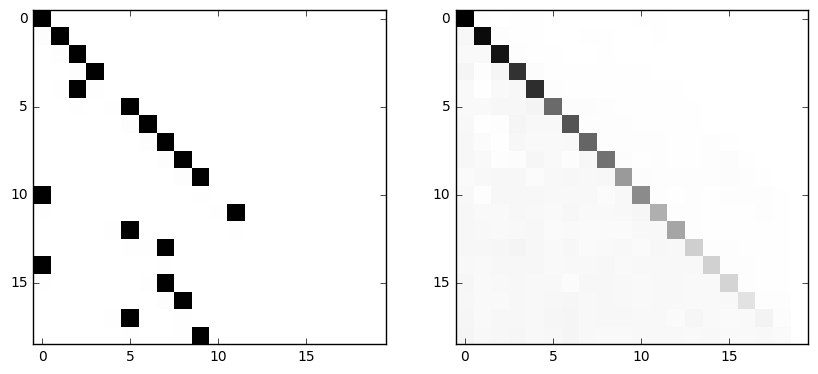

Epoch #4300
    Loss: -0.0280410926789


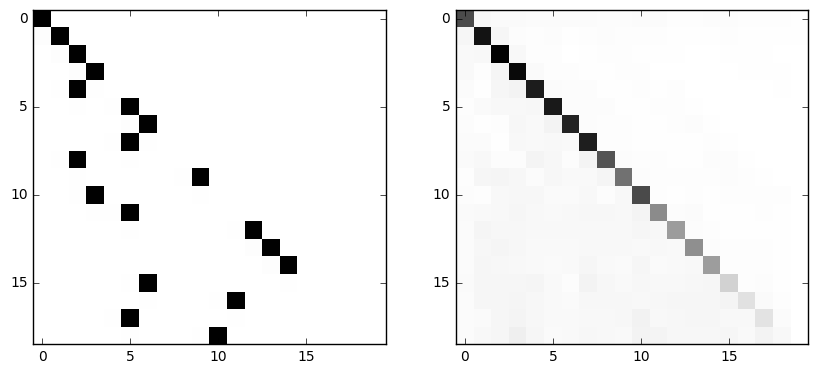

Epoch #4400
    Loss: -0.0230196323246


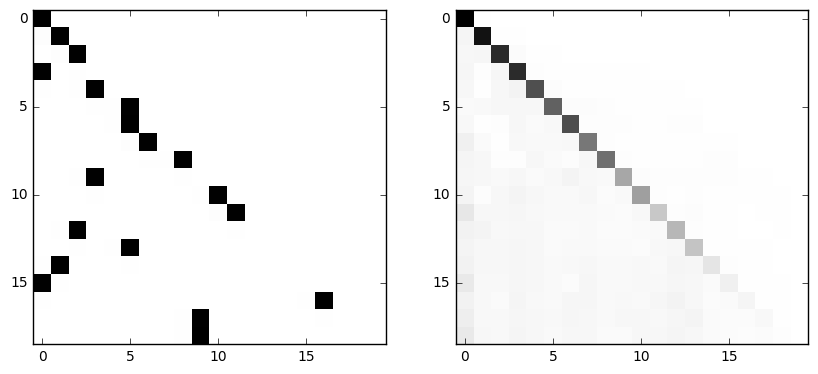

Epoch #4500
    Loss: -0.0349487364292


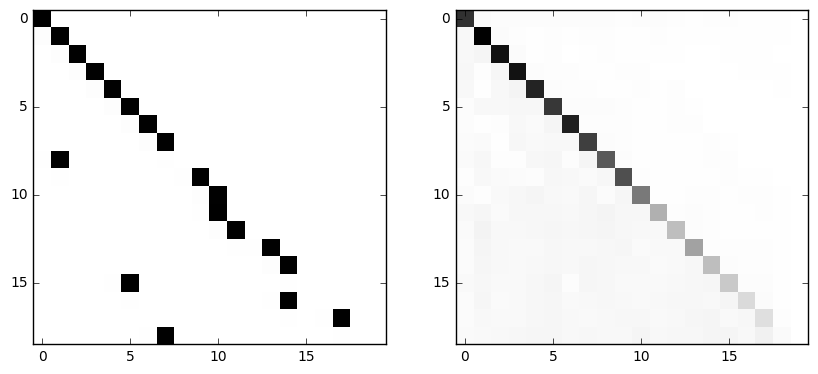

Epoch #4600
    Loss: -0.028701769188


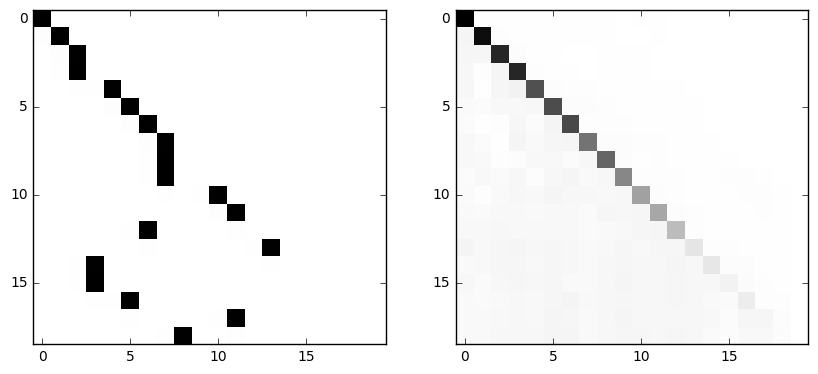

Epoch #4700
    Loss: -0.0298865493387


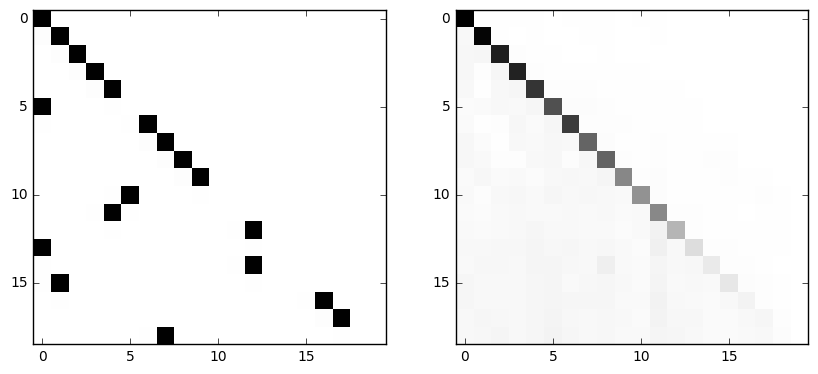

Epoch #4800
    Loss: -0.0345795042813


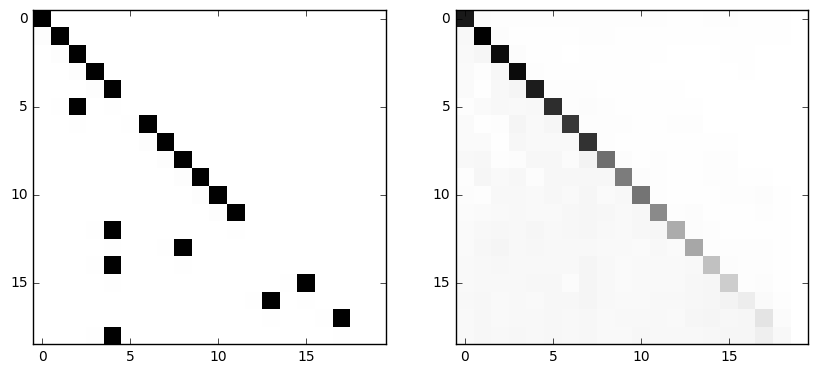

Epoch #4900
    Loss: -0.0326331816614


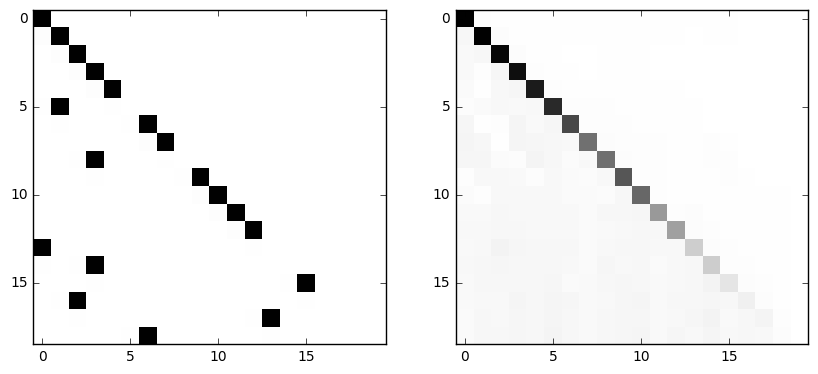

Epoch #5000
    Loss: -0.0326616503298


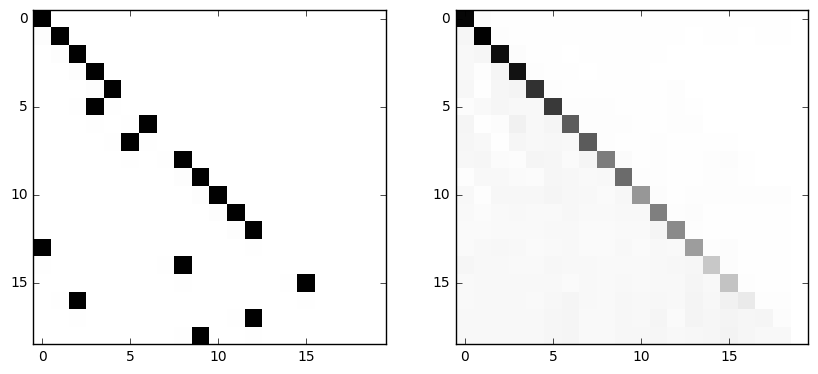

Epoch #5100
    Loss: -0.02531404607


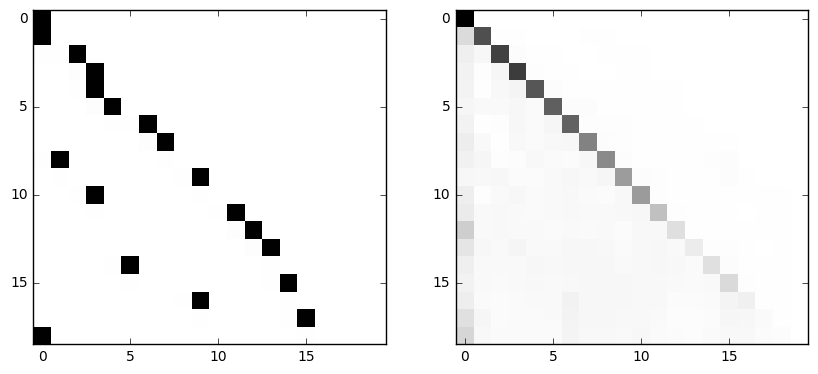

Epoch #5200
    Loss: -0.0216269064695


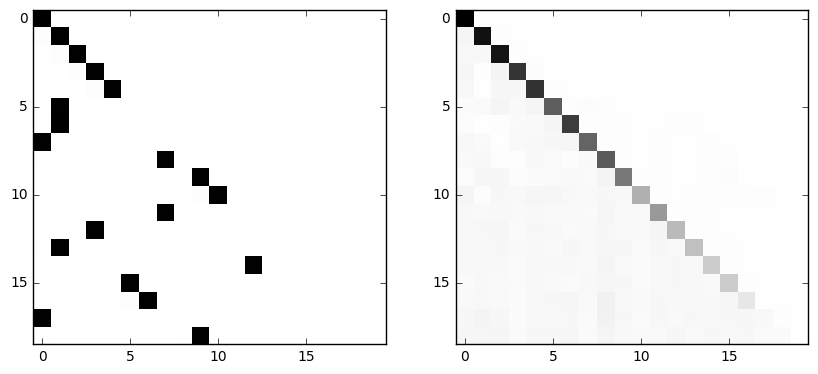

Epoch #5300
    Loss: -0.0281154923141


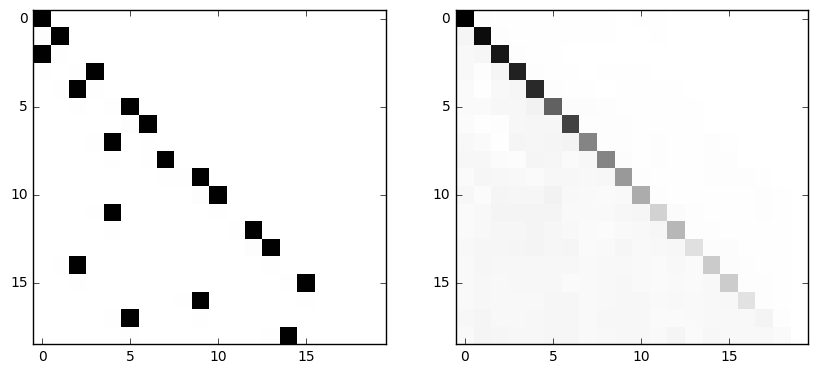

Epoch #5400
    Loss: -0.0256173890084


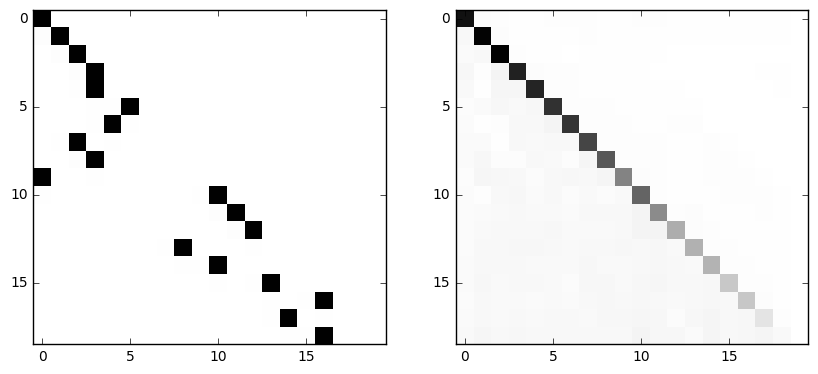

Epoch #5500
    Loss: -0.0268831346184


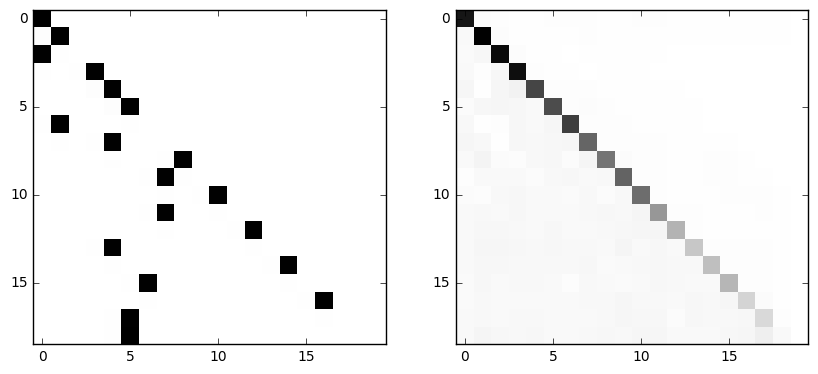

Epoch #5600
    Loss: -0.0291688982397


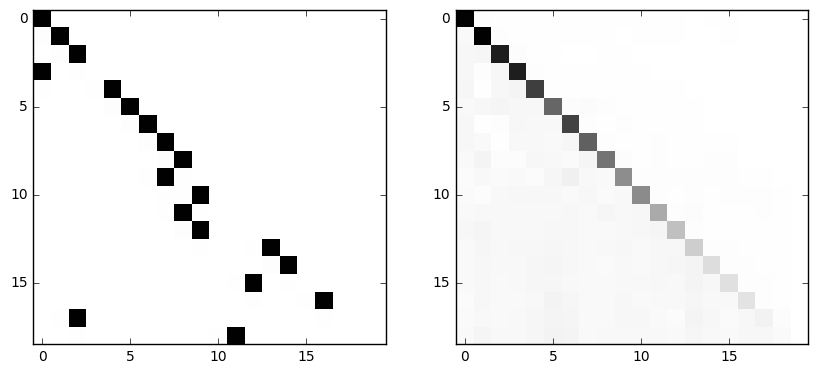

Epoch #5700
    Loss: -0.030394397676


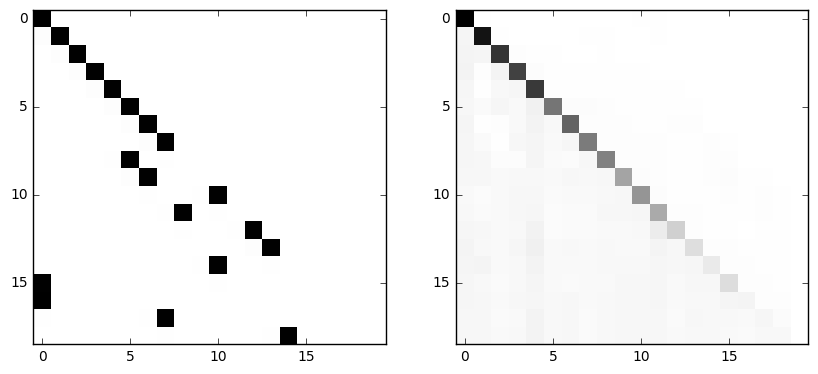

Epoch #5800
    Loss: -0.0328926630318


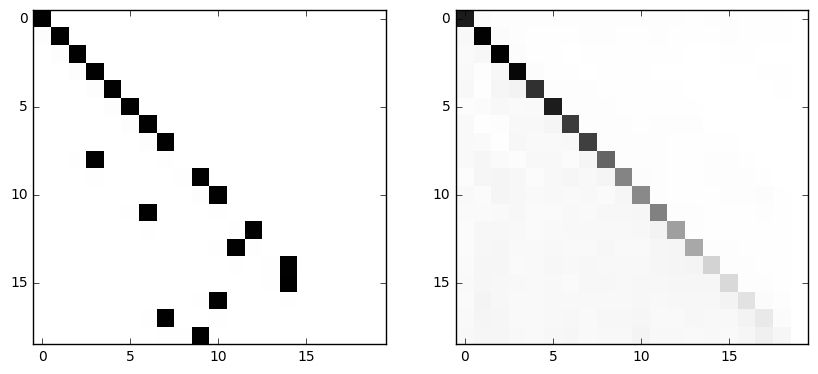

Epoch #5900
    Loss: -0.0327637754381


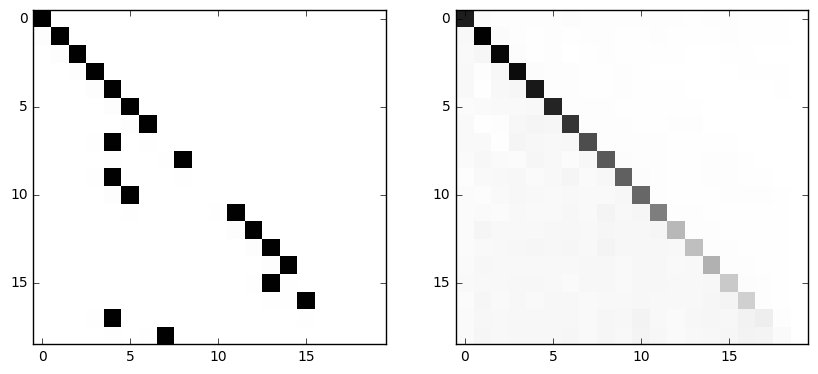

Epoch #6000
    Loss: -0.0311195813119


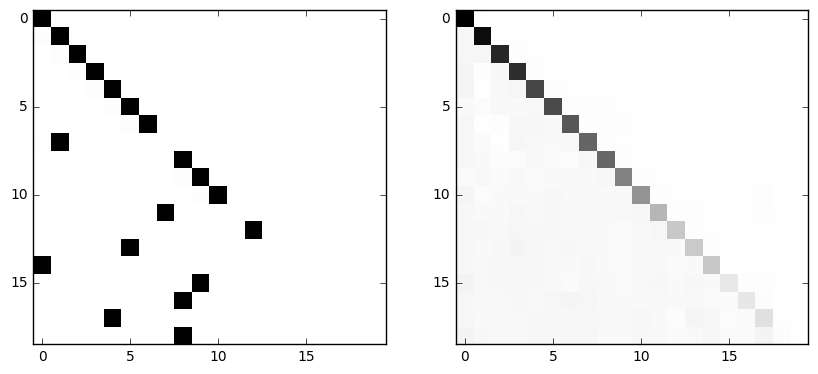

Epoch #6100
    Loss: -0.0234624259174


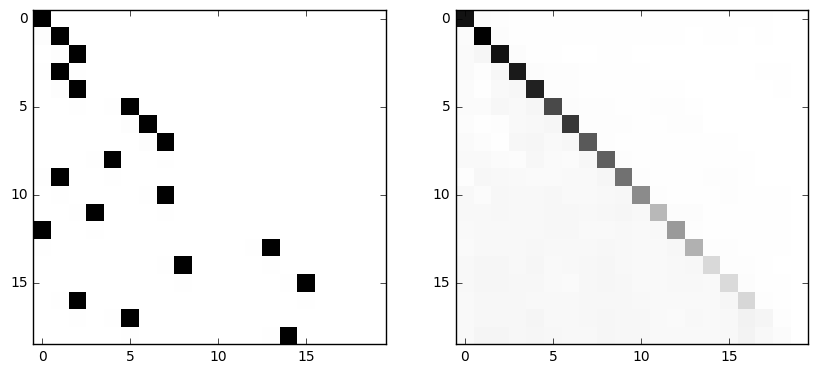

Epoch #6200
    Loss: -0.0231617148966


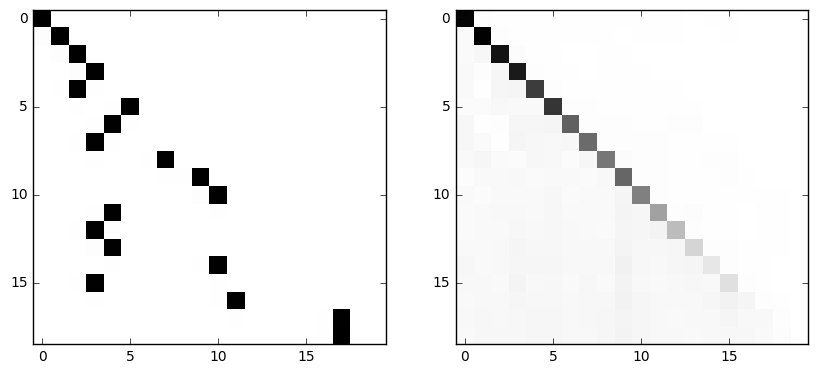

Epoch #6300
    Loss: -0.0325139649212


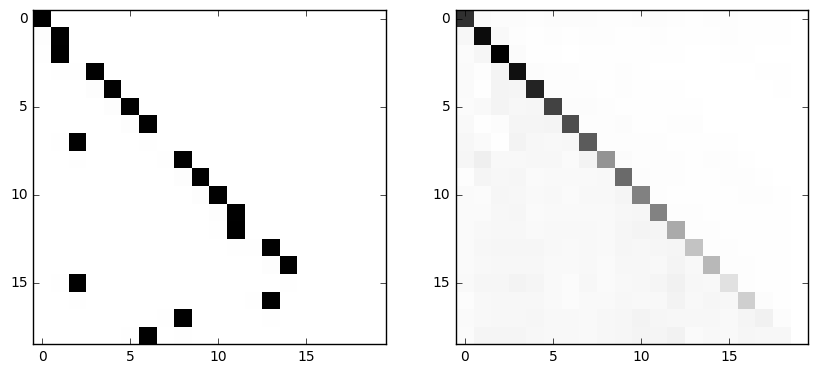

Epoch #6400
    Loss: -0.0340269617736


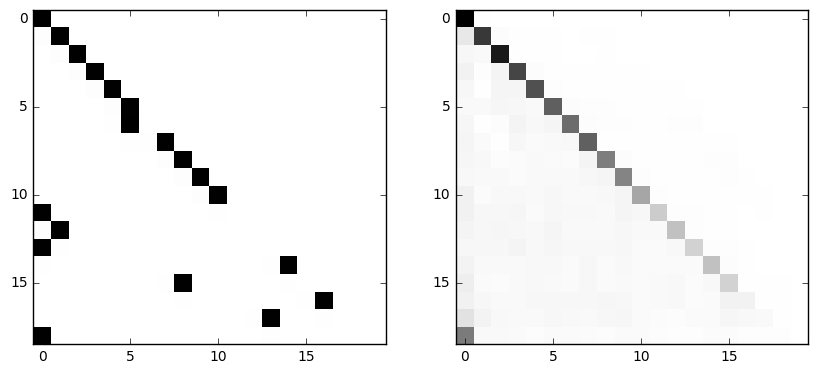

Epoch #6500
    Loss: -0.0286622233689


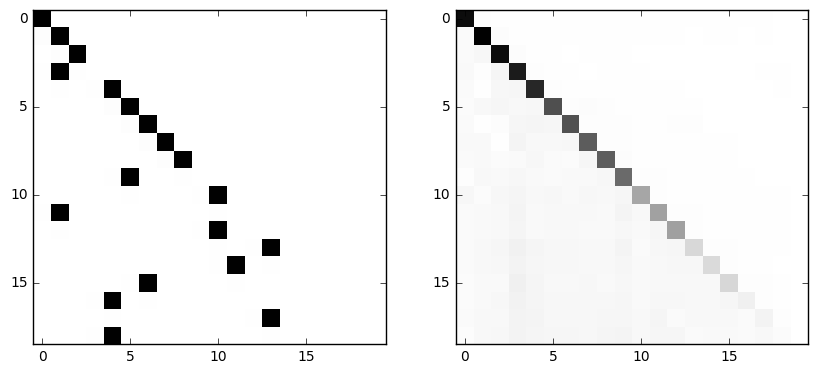

Epoch #6600
    Loss: -0.0297026094049


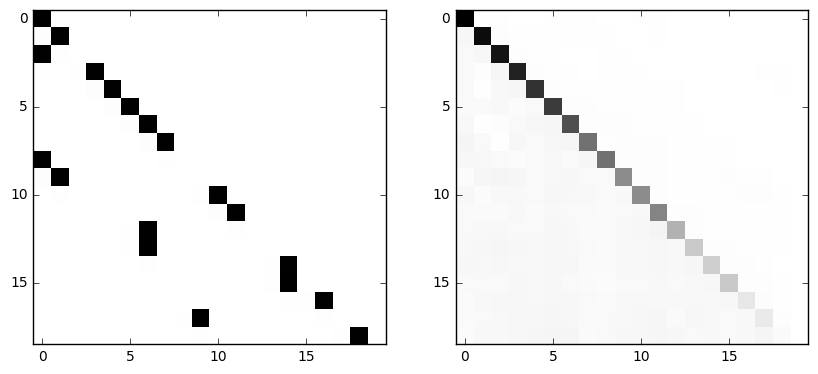

Epoch #6700
    Loss: -0.0290620867163


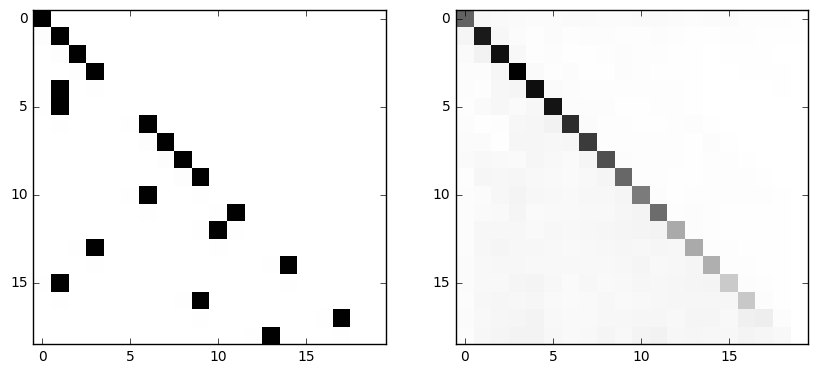

Epoch #6800
    Loss: -0.0212637335062


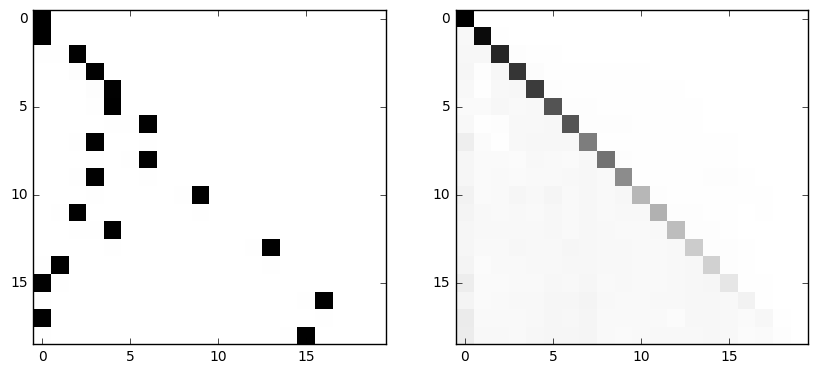

Epoch #6900
    Loss: -0.0311938021332


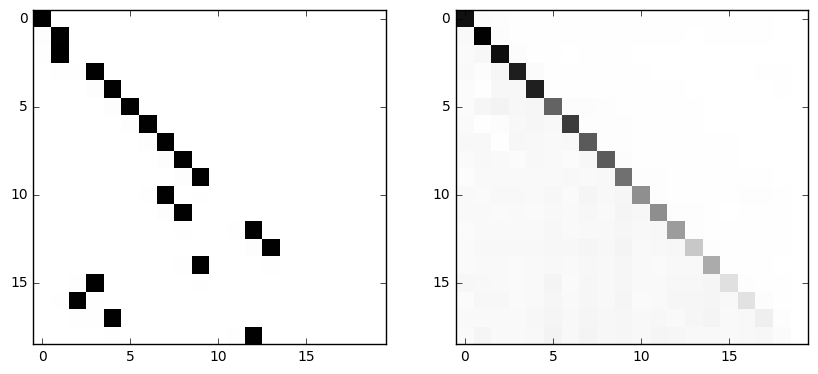

Epoch #7000
    Loss: -0.0270351227373


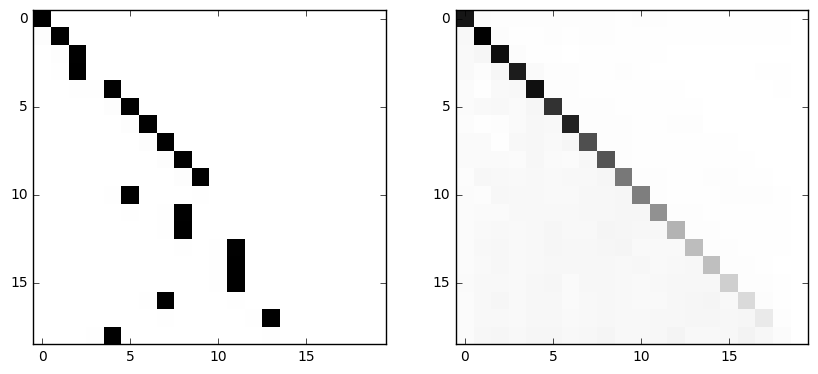

Epoch #7100
    Loss: -0.0292471647263


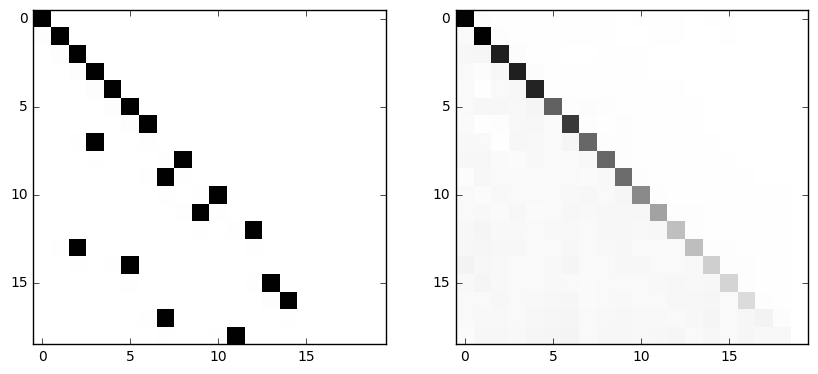

Epoch #7200
    Loss: -0.0260645002127


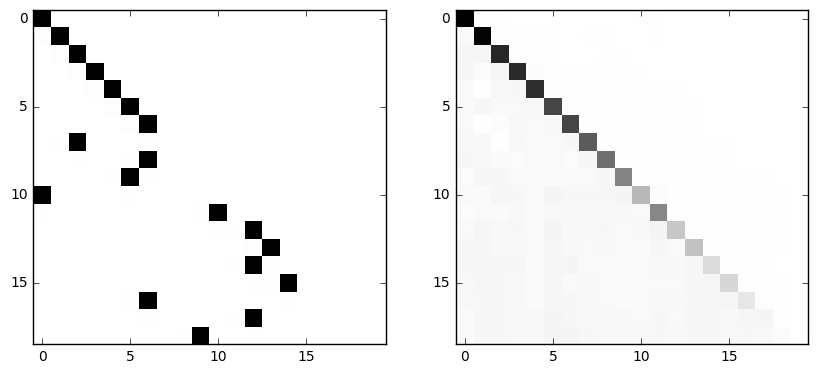

Epoch #7300
    Loss: -0.0313413366675


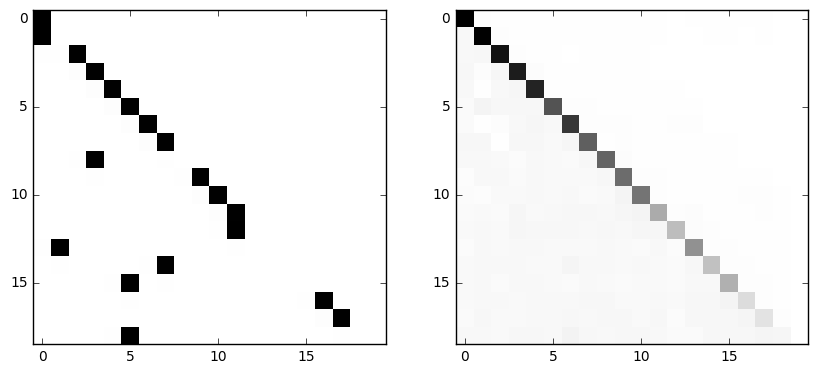

Epoch #7400
    Loss: -0.0202753897756


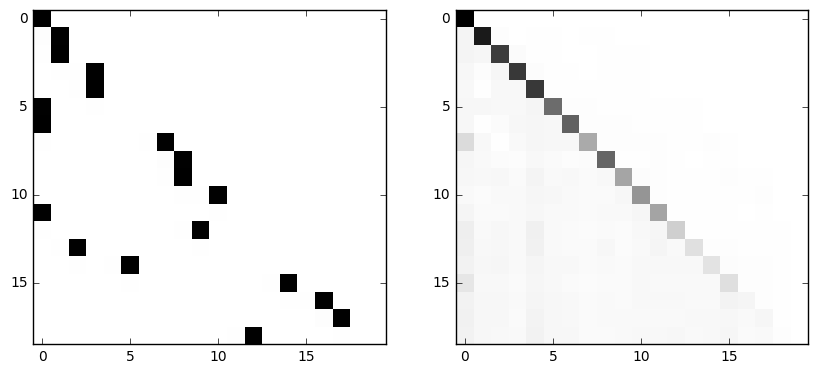

Epoch #7500
    Loss: -0.0333586893976


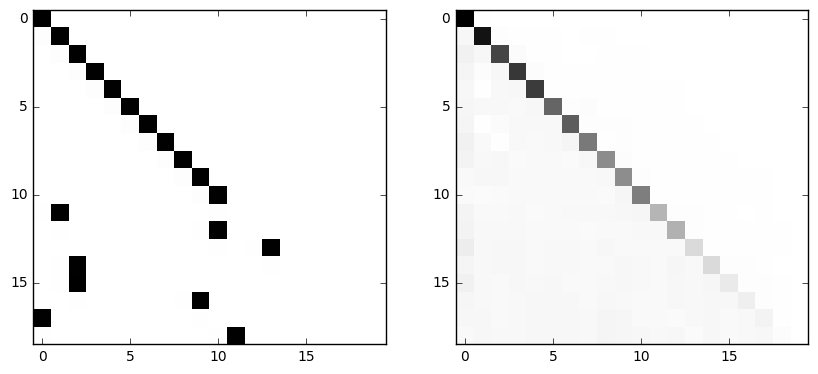

Epoch #7600
    Loss: -0.0320826992393


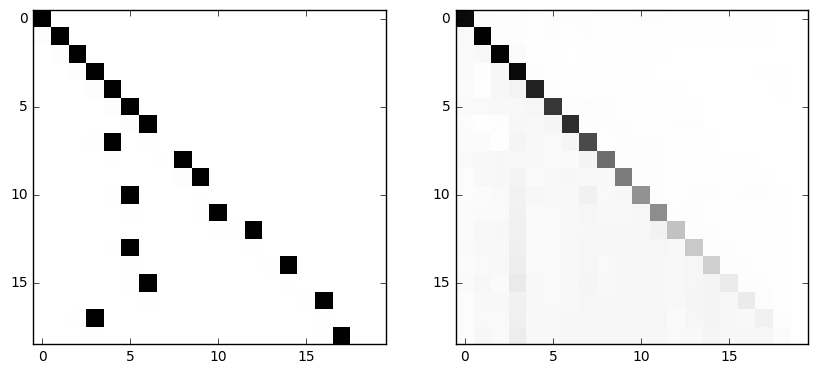

Epoch #7700
    Loss: -0.0264127478004


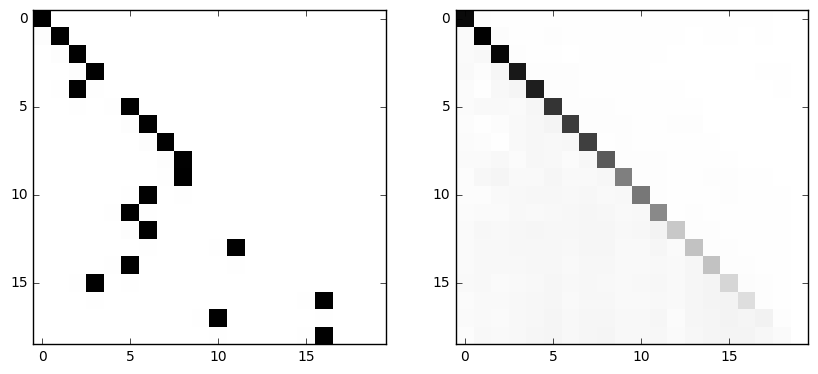

Epoch #7800
    Loss: -0.0382981337607


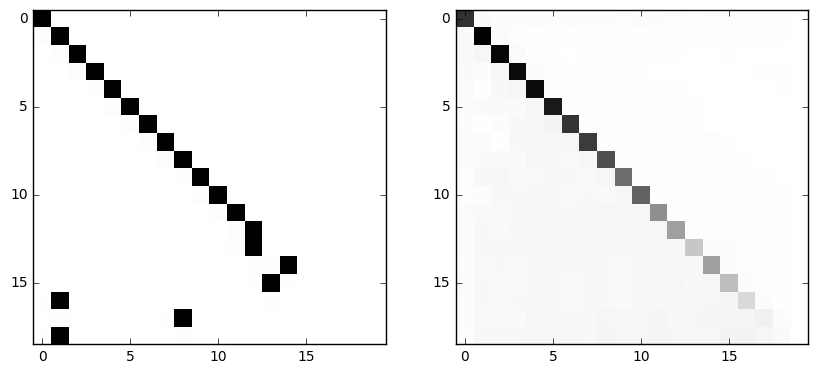

Epoch #7900
    Loss: -0.0291480571032


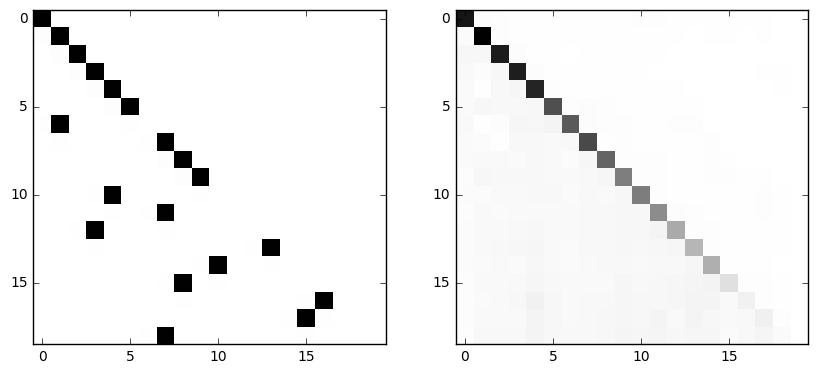

Epoch #8000
    Loss: -0.0209607407451


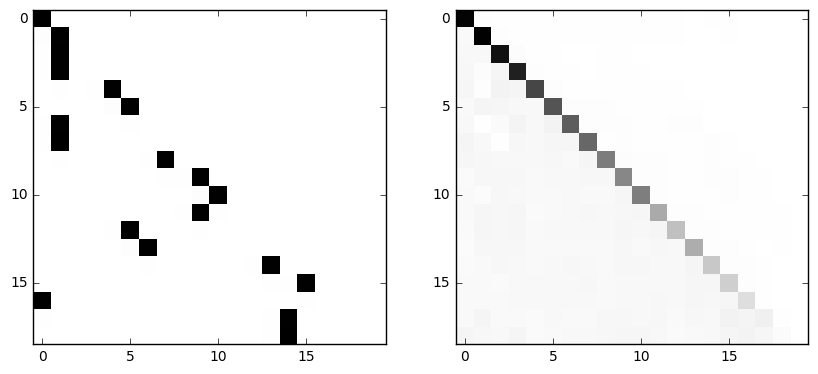

Epoch #8100
    Loss: -0.0262831803411


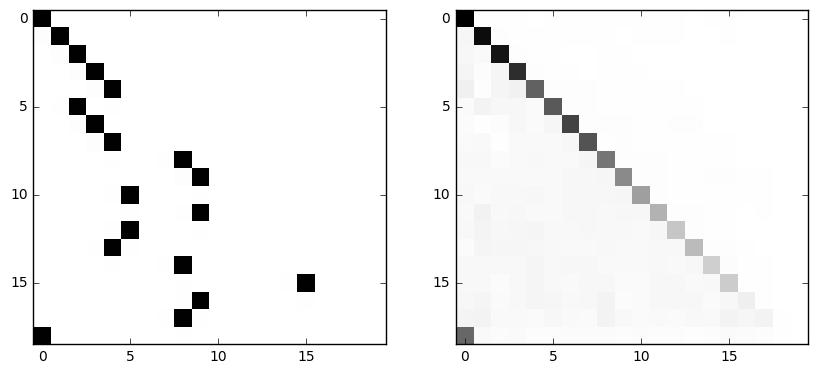

Epoch #8200
    Loss: -0.0330789275467


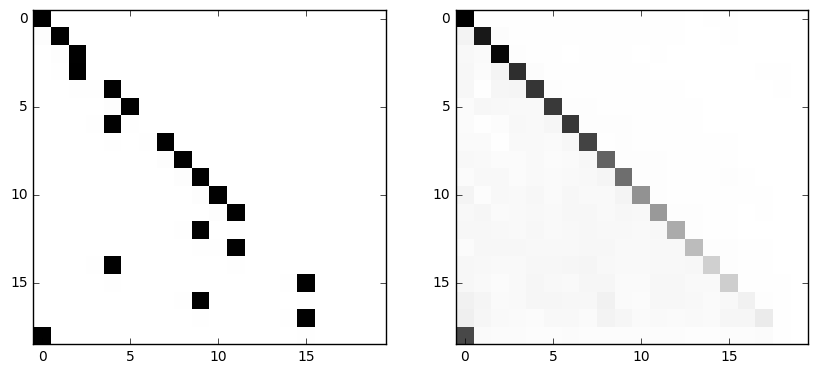

Epoch #8300
    Loss: -0.0235070101917


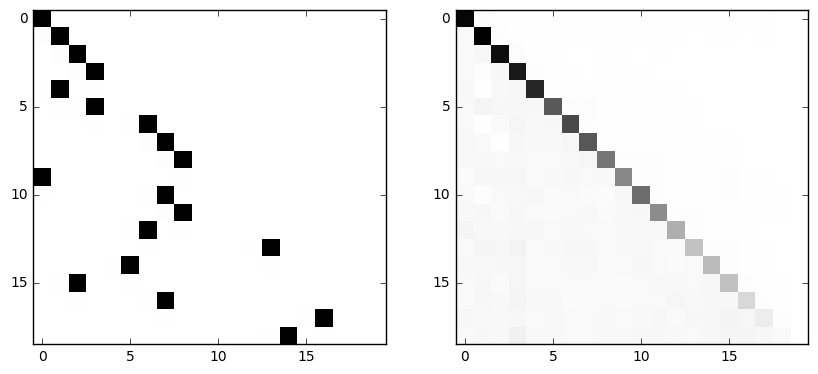

Epoch #8400
    Loss: -0.0258781369776


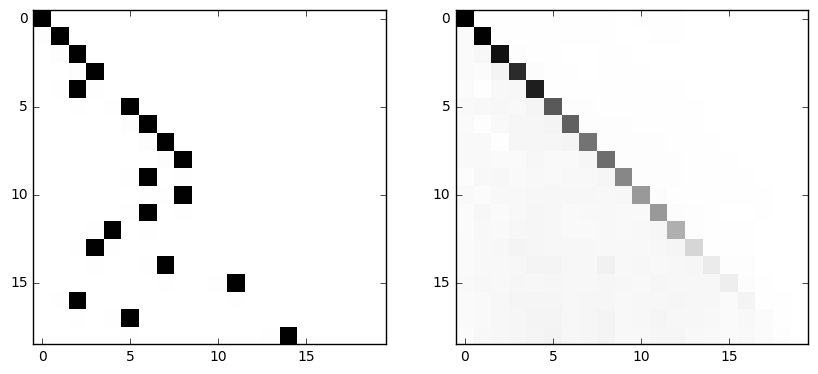

Epoch #8500
    Loss: -0.0245763156563


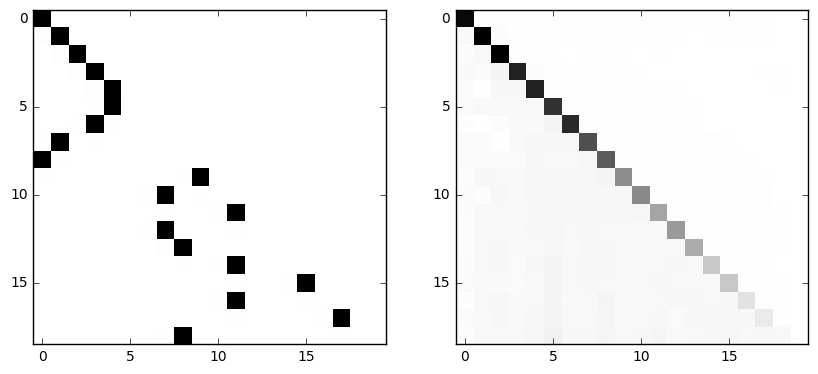

Epoch #8600
    Loss: -0.0324430167675


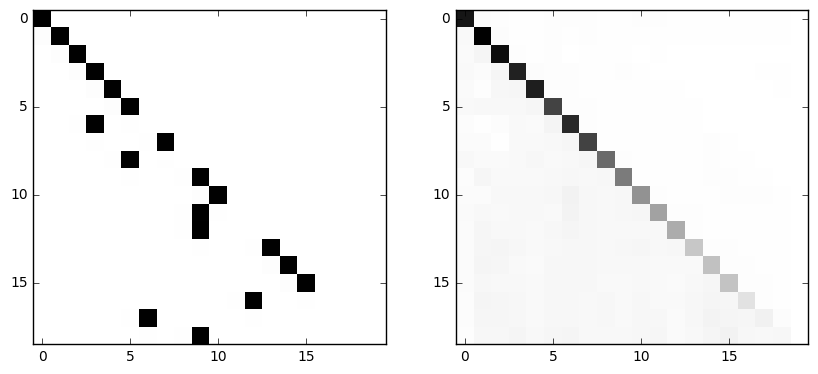

Epoch #8700
    Loss: -0.0299633648247


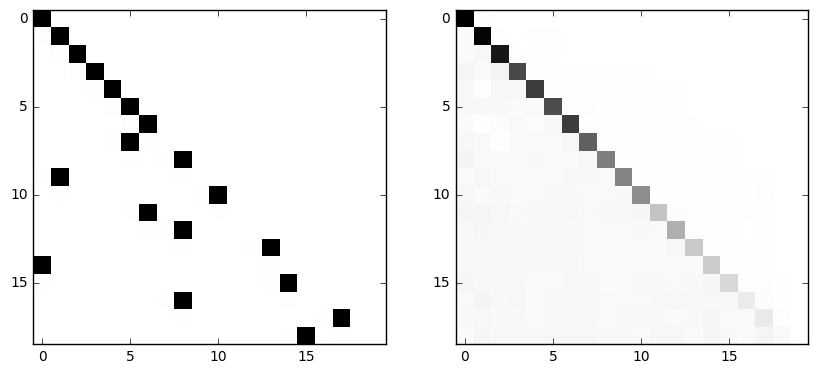

Epoch #8800
    Loss: -0.0282398462296


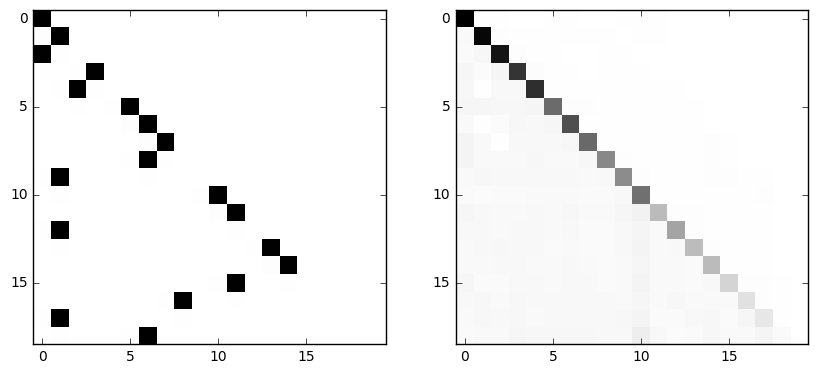

Epoch #8900
    Loss: -0.0322983562946


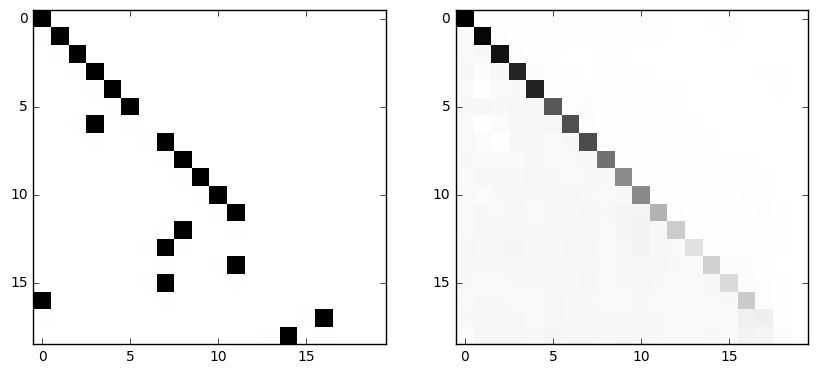

Epoch #9000
    Loss: -0.026647599414


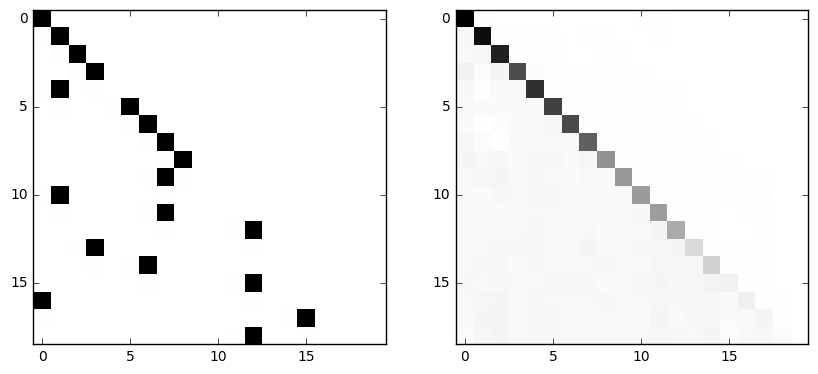

Epoch #9100
    Loss: -0.0279546882957


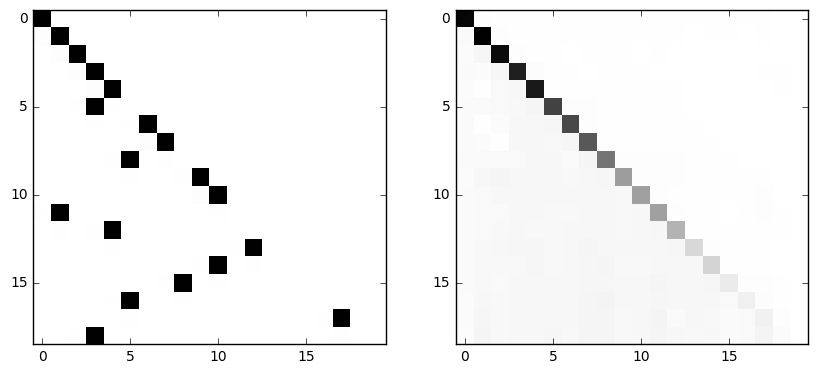

Epoch #9200
    Loss: -0.0327738858759


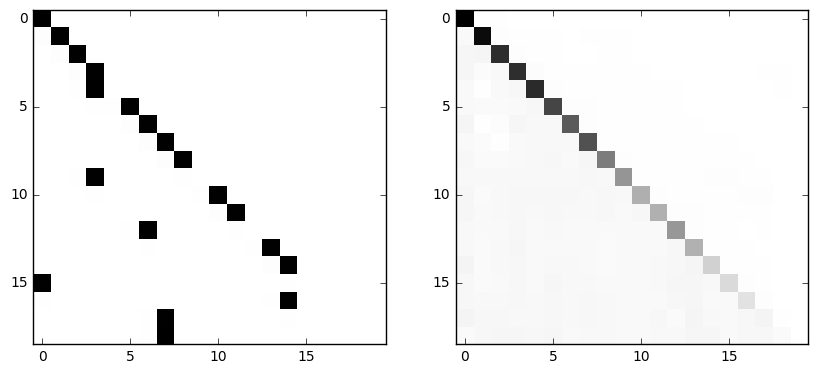

Epoch #9300
    Loss: -0.0254317056388


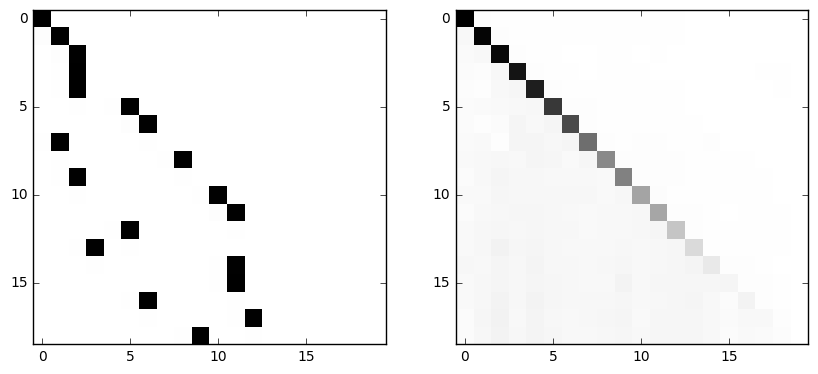

Epoch #9400
    Loss: -0.0269438065588


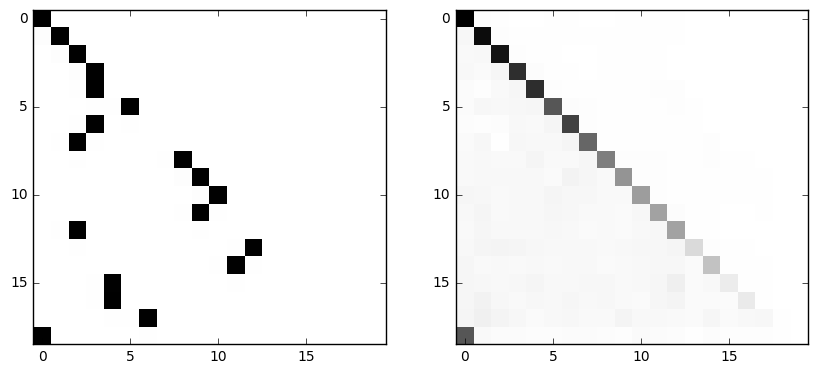

Epoch #9500
    Loss: -0.0296608023345


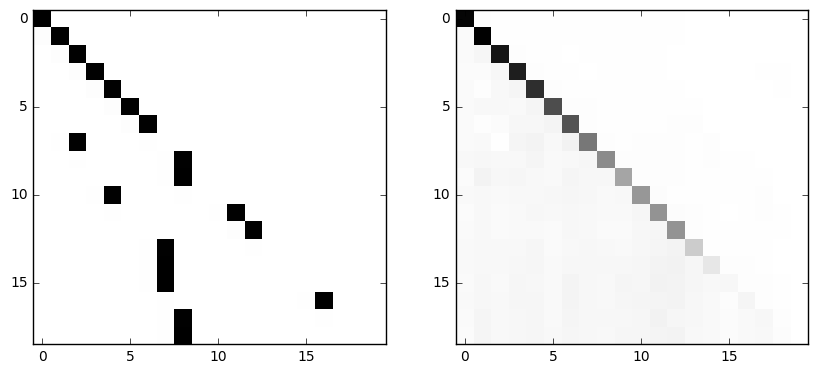

Epoch #9600
    Loss: -0.0301820989698


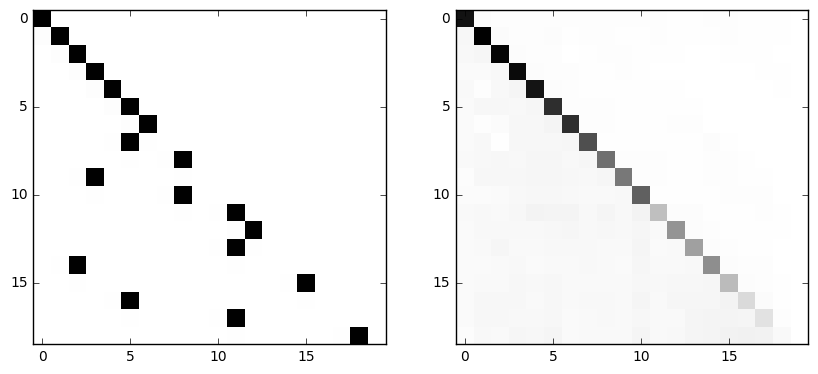

Epoch #9700
    Loss: -0.029756564647


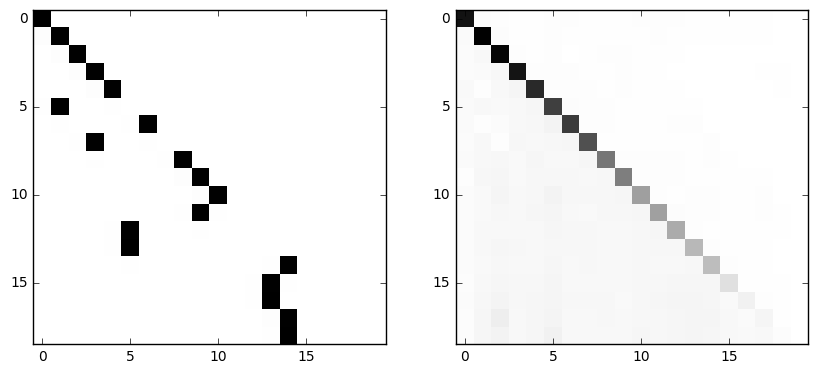

Epoch #9800
    Loss: -0.0315627865493


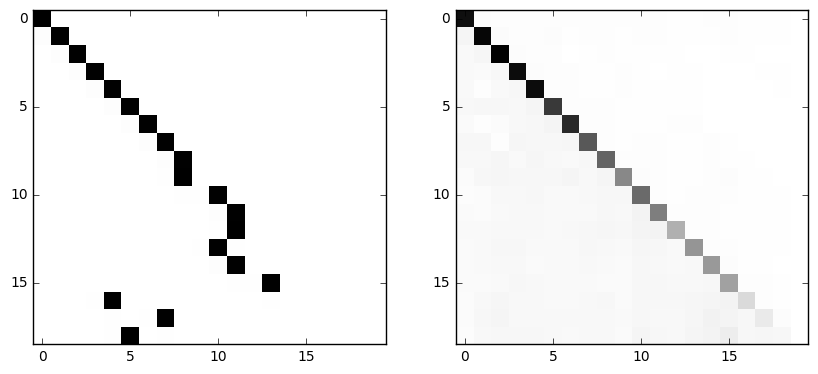

Epoch #9900
    Loss: -0.0331822745502


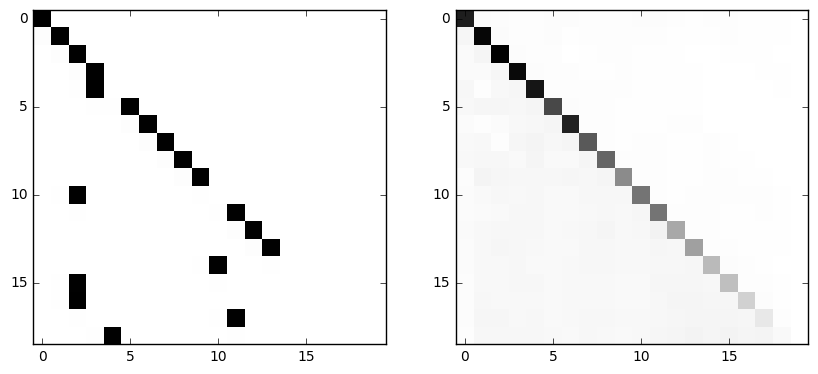

Epoch #10000
    Loss: -0.0243003237993


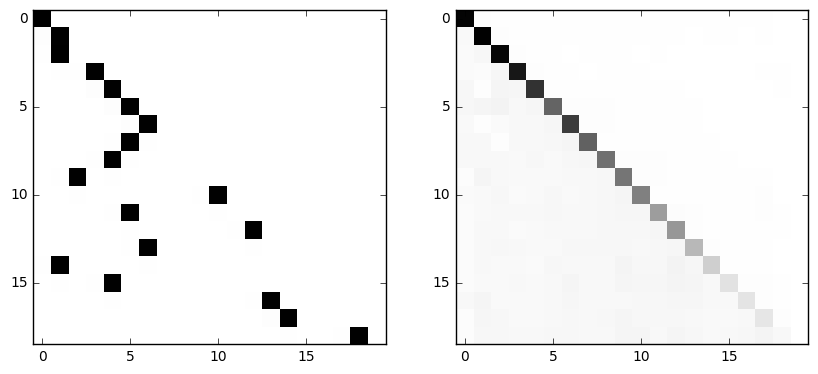

Epoch #10100
    Loss: -0.0218425970525


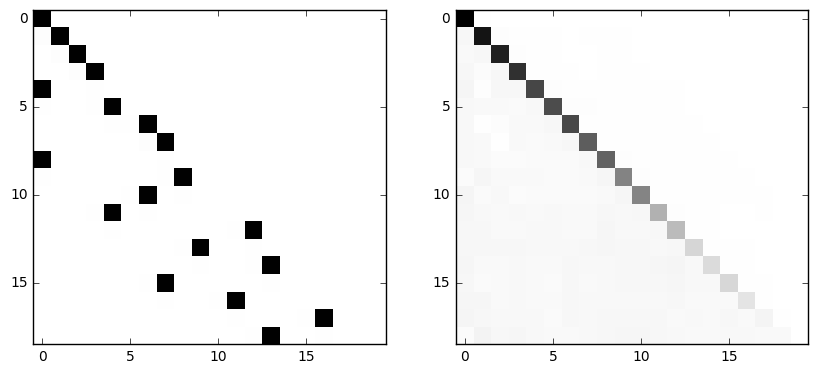

Epoch #10200
    Loss: -0.0313162319362


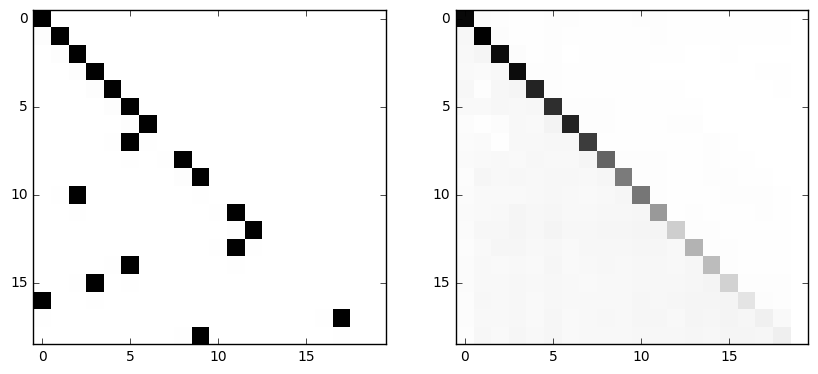

Epoch #10300
    Loss: -0.0285546965897


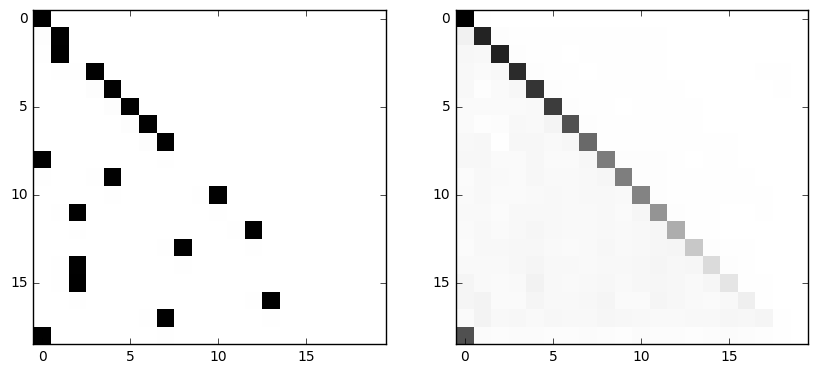

Epoch #10400
    Loss: -0.0311459302902


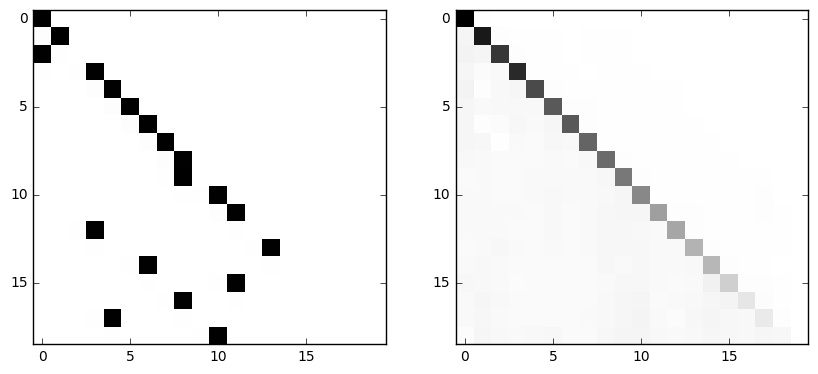

Epoch #10500
    Loss: -0.0278900638223


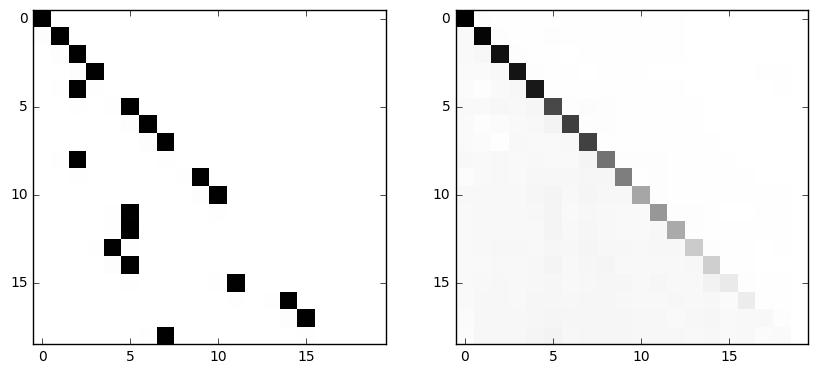

Epoch #10600
    Loss: -0.0262754671276


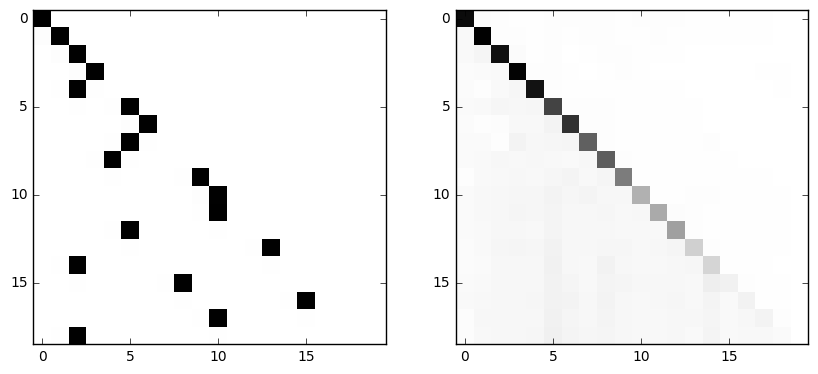

Epoch #10700
    Loss: -0.0355949252844


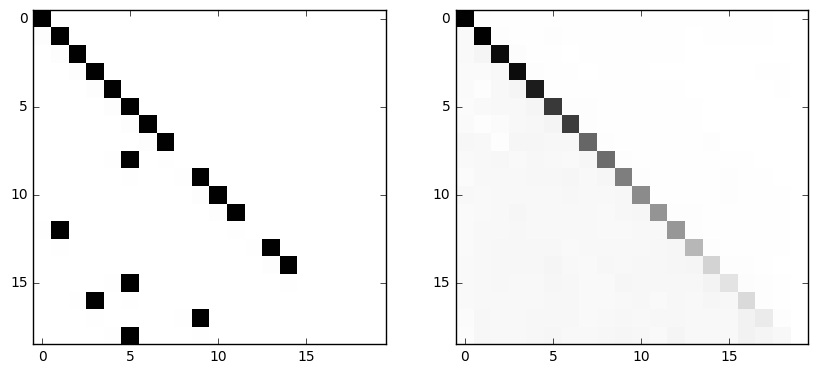

Epoch #10800
    Loss: -0.0205683168024


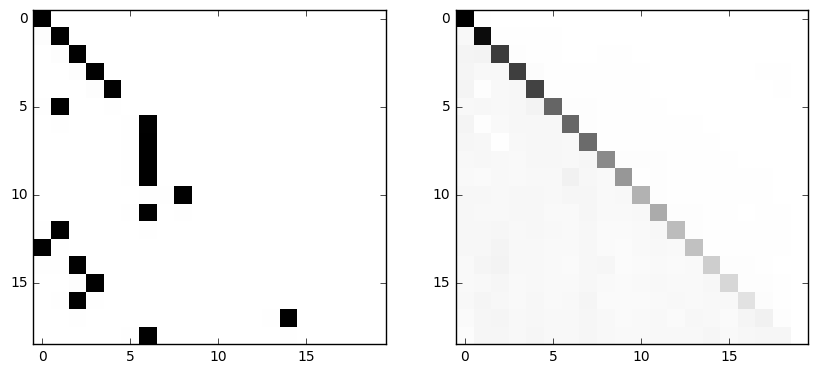

Epoch #10900
    Loss: -0.0316186919808


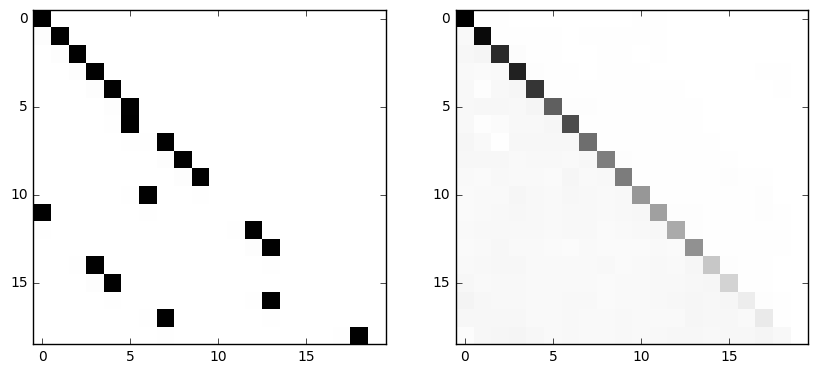

Epoch #11000
    Loss: -0.0245911031961


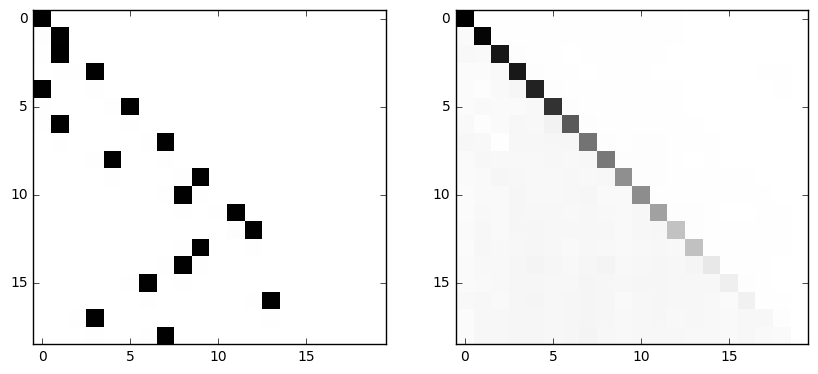

Epoch #11100
    Loss: -0.0290468689054


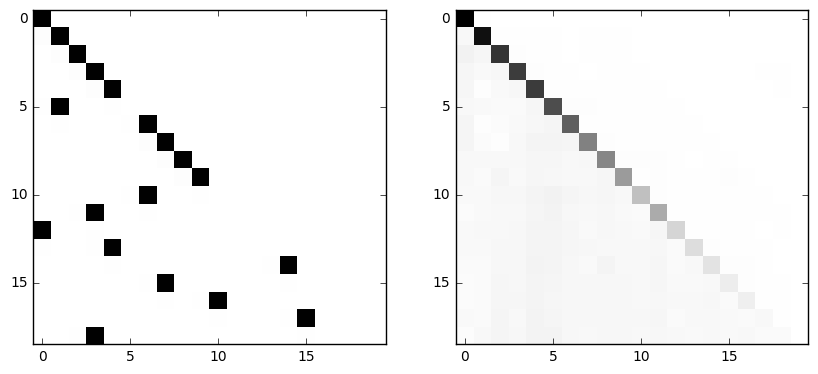

Epoch #11200
    Loss: -0.0316999405622


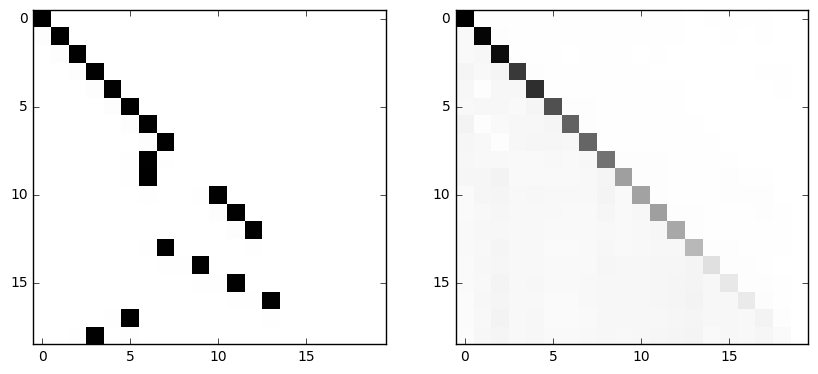

Epoch #11300
    Loss: -0.0224900525063


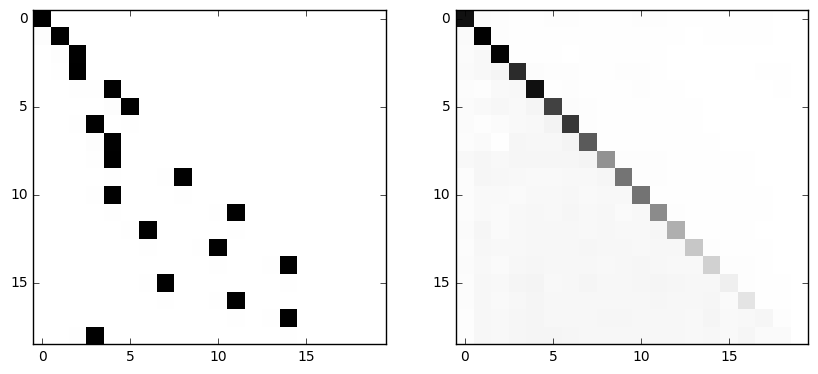

Epoch #11400
    Loss: -0.030501389876


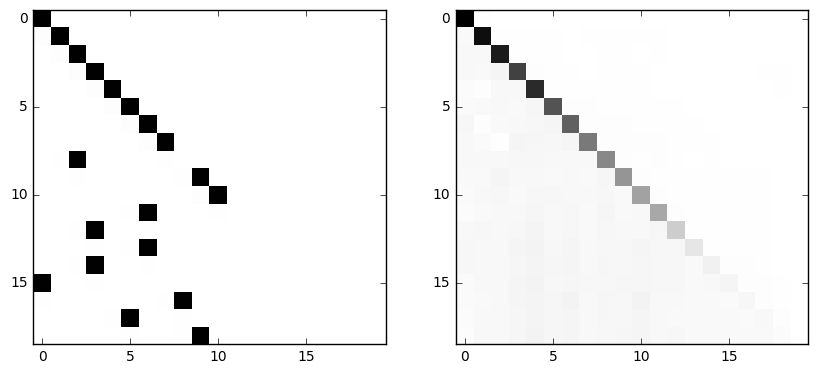

Epoch #11500
    Loss: -0.0290835052729


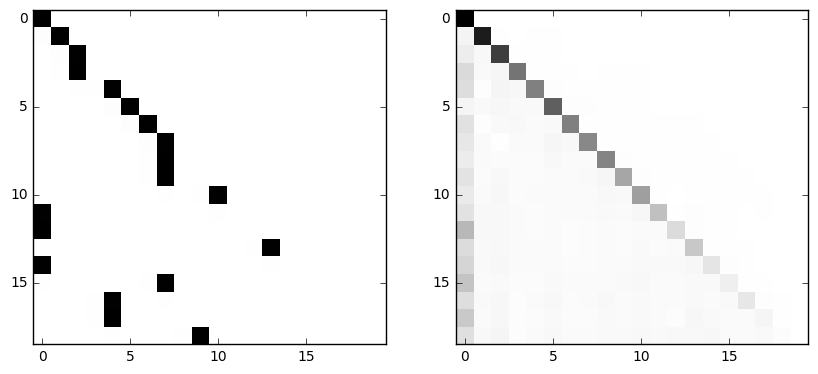

Epoch #11600
    Loss: -0.028824724257


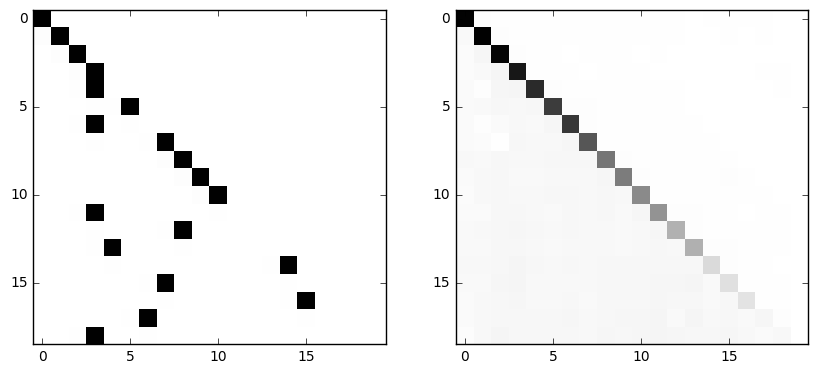

Epoch #11700
    Loss: -0.0357545912266


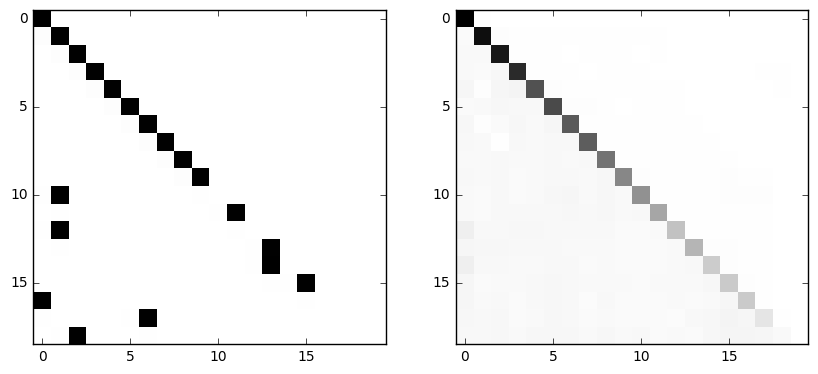

Epoch #11800
    Loss: -0.0287431720644


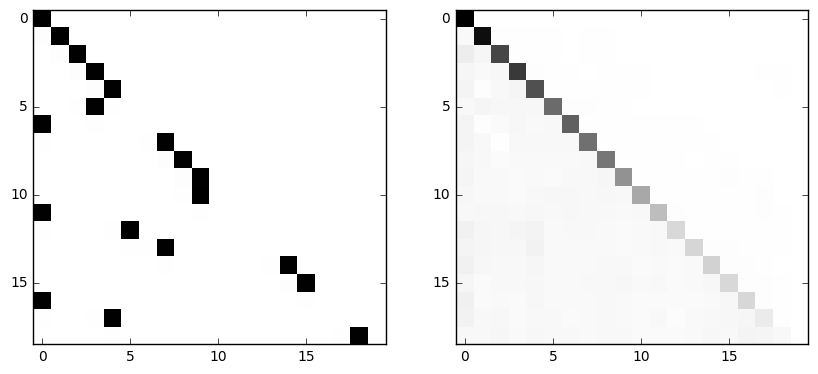

Epoch #11900
    Loss: -0.0217007342726


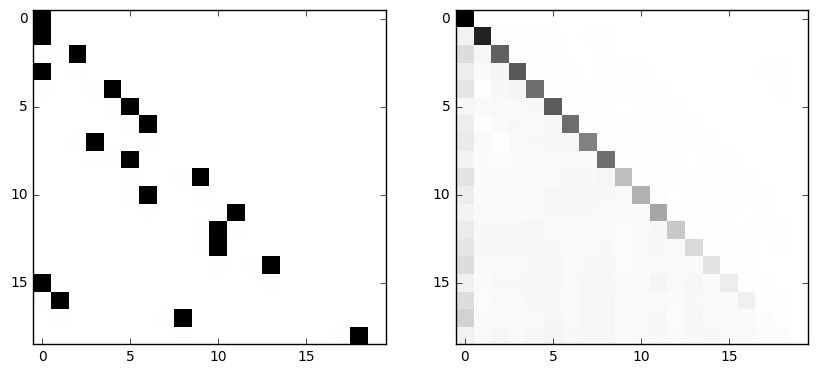

Epoch #12000
    Loss: -0.0262914858758


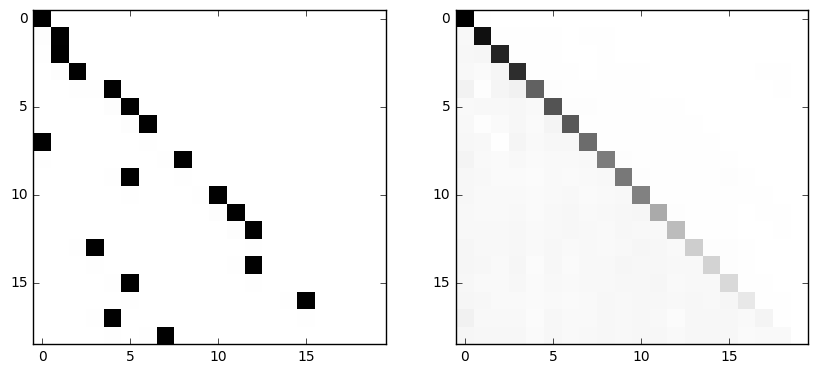

Epoch #12100
    Loss: -0.029001602903


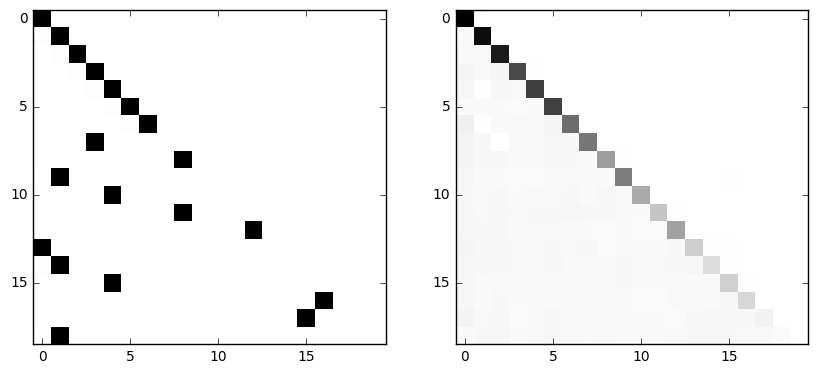

Epoch #12200
    Loss: -0.0316213741899


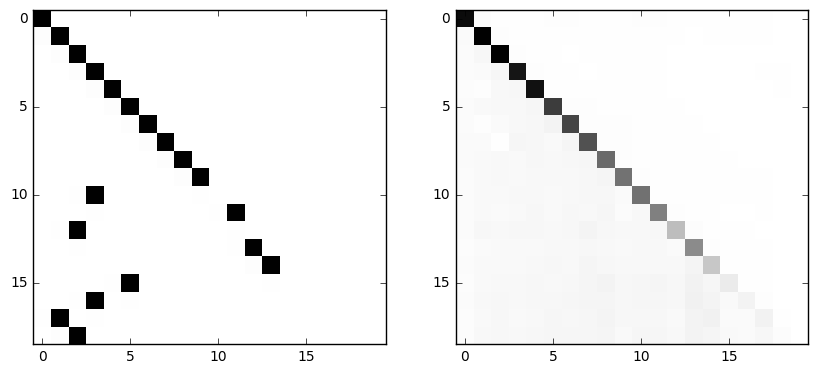

Epoch #12300
    Loss: -0.0330987051129


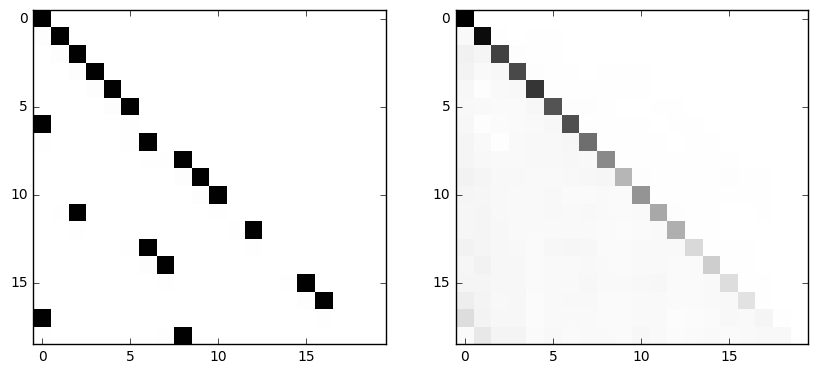

Epoch #12400
    Loss: -0.0318503007293


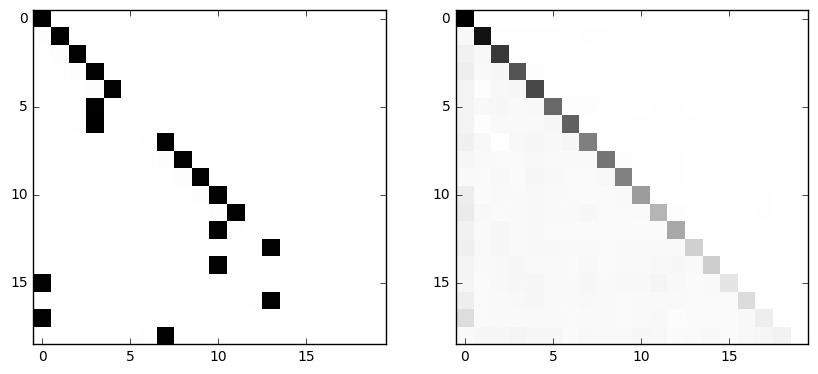

Epoch #12500
    Loss: -0.0261912103742


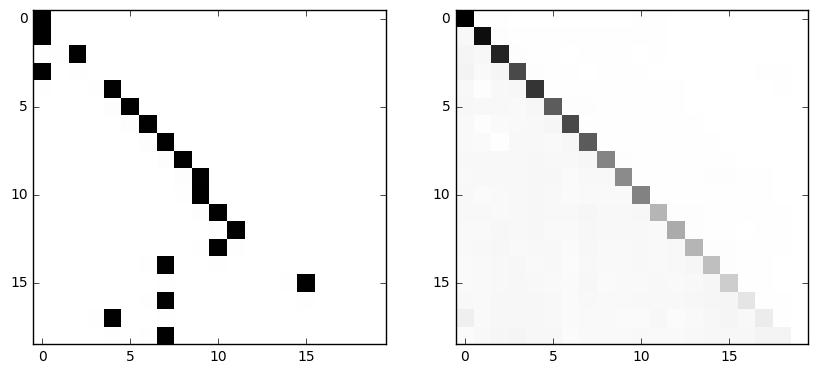

Epoch #12600
    Loss: -0.0398330241442


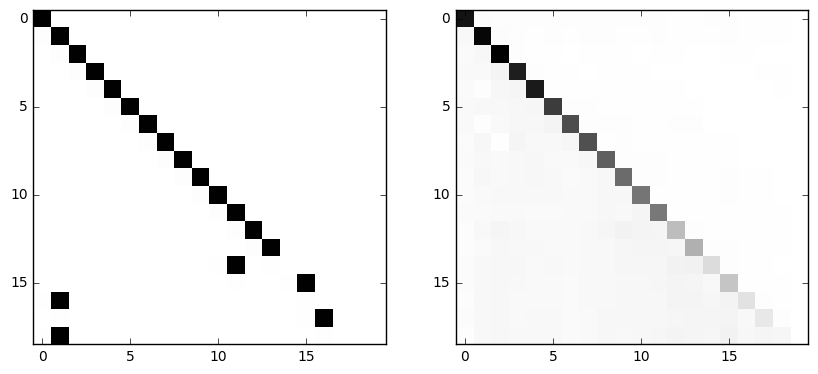

Epoch #12700
    Loss: -0.0255824681371


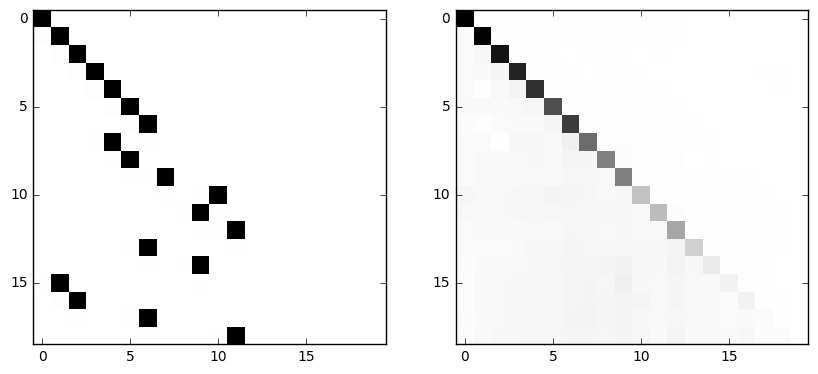

Epoch #12800
    Loss: -0.0307972840965


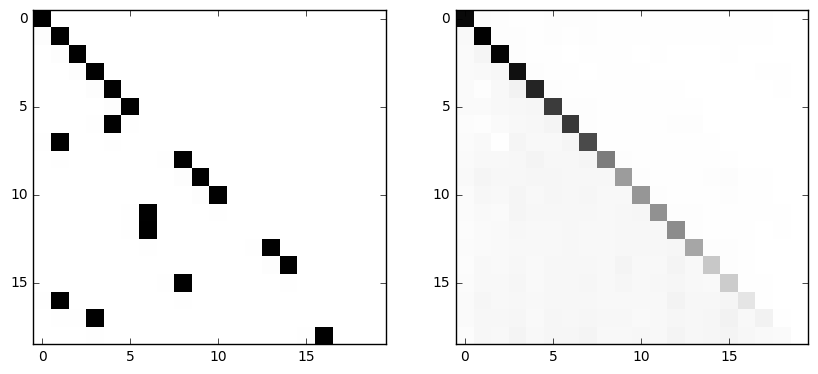

Epoch #12900
    Loss: -0.0283774100244


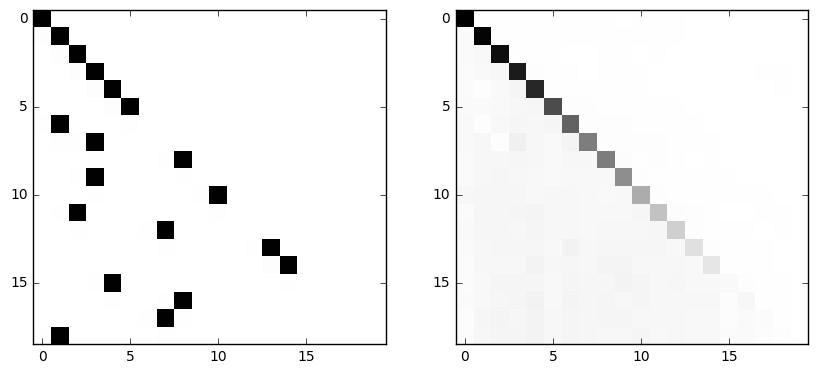

Epoch #13000
    Loss: -0.0297810491174


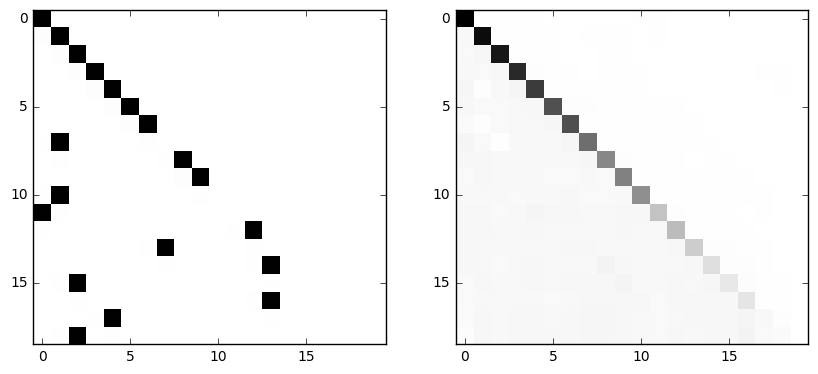

Epoch #13100
    Loss: -0.0234390180558


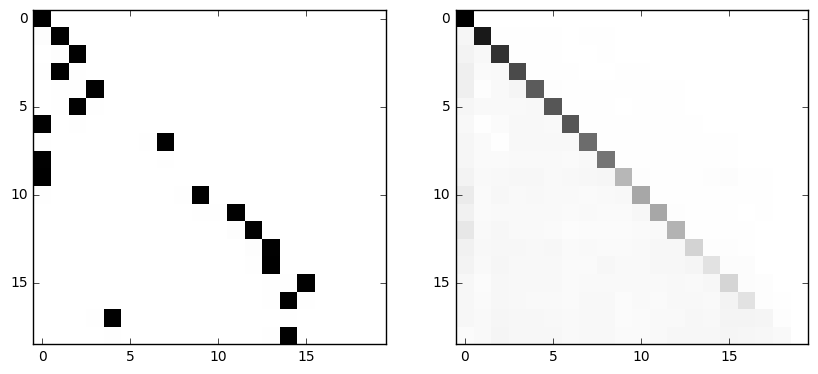

Epoch #13200
    Loss: -0.0234919004142


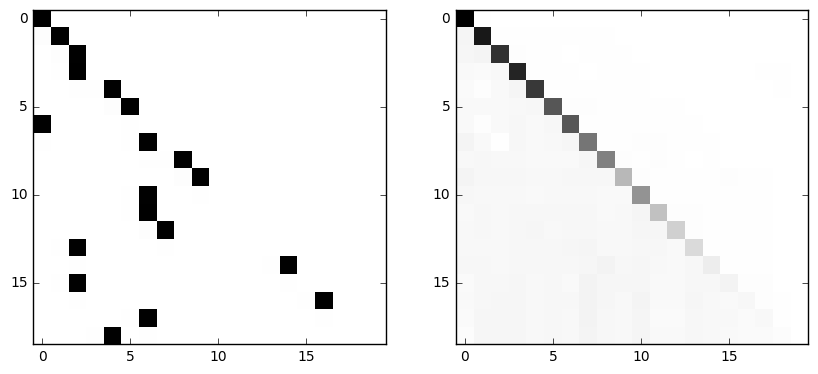

Epoch #13300
    Loss: -0.0363692045212


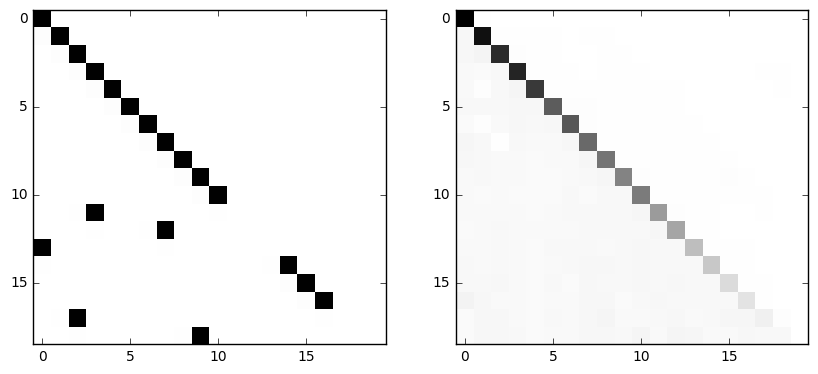

Epoch #13400
    Loss: -0.0264336708933


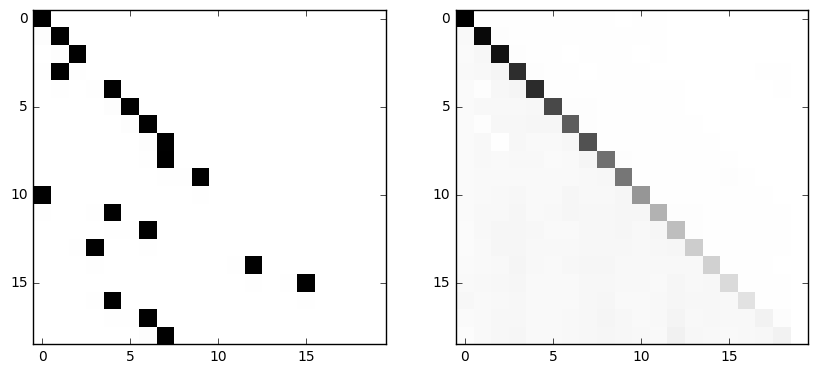

Epoch #13500
    Loss: -0.0285840090364


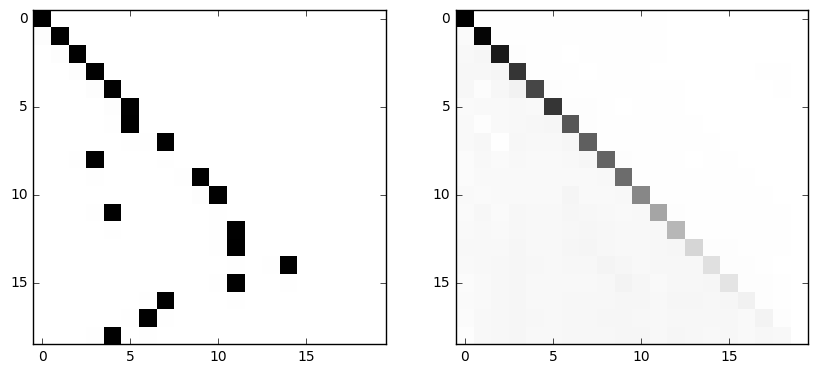

Epoch #13600
    Loss: -0.032103151083


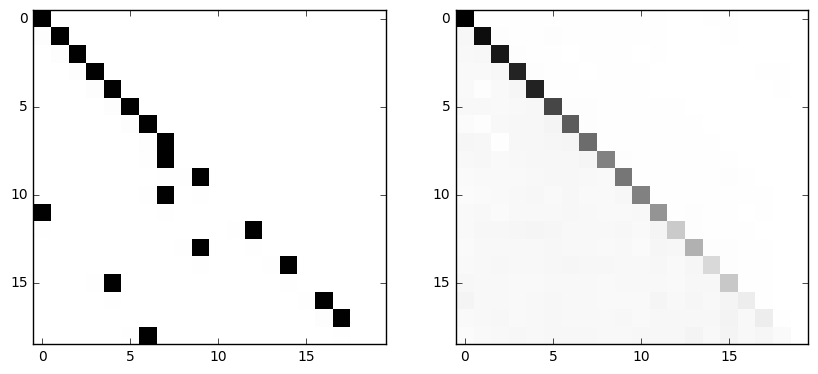

Epoch #13700
    Loss: -0.0292512997985


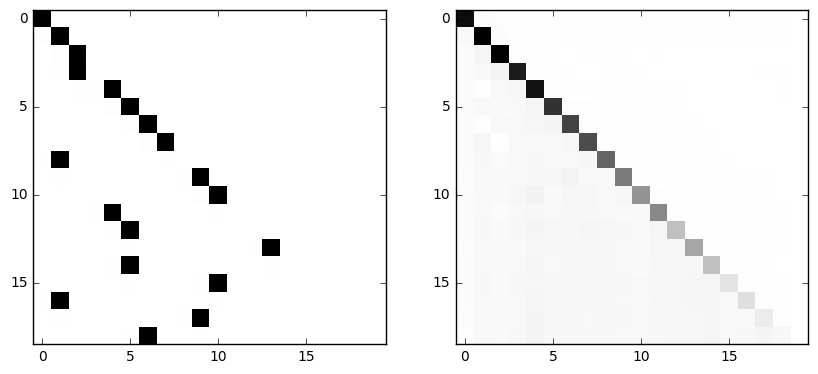

Epoch #13800
    Loss: -0.0210669096559


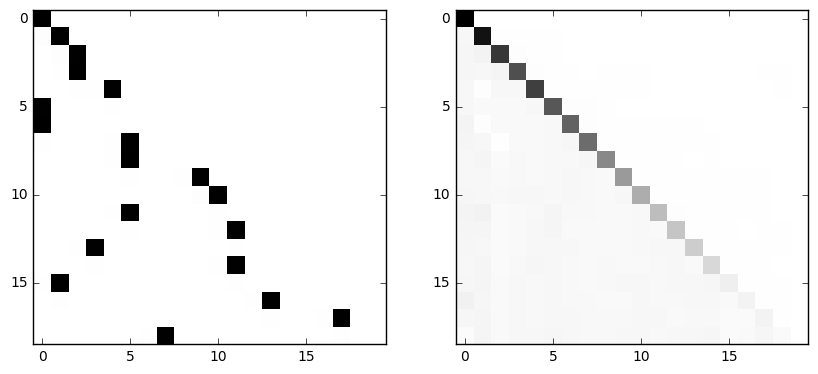

Epoch #13900
    Loss: -0.0234427955002


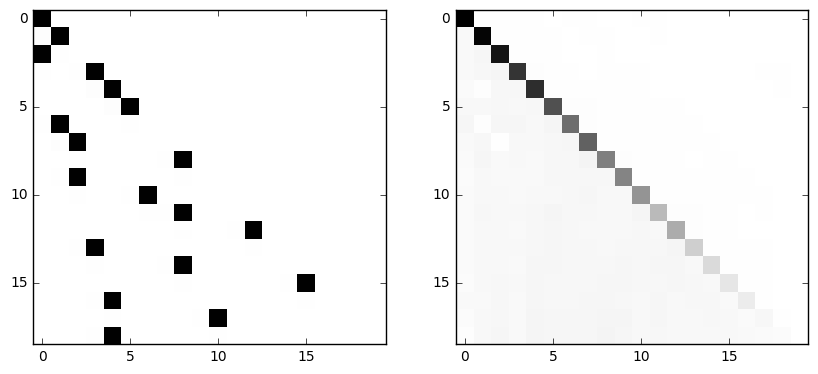

Epoch #14000
    Loss: -0.0235466081649


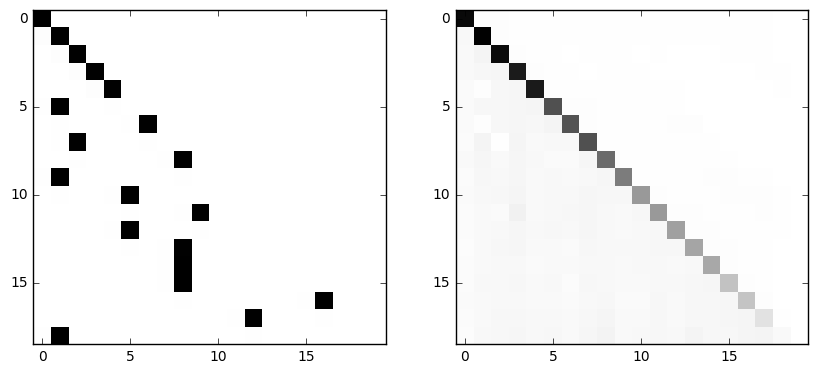

Epoch #14100
    Loss: -0.0240888800472


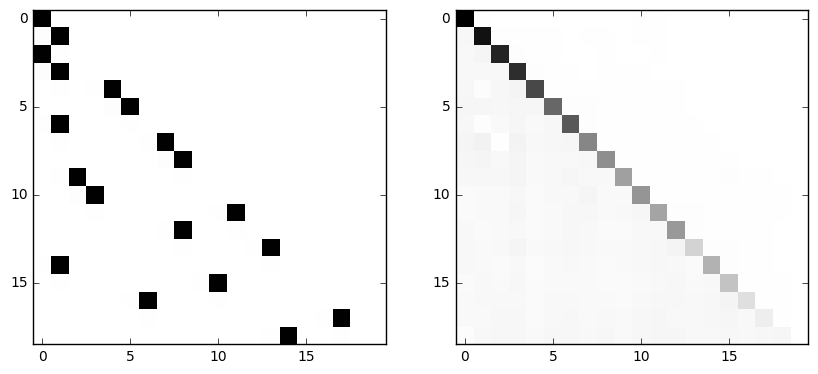

Epoch #14200
    Loss: -0.0250092893839


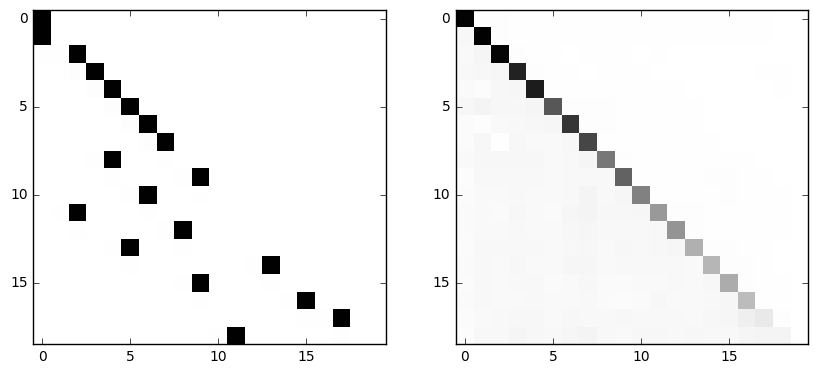

Epoch #14300
    Loss: -0.0304328426719


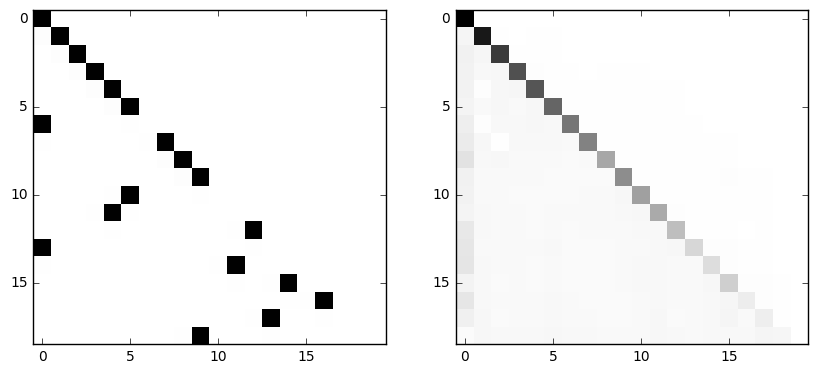

Epoch #14400
    Loss: -0.0349595732987


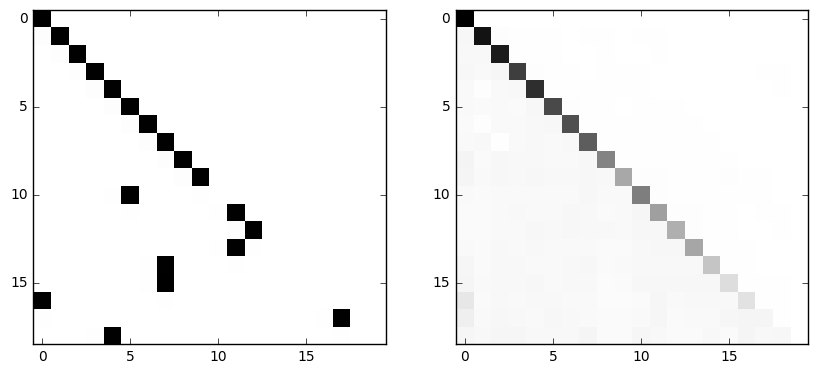

Epoch #14500
    Loss: -0.0291030760854


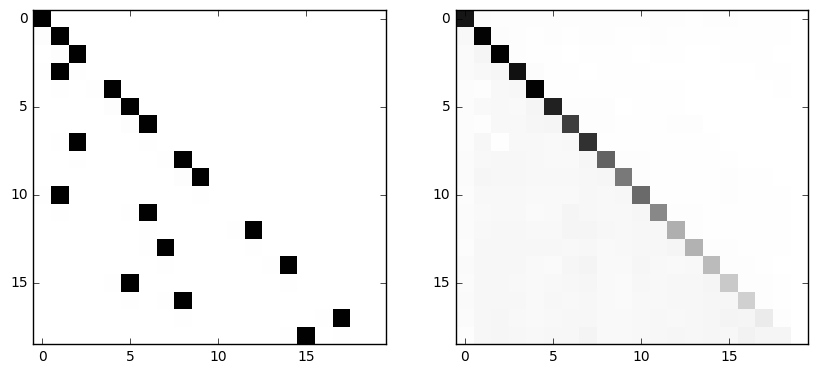

Epoch #14600
    Loss: -0.031510066241


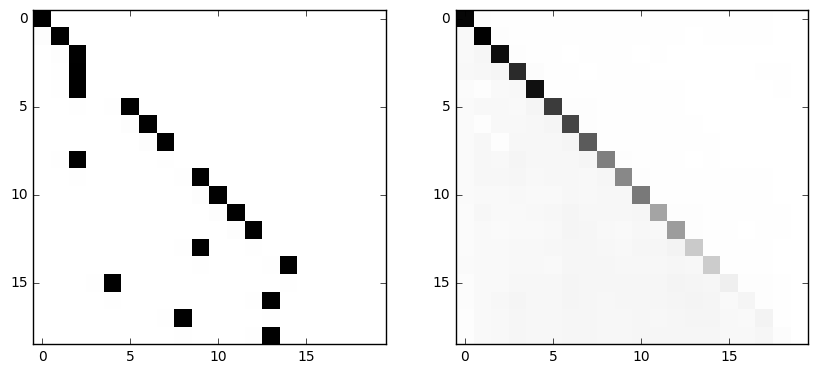

Epoch #14700
    Loss: -0.023684149608


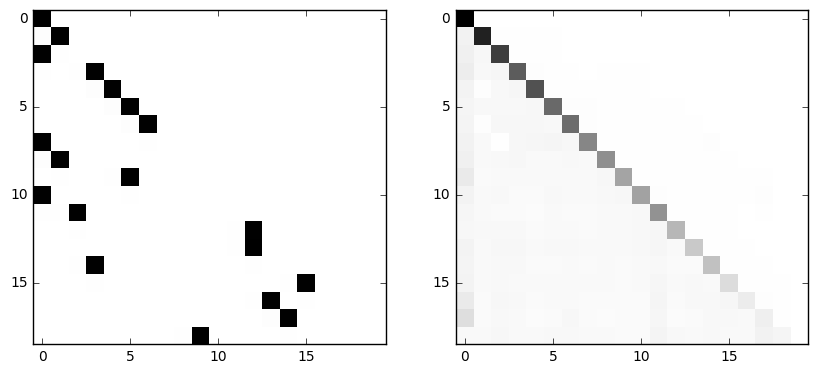

Epoch #14800
    Loss: -0.0251926630735


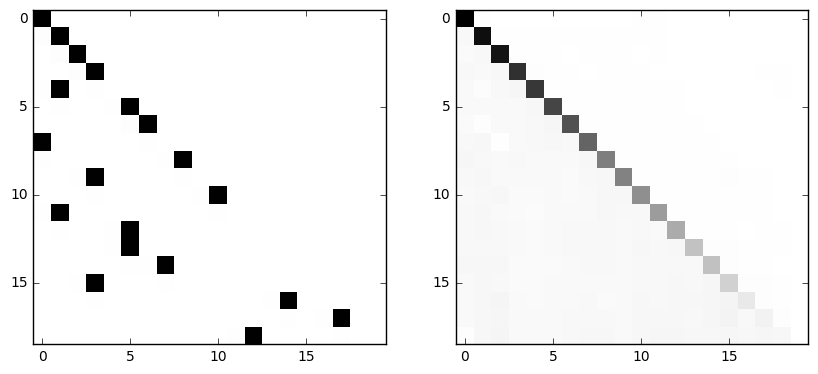

Epoch #14900
    Loss: -0.028918499127


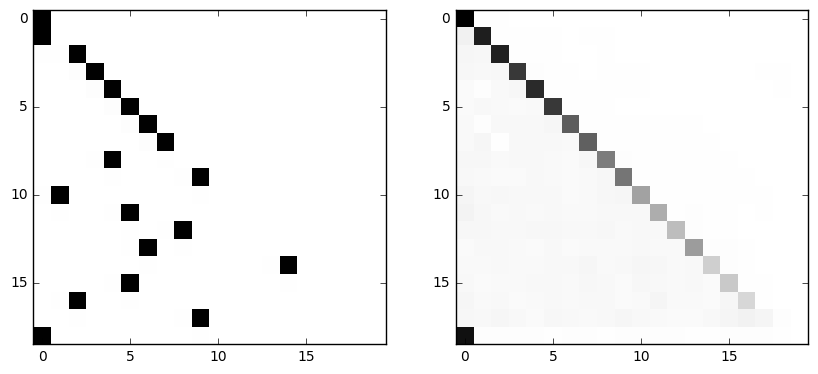

Epoch #15000
    Loss: -0.0286128073931


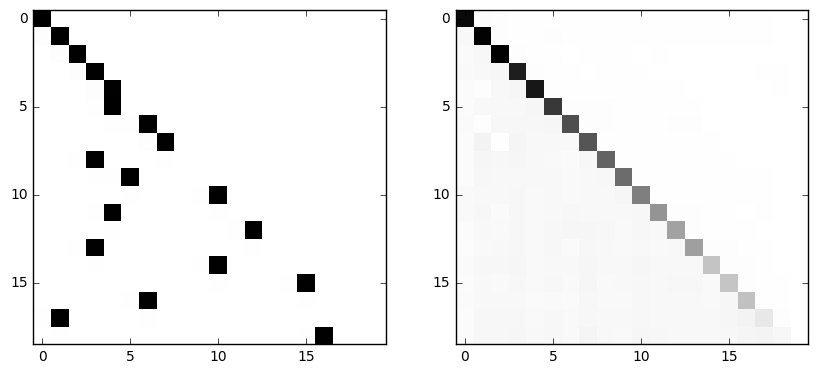

Epoch #15100
    Loss: -0.0203808341175


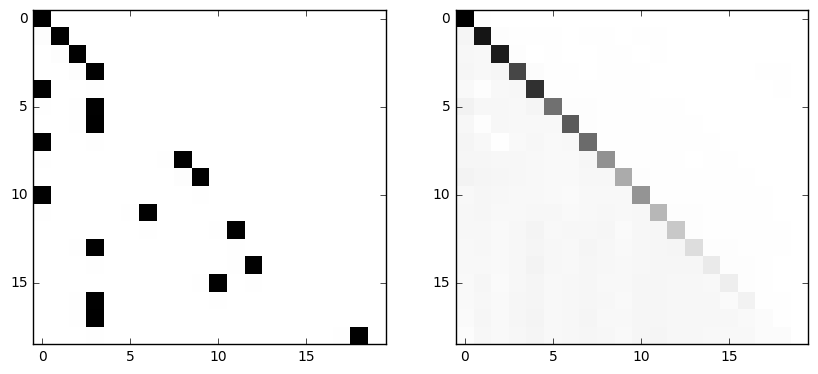

Epoch #15200
    Loss: -0.0356257222593


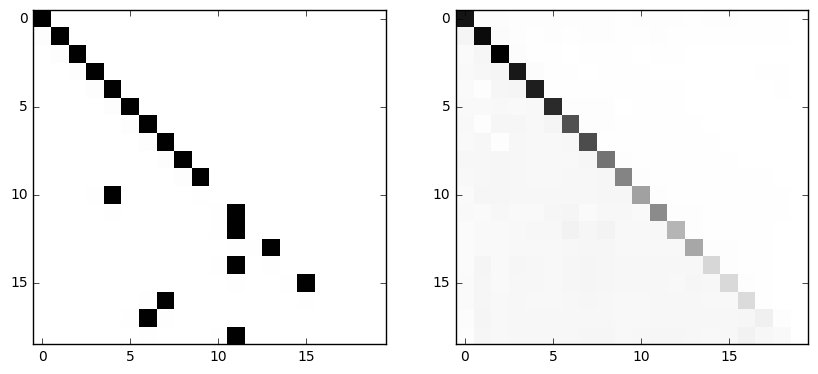

Epoch #15300
    Loss: -0.020722432062


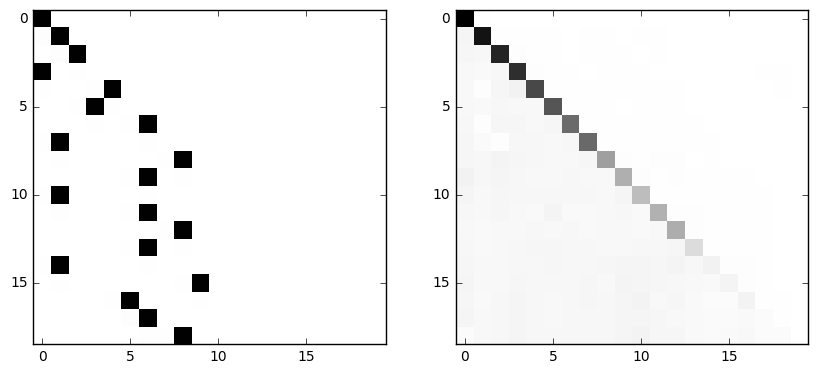

Epoch #15400
    Loss: -0.0216438546777


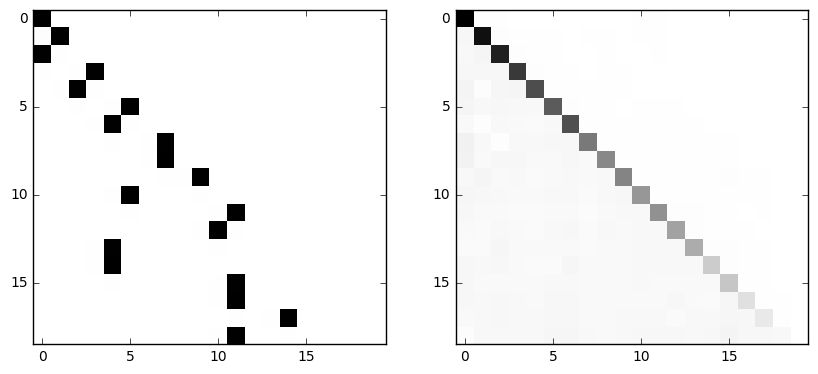

Epoch #15500
    Loss: -0.0312958396971


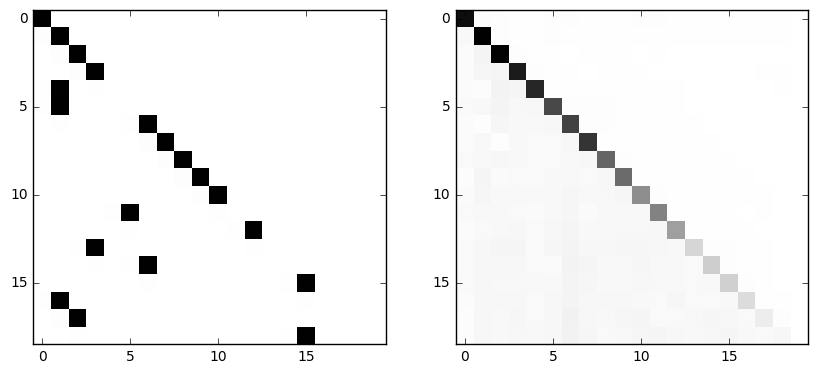

Epoch #15600
    Loss: -0.0274419225752


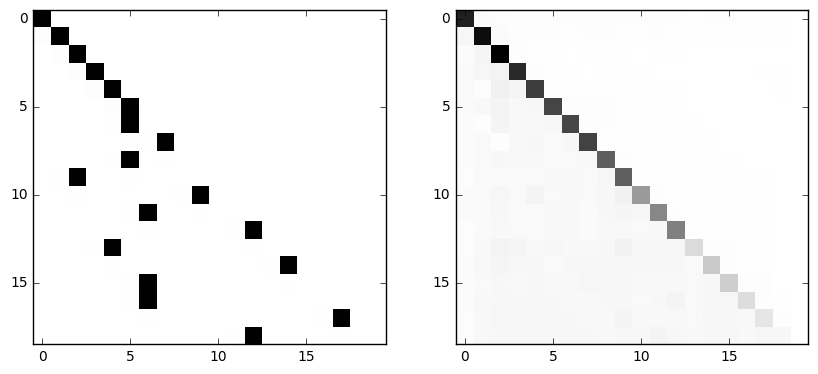

Epoch #15700
    Loss: -0.0288382638246


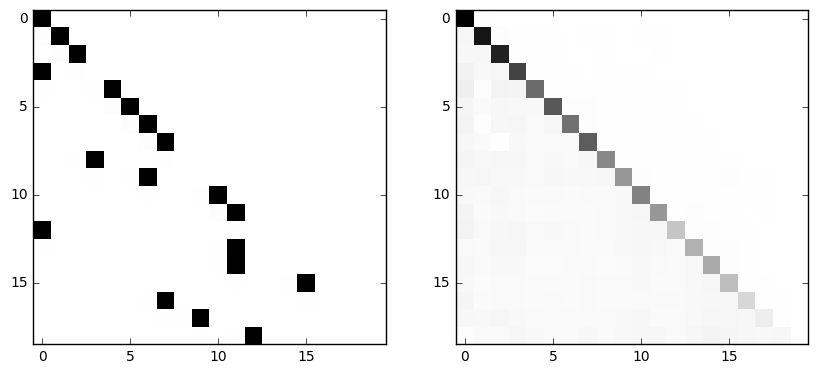

Epoch #15800
    Loss: -0.0302060097456


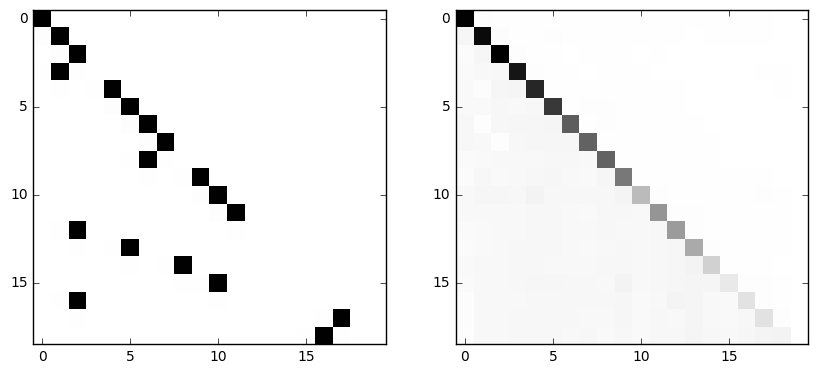

Epoch #15900
    Loss: -0.0272705107927


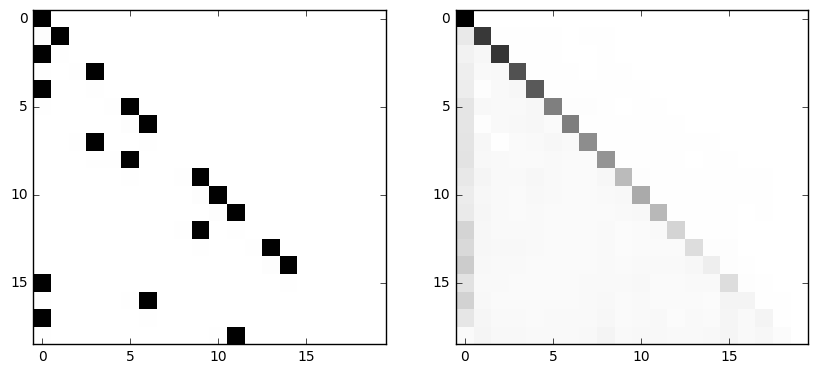

Epoch #16000
    Loss: -0.0309022199363


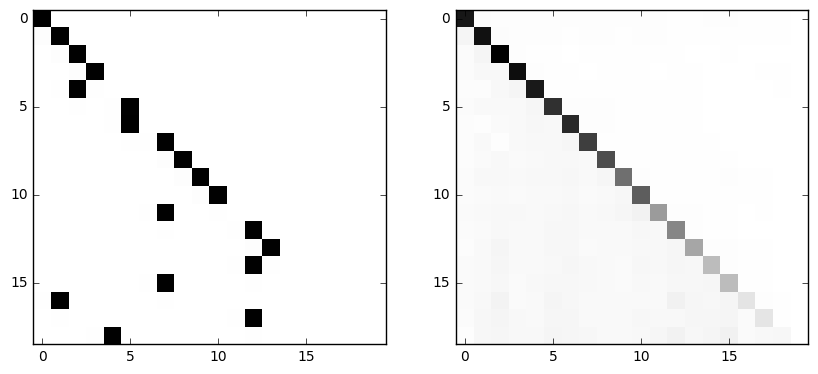

Epoch #16100
    Loss: -0.0245123282075


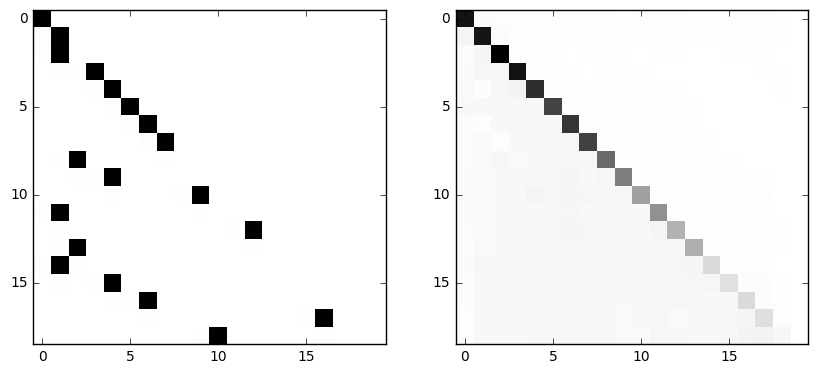

Epoch #16200
    Loss: -0.0275575425476


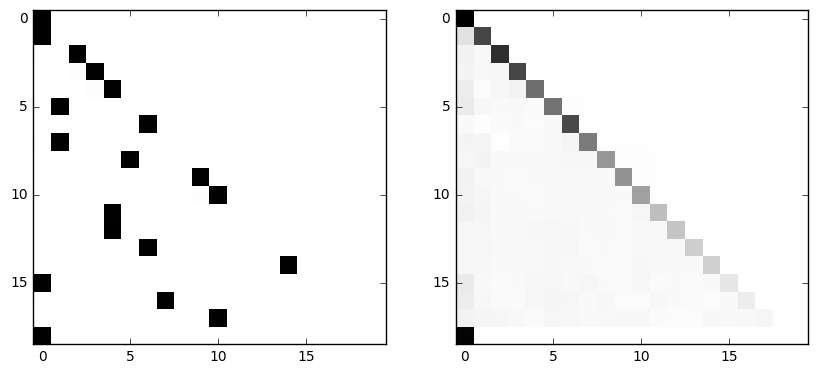

Epoch #16300
    Loss: -0.0281340032816


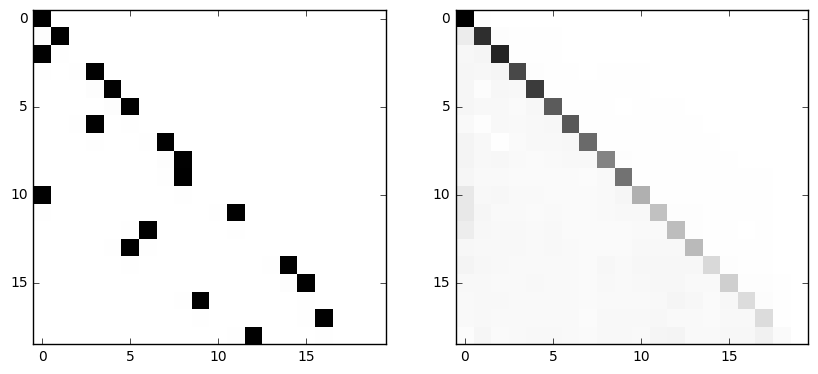

Epoch #16400
    Loss: -0.0329512692988


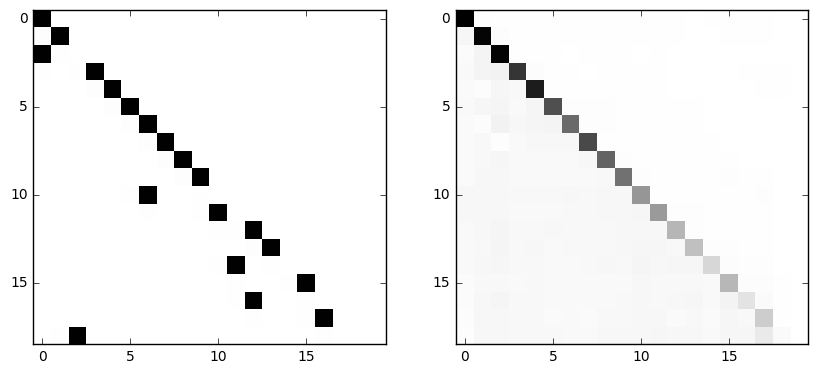

Epoch #16500
    Loss: -0.029235413298


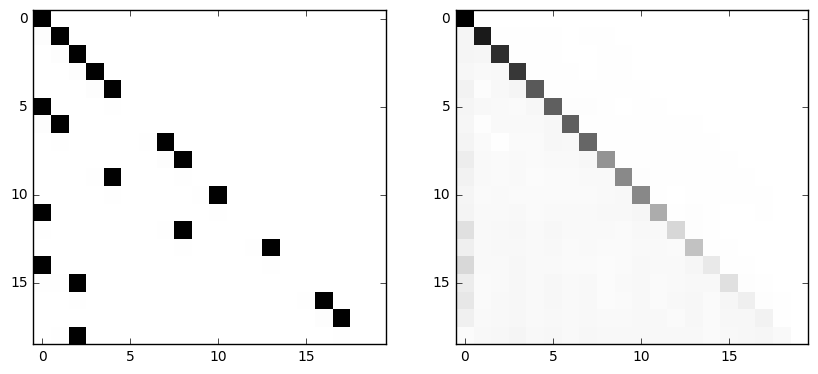

Epoch #16600
    Loss: -0.0321371555328


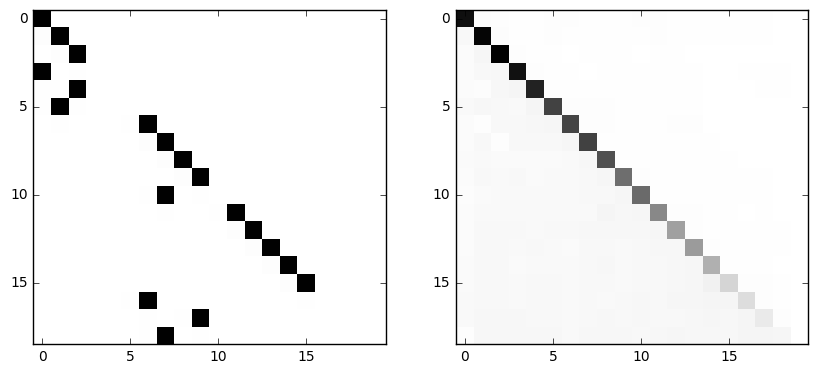

Epoch #16700
    Loss: -0.0266688968986


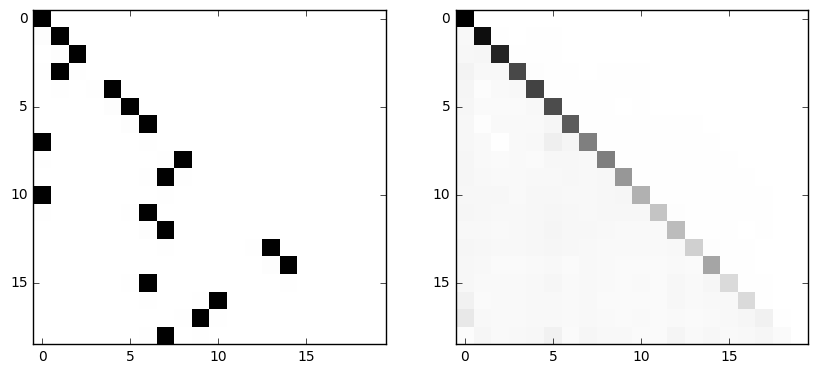

Epoch #16800
    Loss: -0.0288997292519


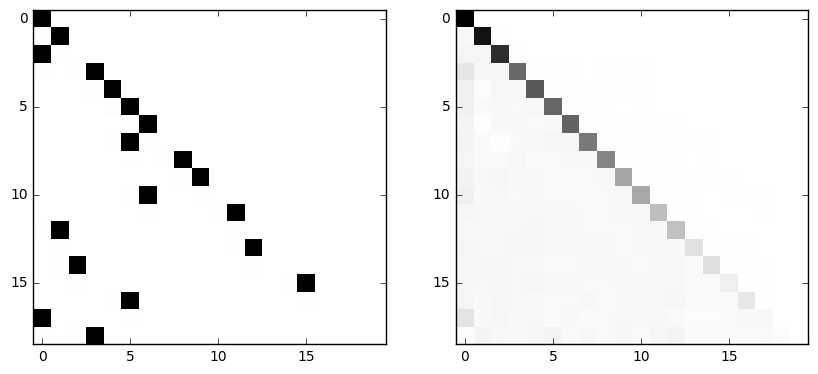

Epoch #16900
    Loss: -0.026684705168


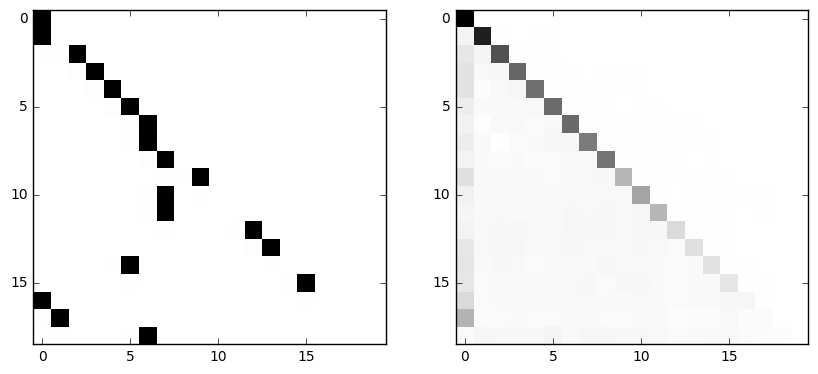

Epoch #17000
    Loss: -0.0333354286849


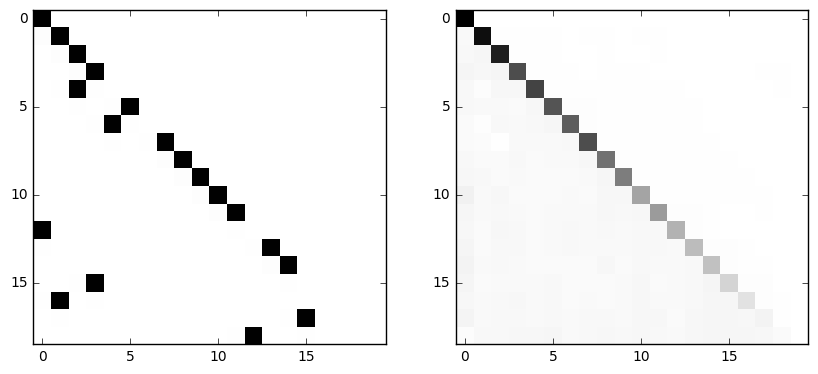

Epoch #17100
    Loss: -0.0278295036405


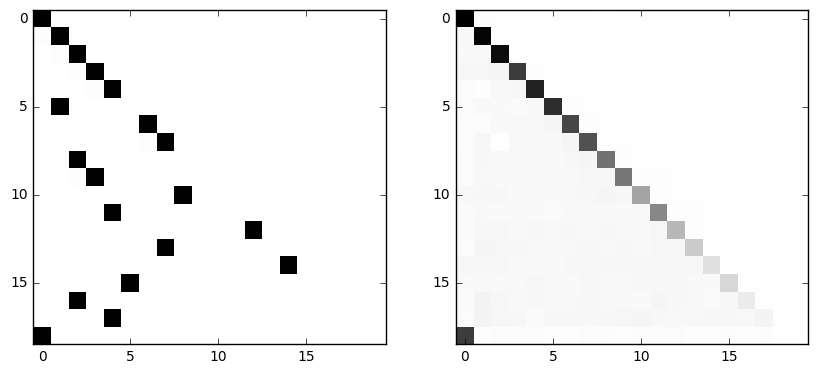

Epoch #17200
    Loss: -0.0243803169578


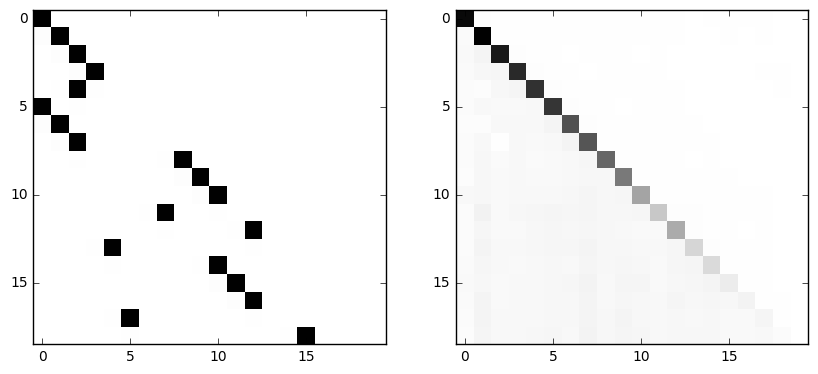

Epoch #17300
    Loss: -0.0287108048797


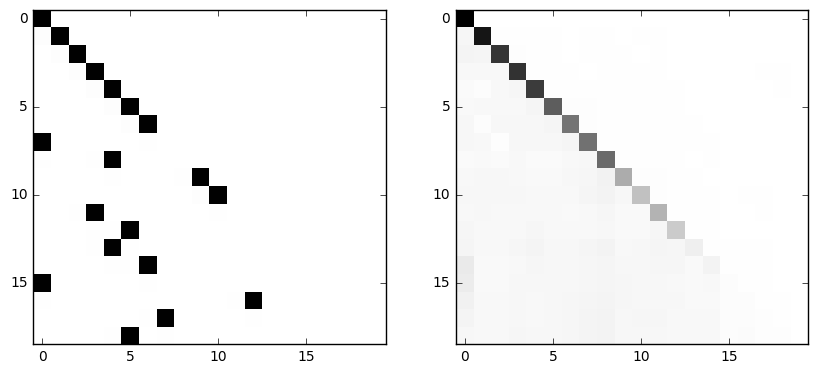

Epoch #17400
    Loss: -0.0270339995623


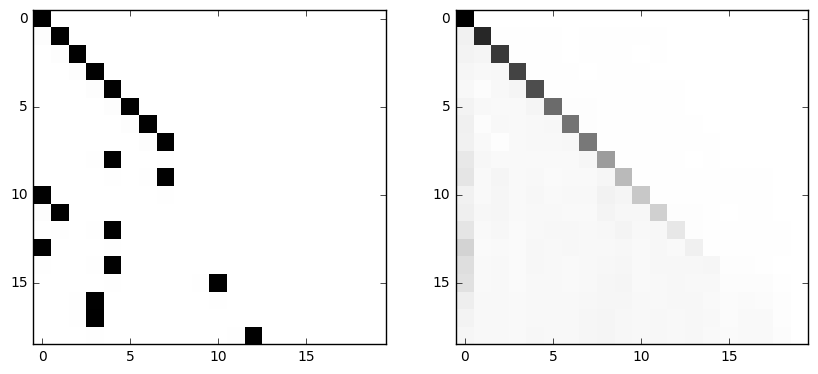

Epoch #17500
    Loss: -0.0283313486725


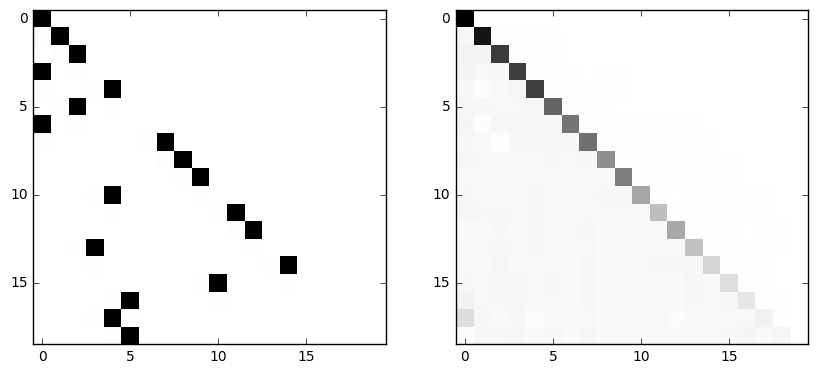

Epoch #17600
    Loss: -0.0263024885207


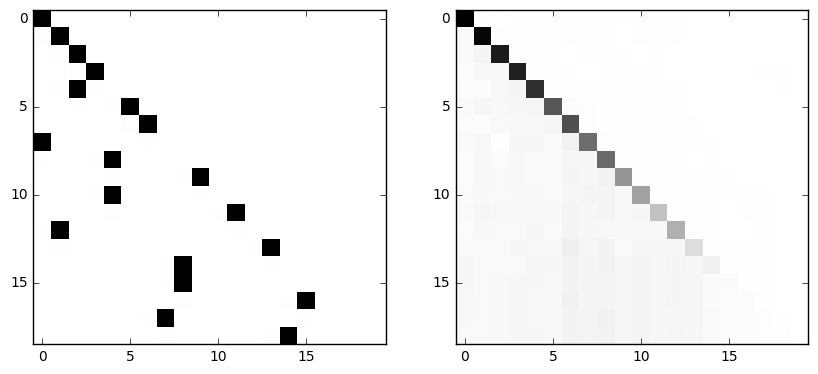

Epoch #17700
    Loss: -0.0258244462311


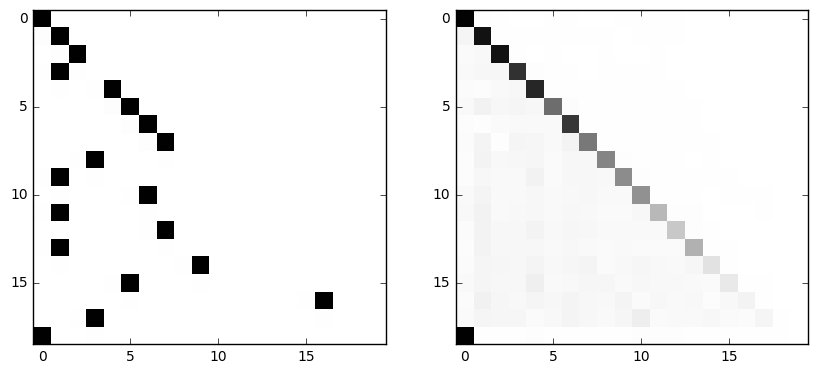

Epoch #17800
    Loss: -0.0249116010964


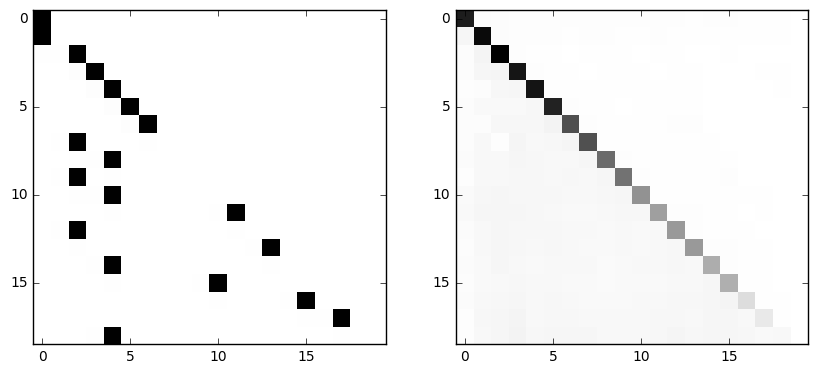

Epoch #17900
    Loss: -0.0239945668727


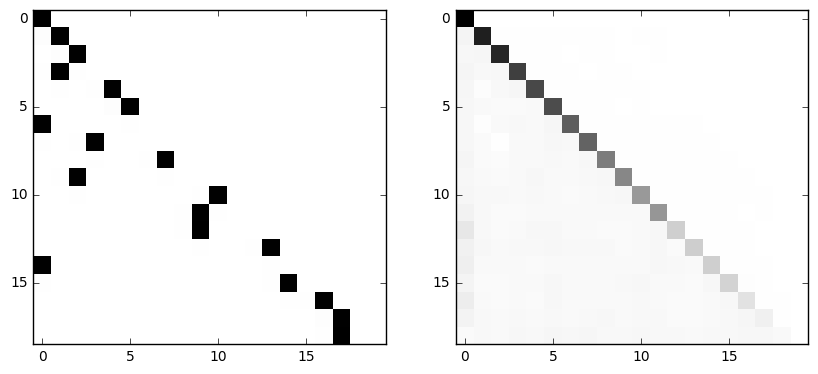

Epoch #18000
    Loss: -0.0242426935583


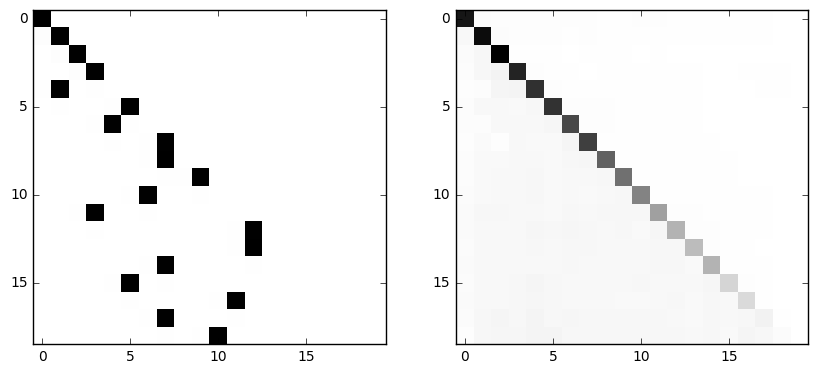

Epoch #18100
    Loss: -0.028355255723


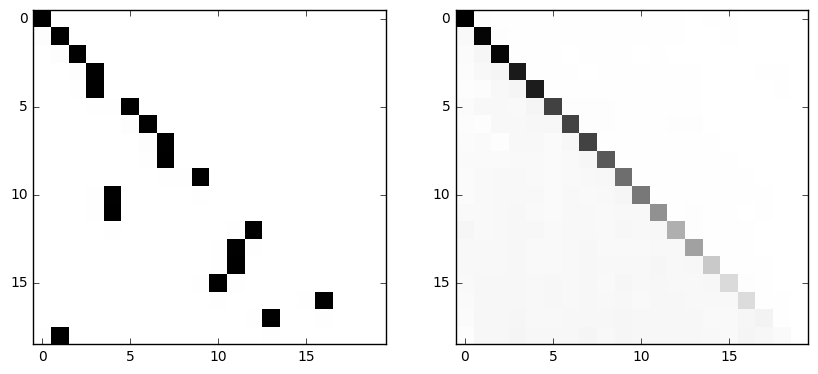

Epoch #18200
    Loss: -0.0263391323388


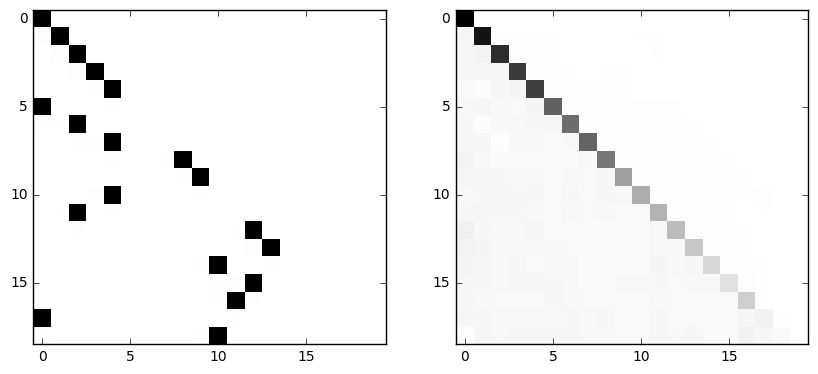

Epoch #18300
    Loss: -0.033009454608


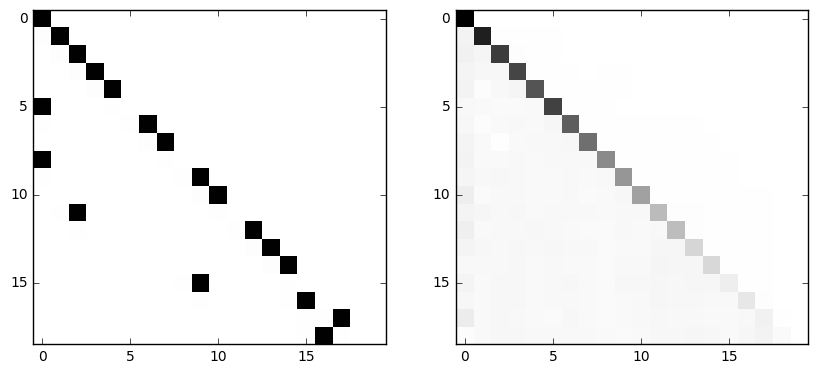

Epoch #18400
    Loss: -0.0280372146517


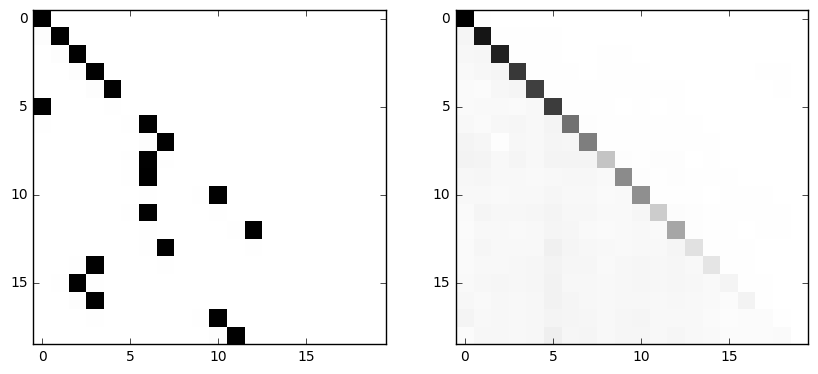

Epoch #18500
    Loss: -0.0312110558152


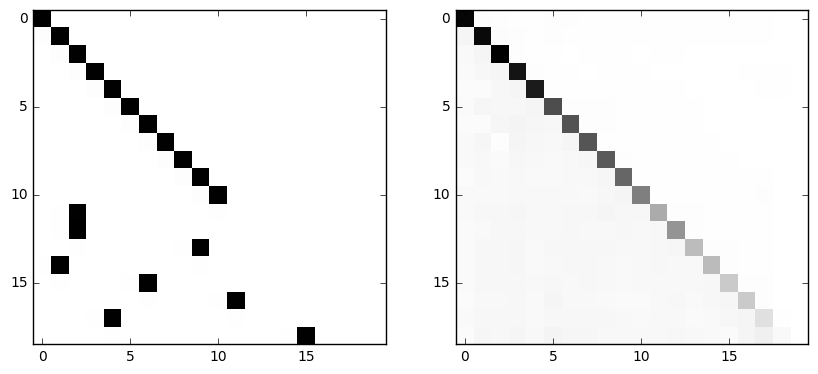

Epoch #18600
    Loss: -0.0230487622321


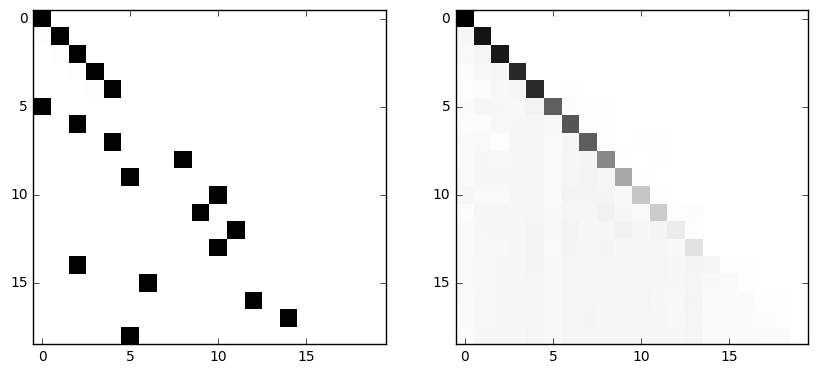

Epoch #18700
    Loss: -0.0304771102965


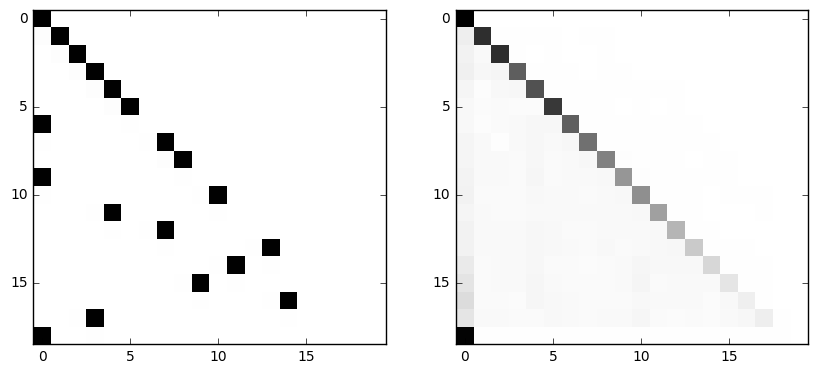

Epoch #18800
    Loss: -0.0284570362419


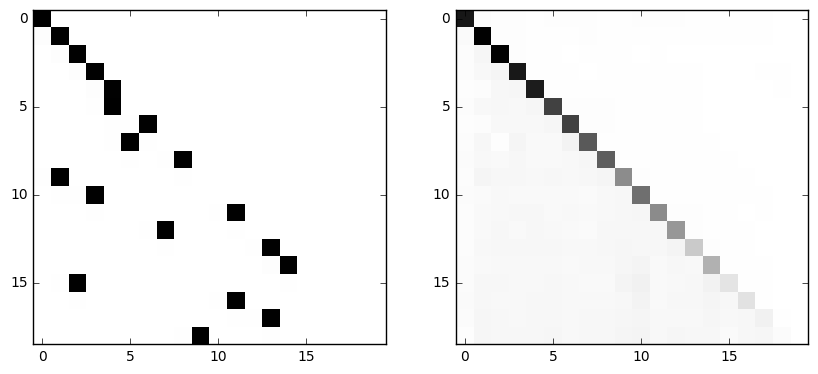

Epoch #18900
    Loss: -0.0356152914464


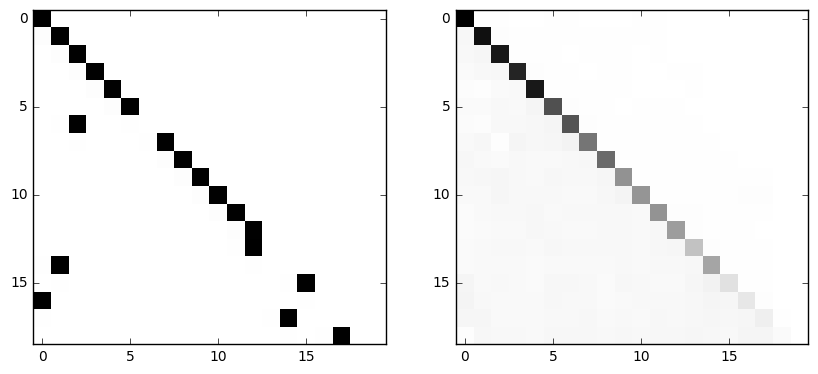

Epoch #19000
    Loss: -0.0241835024208


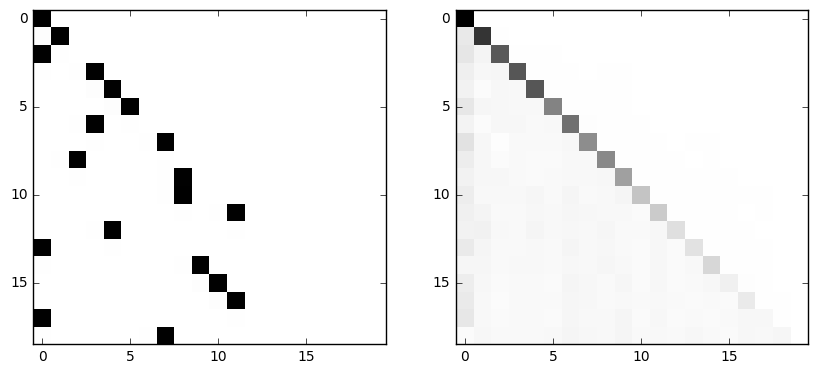

Epoch #19100
    Loss: -0.0253257509321


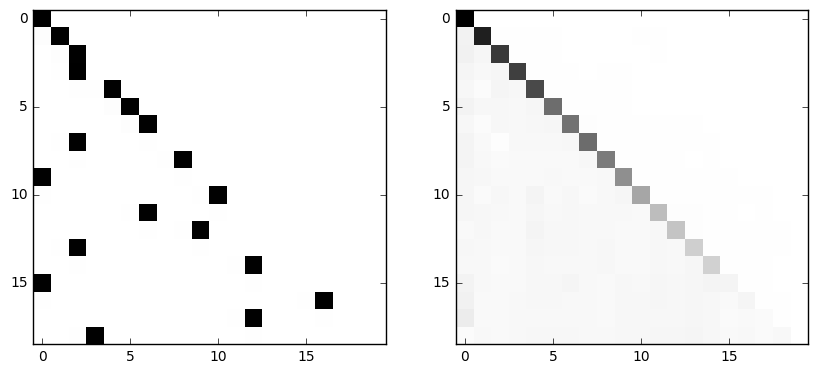

Epoch #19200
    Loss: -0.0247729234397


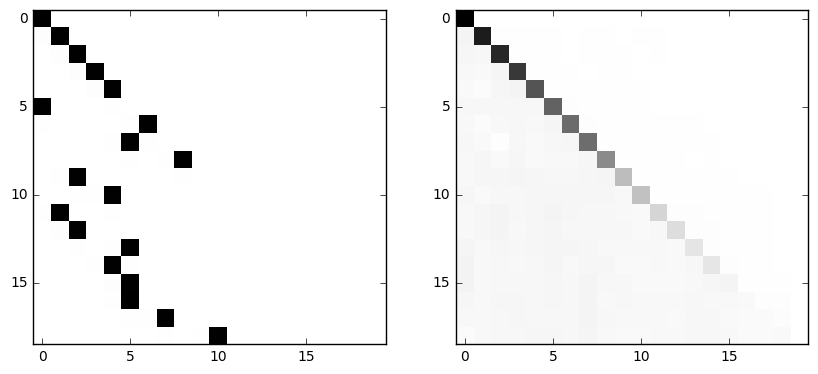

Epoch #19300
    Loss: -0.0284156166017


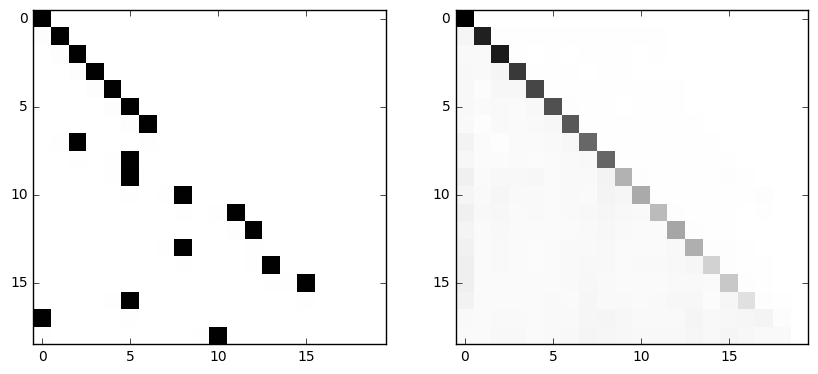

Epoch #19400
    Loss: -0.0290658511221


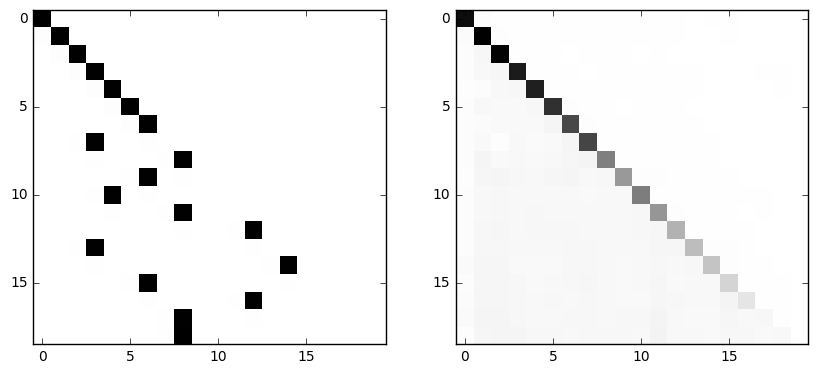

Epoch #19500
    Loss: -0.0259420517832


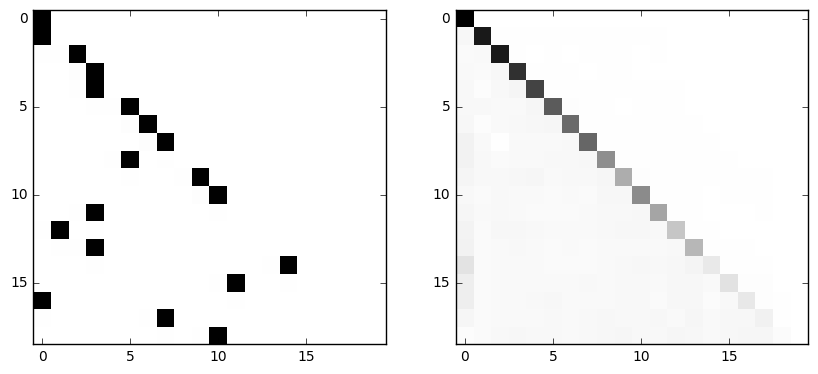

Epoch #19600
    Loss: -0.026966933161


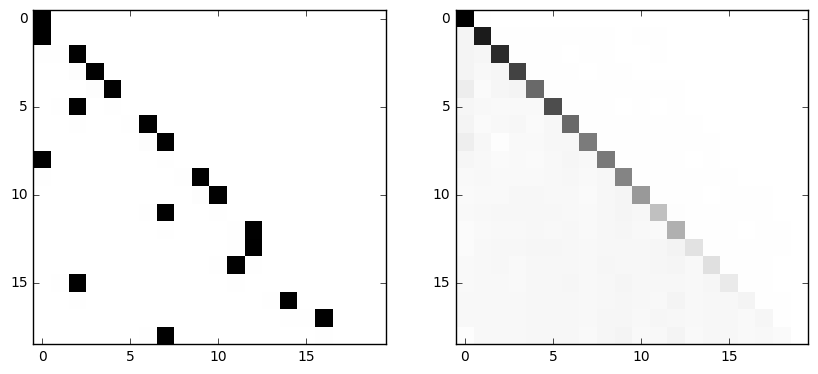

Epoch #19700
    Loss: -0.0233171023428


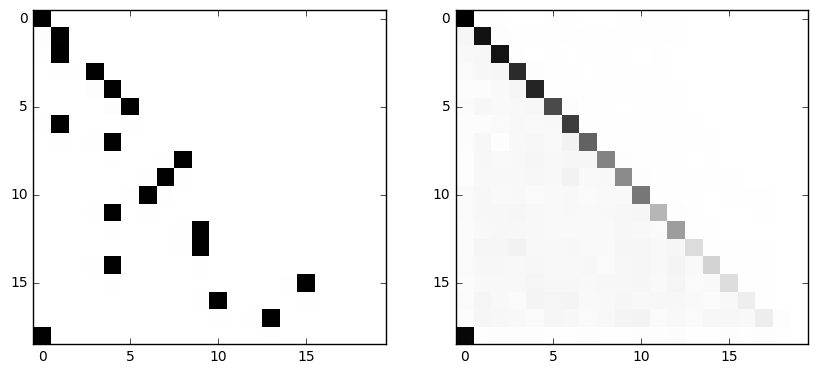

Epoch #19800
    Loss: -0.0213912371546


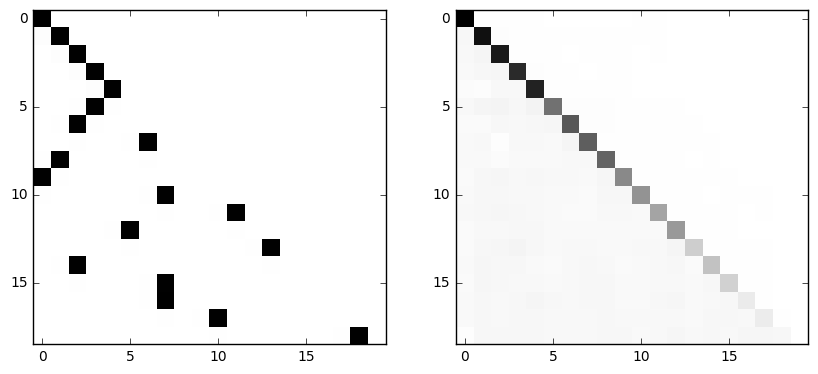

Epoch #19900
    Loss: -0.0334564745426


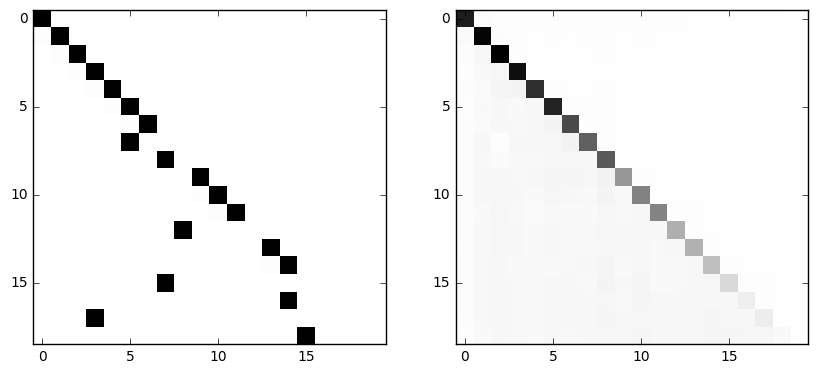

In [35]:
for e in range(n_epochs * n_batch_per_epoch):
    
    # Generate training data
    X, y = generate_training_batch(batch_size, n_nodes)
    
    # Train
    ae_loss = autoencoder_model.train_on_batch(X, y)
    
    # Print
    if e % 100 == 0:
        print("Epoch #{0}".format(e))
        print("    Loss: {0}".format(ae_loss))
    
    # Display
    if e % 100 == 0:
        y_pred = autoencoder_model.predict(X)
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(y[0, :, :], cmap='Greys', interpolation='none')
        plt.subplot(1,2,2)
        plt.imshow(y_pred[0, :, :], cmap='Greys', interpolation='none')
        plt.show()

In [18]:
y_pred = autoencoder_model.predict(X)
y_pred.shape

(1, 19, 20)

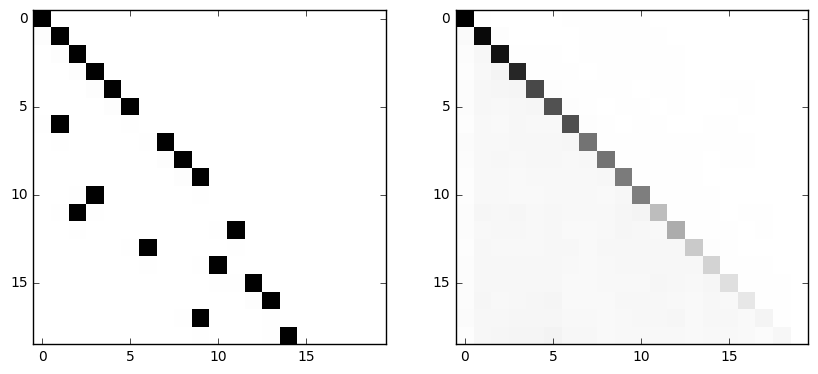

In [19]:
for ex in range(batch_size):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(y[ex, :, :], cmap='Greys', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(y_pred[ex, :, :], cmap='Greys', interpolation='none')
    plt.show()

In [22]:
y_pred[ex, :, :].argmax(axis=1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17,  5])

In [23]:
y.argmax(axis=1)

array([[ 0,  1,  2,  3,  4,  5, 13,  7,  8,  9, 14, 12, 15, 16, 18,  0,  0,
         0,  0,  0]])

### Masked softmax

In [35]:
def masked_softmax(input_layer, n_nodes, batch_size):
    """
    A Lambda layer to mask a matrix of outputs to be lower-triangular.
    Each row must sum up to one. We apply a lower triangular mask of ones
    and then add an upper triangular mask of a large negative number.

    Parameters
    ----------
    input_layer: keras layer object
        (n x 1, n) matrix
    Returns
    ------- 
    output_layer: keras layer object
        (n x 1, n) matrix
    """
    mask_lower = K.theano.tensor.tril(K.ones((n_nodes - 1, n_nodes)))
    mask_upper = K.theano.tensor.triu(-100. * K.ones((n_nodes - 1, n_nodes)), 1)
    mask_layer = mask_lower * input_layer + mask_upper
    mask_layer = K.reshape(mask_layer, (batch_size * (n_nodes -1), n_nodes))
    softmax_layer = K.softmax(mask_layer)
    output_layer = K.reshape(softmax_layer, (batch_size, n_nodes -1, n_nodes))
    return output_layer

In [36]:
input_layer = Input(shape=(n_nodes - 1, n_nodes))
dense_layer = TimeDistributed(Dense(20))(input_layer)

In [49]:
lambda_args = {'n_nodes': n_nodes, 'batch_size': 1}
#lambda_args = {'n_nodes': n_nodes}
next_layer = Lambda(masked_softmax,
                    output_shape=(n_nodes - 1, n_nodes),
                    arguments=lambda_args)(dense_layer)

In [50]:
test_model = Model(input=input_layer, output=next_layer)

In [51]:
test_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 19, 20)        0                                            
____________________________________________________________________________________________________
timedistributed_4 (TimeDistribut (None, 19, 20)        420         input_4[0][0]                    
____________________________________________________________________________________________________
lambda_8 (Lambda)                (None, 19, 20)        0           timedistributed_4[0][0]          
Total params: 420
Trainable params: 420
Non-trainable params: 0
____________________________________________________________________________________________________


In [52]:
example_input = np.random.randn(1, 19, 20)
#example_input = example_input * np_mask
#example_input.shape
#plt.imshow(example_input[0], interpolation='none', cmap='Greys')
#plt.colorbar()
#plt.show()

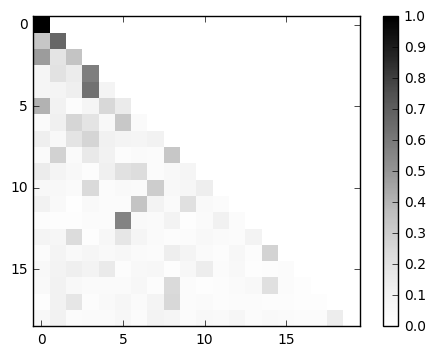

In [54]:
tmp = test_model.predict(example_input)
plt.imshow(tmp[0,:,:], interpolation='none', cmap='Greys')
plt.colorbar()
plt.show()

In [312]:
tmp.shape

(10, 19, 20)

In [298]:
tmp.sum(axis=1)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.99999994], dtype=float32)

In [278]:
np_mask = np.tril(np.ones((n_nodes - 1, n_nodes))) + \
       np.triu(-100. * np.ones((n_nodes - 1, n_nodes)), 1)

In [279]:
np_mask[0,0]

1.0

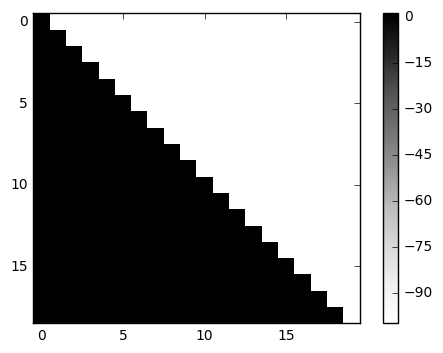

In [280]:
plt.imshow(np_mask, cmap='Greys', interpolation='none')
plt.colorbar()
plt.show()


In [257]:
tmp = np.zeros((2,3,4))
tmp[0, :, :] = [[1., 2., 3., 4.], [4., 2., 7., 8.], [0., 1., 4., 2.]]
tmp[1, :, :] = [[-1., -2., -3., -4.], [-4., -2., -7., -8.], [-0., -1., -4., -2.]]

In [258]:
tmp.shape

(2, 3, 4)

In [269]:
tmp

array([[[ 1.,  2.,  3.,  4.],
        [ 4.,  2.,  7.,  8.],
        [ 0.,  1.,  4.,  2.]],

       [[-1., -2., -3., -4.],
        [-4., -2., -7., -8.],
        [-0., -1., -4., -2.]]])

In [260]:
tmp2 = tmp.reshape((6, 4))
tmp2.shape

(6, 4)

In [268]:
tmp2

array([[  2.,   4.,   6.,   8.],
       [  8.,   4.,  14.,  16.],
       [  0.,   2.,   8.,   4.],
       [ -2.,  -4.,  -6.,  -8.],
       [ -8.,  -4., -14., -16.],
       [ -0.,  -2.,  -8.,  -4.]])

In [265]:
tmp2 = np

In [266]:
tmp3 = tmp2.reshape((2,3,4))
tmp3.shape

(2, 3, 4)

In [267]:
tmp3

array([[[  2.,   4.,   6.,   8.],
        [  8.,   4.,  14.,  16.],
        [  0.,   2.,   8.,   4.]],

       [[ -2.,  -4.,  -6.,  -8.],
        [ -8.,  -4., -14., -16.],
        [ -0.,  -2.,  -8.,  -4.]]])